In [1]:
import arviz as az
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import os
import pandas as pd
import seaborn as sns
import pymc as pm
import pytensor.tensor as pt
import pytensor as pyt
import xarray as xr
from matplotlib.patches import Ellipse
from sklearn.utils import resample
import random
import nutpie
import numpyro
import blackjax
import requests
az.style.use("arviz-darkgrid")
pyt.config.exception_verbosity = 'low'

In [2]:
# DOI for your dataset
doi_url = "https://doi.org/10.6084/m9.figshare.27061012.v1"

# Convert DOI to the Figshare URL
figshare_api_url = "https://api.figshare.com/v2/articles/27061012"

# Fetch the metadata of the Figshare article
response = requests.get(figshare_api_url)
article_metadata = response.json()

# Extract files from the metadata
files = article_metadata['files']

# Download each file
for file in files:
    file_name = file['name']
    file_url = file['download_url']
    
    print(f"Downloading {file_name}...")
    
    # Request the file
    file_response = requests.get(file_url)
    
    # Save the file to the current directory
    with open(file_name, 'wb') as f:
        f.write(file_response.content)
    
    print(f"Saved {file_name} successfully!")

Saved model_session_final.csv successfully!
Saved model_trial_final.csv successfully!


In [3]:
print(pm.__version__)

5.12.0


In [4]:
first_day_value = 1
first_trial_value = 1

In [5]:
def gamma_shra_from_modesd(m, s):
    v = s**2
    ra = (m + np.sqrt(m**2 + 4*v)) / (2*v)
    sh = 1+m*ra
    return sh,ra

In [6]:


df = pd.read_csv('model_trial_final.csv')

plotfolder = ('D:\modelforpaper\FOVezmodel\plots')

In [7]:
# Combine head and tail into one DataFrame
combined_df = pd.concat([df.head(), df.tail()])

# Display with styling
combined_df.style


## Define model

### Priors

#### μ_μ hyper priors
The mean value of the fish behavior for each day

In [8]:
# Priors for Aμμ
df_avg = df.groupby(['fish', 'stage', 'day']).agg({'yds': 'mean'}).reset_index()

mean_first_day = df_avg[df_avg['day'] == first_day_value]
max_day_indices = df_avg.groupby(['fish', 'stage'])['day'].idxmax()
mean_last_day = df_avg.loc[max_day_indices]

merged_data = pd.merge(mean_first_day, mean_last_day, on=['fish', 'stage'], suffixes=('_first', '_last'))
merged_data['difference'] = merged_data['yds_first'] - merged_data['yds_last']

μ_Aμμ = merged_data['difference'].mean()
σ_Aμμ = merged_data['difference'].std()

# Priors for τ_μμ
merged_data['halfway_yds'] = (merged_data['yds_first'] + merged_data['yds_last']) / 2
df_avg = pd.merge(df_avg, merged_data[['fish', 'stage', 'halfway_yds']], on=['fish', 'stage'])

df_avg_below_halfway = df_avg[df_avg['yds'] < df_avg['halfway_yds']].groupby(['fish', 'stage']).agg({'day': 'first'}).reset_index()

mode_τμ = df_avg_below_halfway['day'].mean()*2
σ_τμ = df_avg_below_halfway['day'].std()*2

sh_τμ,ra_τμ = gamma_shra_from_modesd(mode_τμ, σ_τμ)

# Priors for μ_μ∞
μ_μμ_inf = mean_last_day['yds'].mean()
σ_μμ_inf = mean_last_day['yds'].std()

#### σ_μ hyper priors
The standard deviation across fish for the mean behavior on each day.

In [9]:
# Priors for Aσμ
mode_Aσμ = merged_data['difference'].std()
std_Aσμ = merged_data['difference'].std()

sh_Aσμ,ra_Aσμ = gamma_shra_from_modesd(mode_Aσμ, std_Aσμ)

# Priors for σ_μ∞
mode_σμ_inf = mean_last_day['yds'].std()
std_σμ_inf = mean_last_day['yds'].std()

sh_σμ_inf,ra_σμ_inf = gamma_shra_from_modesd(mode_σμ_inf, std_σμ_inf)

#### σ priors
This is the prior for the σ which controls the likelihood.

In [10]:
# Priors for Aμσ
df_std = df.groupby(['fish', 'stage', 'day']).agg({'yds': 'std'}).reset_index()
df_std.rename(columns={'yds': 'std_yds'}, inplace=True)

std_mean = np.mean(df_std['std_yds'])
std_std = np.std(df_std['std_yds'])

mode_σ = std_mean
σ_σ = std_std

sh_σ,ra_σ = gamma_shra_from_modesd(mode_σ,σ_σ)

### PyMC model code
#### Make codings for fish and stage

In [11]:
fish_list = [10, 12, 14,21,3, 7, 9,]
days = {'Baseline': 25, 'Rotation': 15, 'Washout': 10, 'ReRotation': 15, 'ReWashout': 10}
stage_list = ['Baseline', 'Rotation', 'Washout', 'ReRotation', 'ReWashout']

fish_index_map = {fish: index for index, fish in enumerate(fish_list)}
stage_index_map = {stage: index for index, stage in enumerate(stage_list)}
# Extracting just the numeric part of the 'fish' column
df['fish_id'] = df['fish'].str.extract('(\d+)').astype(int)  # \d+ matches one or more digits
fish_index_map = {fish: index for index, fish in enumerate(fish_list)}
# Replace fish numbers with their corresponding indices
df['fish_index'] = df['fish_id'].map(fish_index_map)
df['stage_index'] = df['stage'].map(stage_index_map)
df['day_index'] = df['day'] - first_day_value
num_data = df.shape[0]
coords = {
    "fish": fish_list,
    "stages": stage_list,
    "data": np.arange(num_data),
}

In [12]:
μ_ν = 10
with pm.Model(coords=coords) as m4_yds:
    ### Constants
    fish_ = pm.ConstantData('fish_', df['fish_index'], dims='data')
    stage_ = pm.ConstantData('stage_', df['stage_index'], dims='data')
    day_ = pm.ConstantData('day_', df['day_index'], dims='data')

    ### level 4: Priors for μ_μ, μ_σ, σ_μ, σ_σ
    A_μμ = pm.Normal('A_μμ', mu=μ_Aμμ, sigma=σ_Aμμ, dims=('fish', 'stages'))
    τ_μ = pm.Gamma('τ_μ', alpha=sh_τμ, beta=ra_τμ, dims=('fish', 'stages'))
    μ_μ_inf = pm.Normal('μ_μ_inf', mu=μ_μμ_inf, sigma=σ_μμ_inf, dims=('fish', 'stages'))

    A_σμ = pm.Gamma('A_σμ', alpha=sh_Aσμ, beta=ra_Aσμ, dims=('fish', 'stages'))
    σ_μ_inf = pm.Gamma('σ_μ_inf', alpha=sh_σμ_inf, beta=ra_σμ_inf, dims=('fish', 'stages'))

    ### level 3: Regression equations for μ and σ
    μ_μ = pm.Deterministic('μ_μ', A_μμ[fish_,stage_]*pm.math.exp(-day_ / τ_μ[fish_,stage_]) + μ_μ_inf[fish_,stage_], dims='data' )
    σ_μ = pm.Deterministic('σ_μ', A_σμ[fish_,stage_]*pm.math.exp(-day_ / τ_μ[fish_,stage_]) + σ_μ_inf[fish_,stage_], dims='data')


    #  ### level 2: Priors for the likelihood
    # μ_std = pm.Normal('μ_std', mu=0, sigma=1, dims='data')
    # μ = pm.Deterministic('μ', μ_μ + μ_std*σ_μ)    
    # # μ = pm.Normal('μ', mu=μ_μ, sigma=σ_μ, dims='data')    
    # σ = pm.Gamma('σ', alpha=sh_σ, beta=ra_σ, dims='data')
    ν = pm.Exponential('ν', lam=1/μ_ν)
    
    ### data likelihood level 1
    # y = pm.StudentT('y', mu=μ, sigma=σ, nu=ν, observed=df['yds'], dims='data')
    y = pm.StudentT('y', mu=μ_μ, sigma=σ_μ, nu=ν, observed=df['yds'], dims='data')



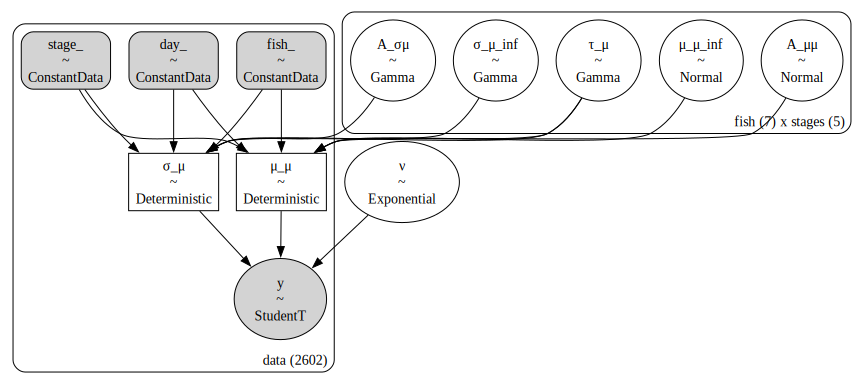

In [13]:
pm.model_to_graphviz(m4_yds)

# Priors
## Sample prior predictive

In [14]:
id_yds = pm.sample_prior_predictive(samples=200, model=m4_yds)
prior = id_yds.prior
pp = id_yds.prior_predictive
cd = id_yds.constant_data

Sampling: [A_μμ, A_σμ, y, μ_μ_inf, ν, σ_μ_inf, τ_μ]


In [15]:
start_day = -25
last_day = start_day

day_ranges = {}
for stage in stage_list:
    day_ranges[stage] = np.arange(last_day, last_day+days[stage])
    last_day = np.max(day_ranges[stage])+1

In [16]:
def plot_hyperparameter_time_course(A_param, τ_param, inf_param, param_name):
    fig, axes = plt.subplots(len(fish_list), 1, figsize=(25, 20)) # Adjust the size as needed
    num_draws_to_plot = 20

    for fish_id,fish_index in fish_index_map.items():
        draws_f = np.random.choice(prior.draw.values, size=num_draws_to_plot, replace=False)
        for stage_id,stage_index in stage_index_map.items():
            prior_fs = prior.sel({'fish': fish_id, 'stages': stage_id, 'draw': draws_f}).squeeze()
            A_fs = prior_fs[A_param]
            inf_fs = prior_fs[inf_param]
            τ_fs = prior_fs[τ_param]
            
            stage_days = xr.DataArray(np.arange(days[stage_id]), dims="days")
            param_vals = A_fs * np.exp(-stage_days / τ_fs) + inf_fs
            
            ax = axes[fish_index] # Get the specific subplot
            ax.plot(day_ranges[stage_id], param_vals.values.T, alpha=0.4, label=f"{stage_id}")
            ax.set_xlabel("Days")
            ax.set_ylabel(param_name)
            ax.set_title(f"Fish {fish_id}")


    fig.suptitle(f'Prior Predictive Checks for {param_name}', fontsize=16)  # Add a main title here
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
    plt.tight_layout(pad=4.0)
    plt.show()

## prior predictive plots

C:\Users\86153\AppData\Local\Temp\ipykernel_39092\4181599608.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title


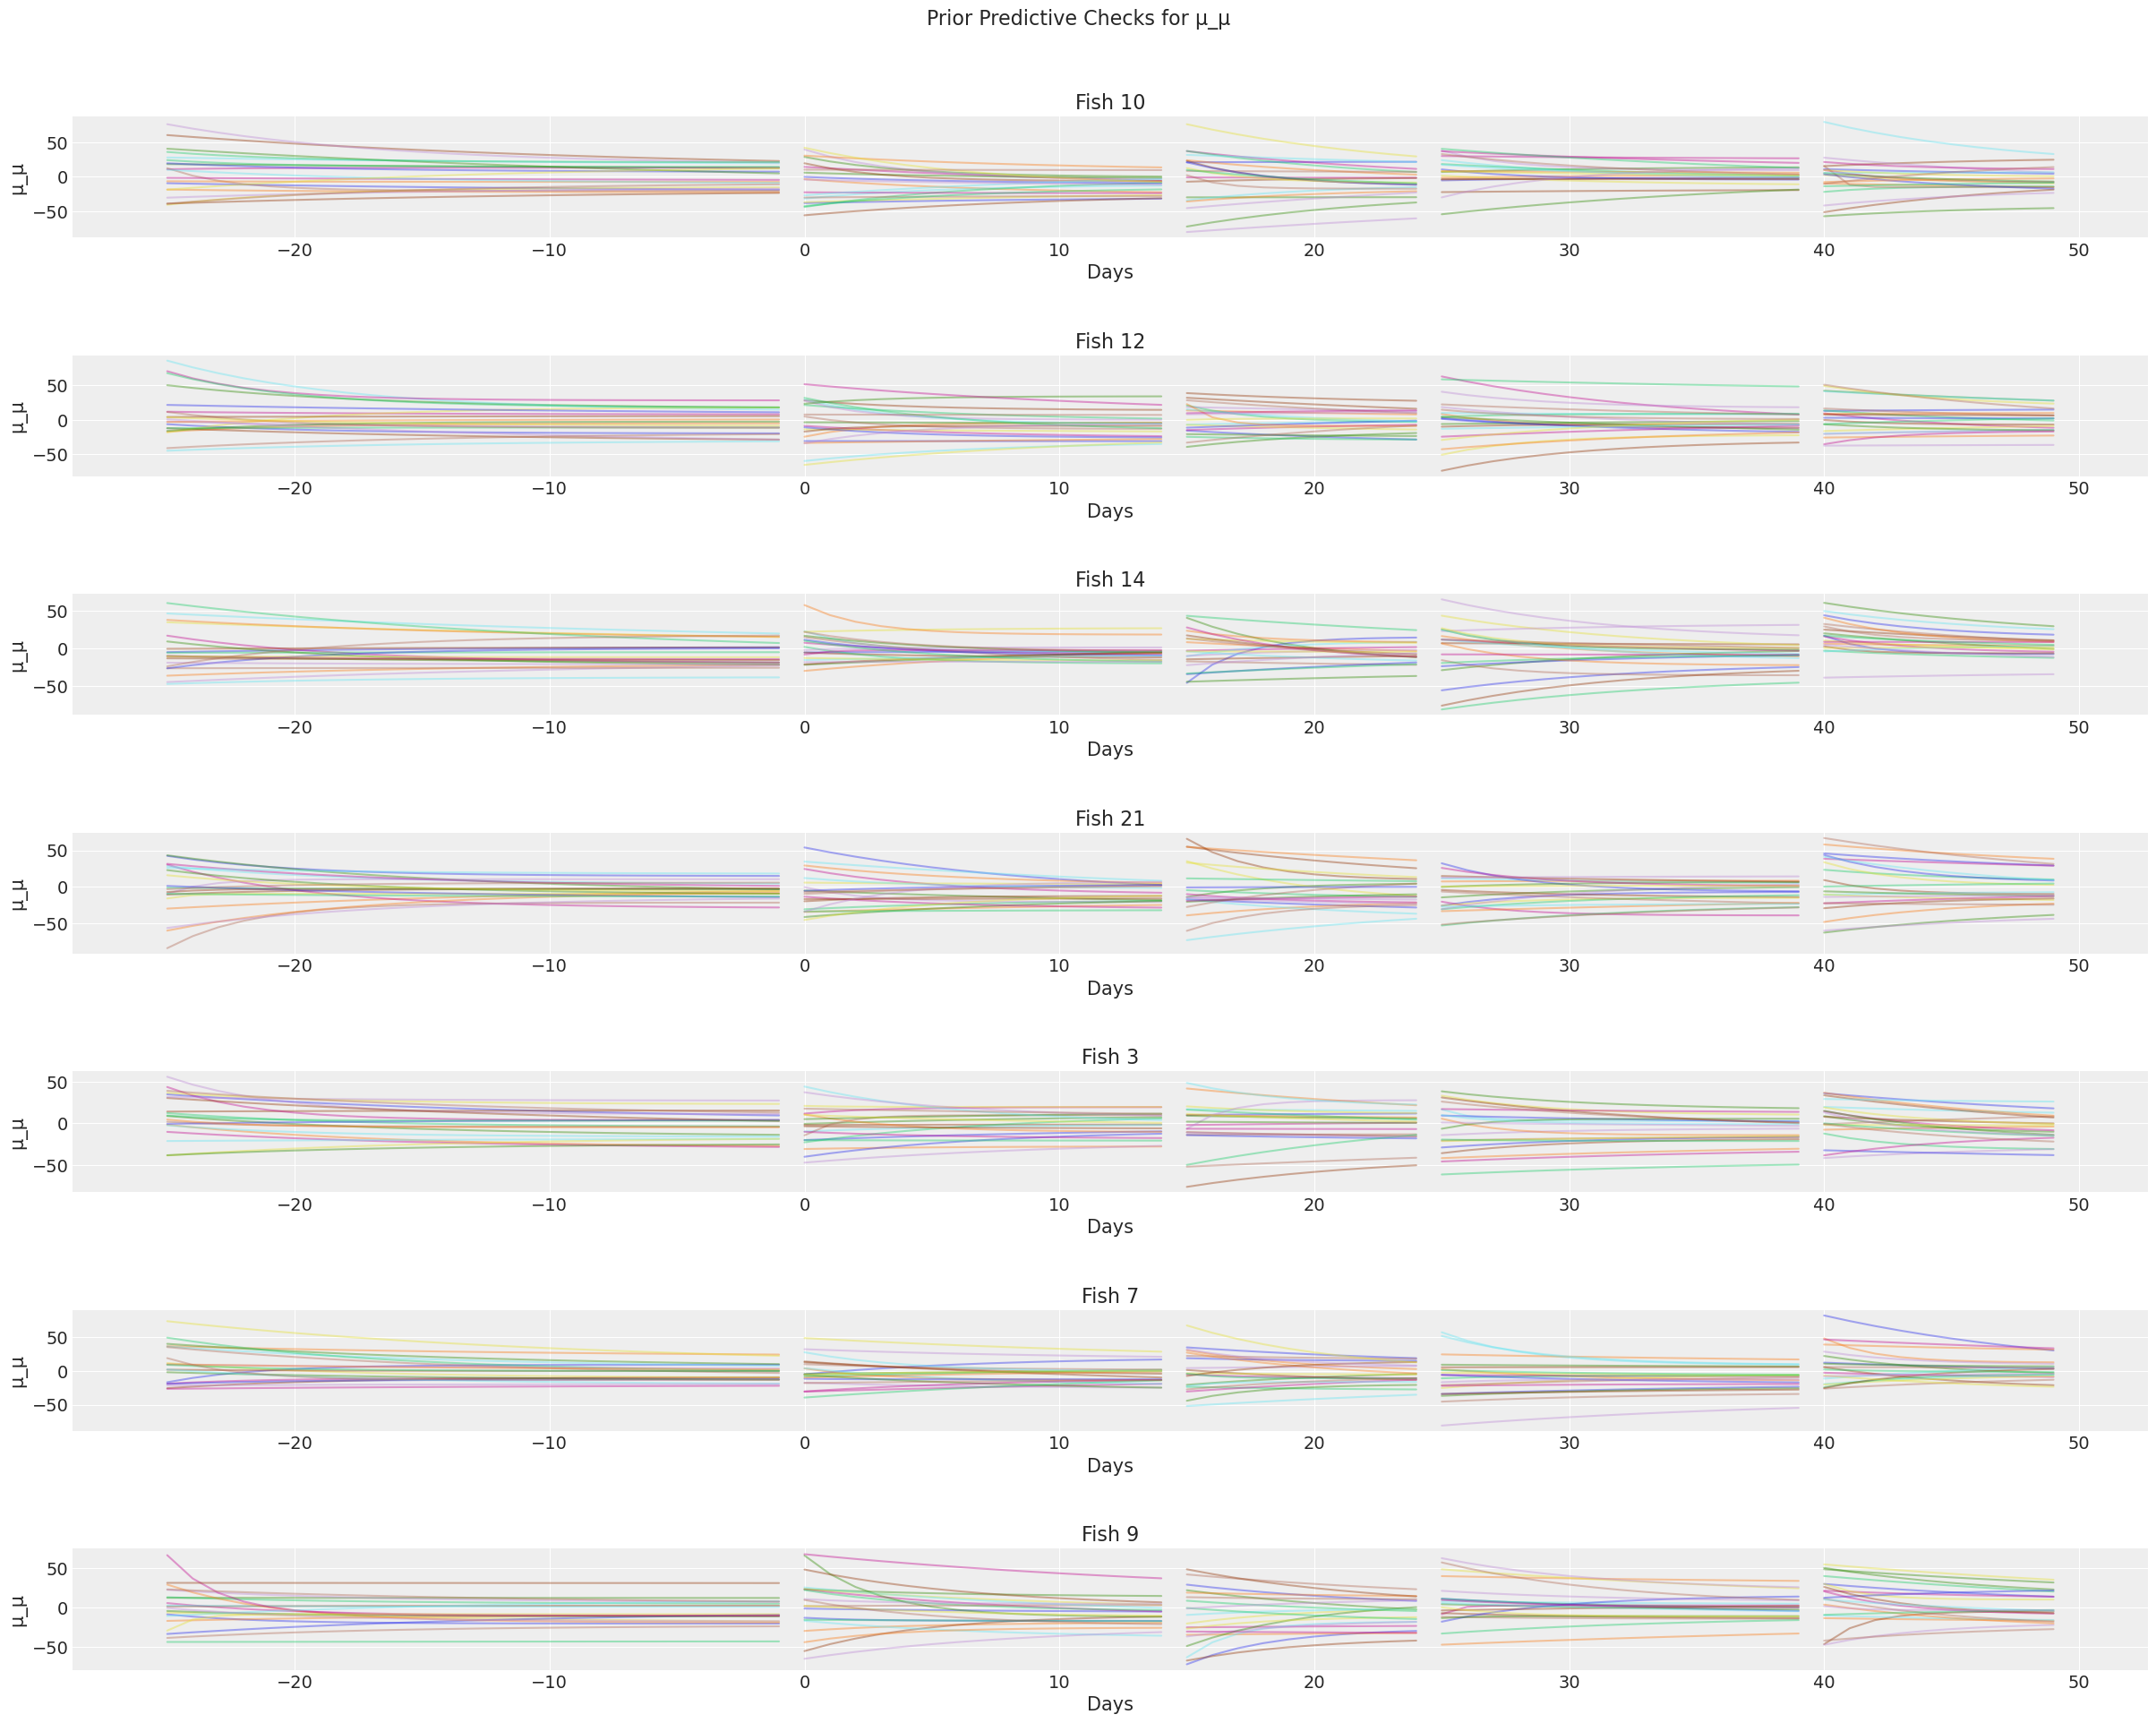

In [17]:
plot_hyperparameter_time_course("A_μμ", "τ_μ", "μ_μ_inf", "μ_μ")

C:\Users\86153\AppData\Local\Temp\ipykernel_39092\4181599608.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title


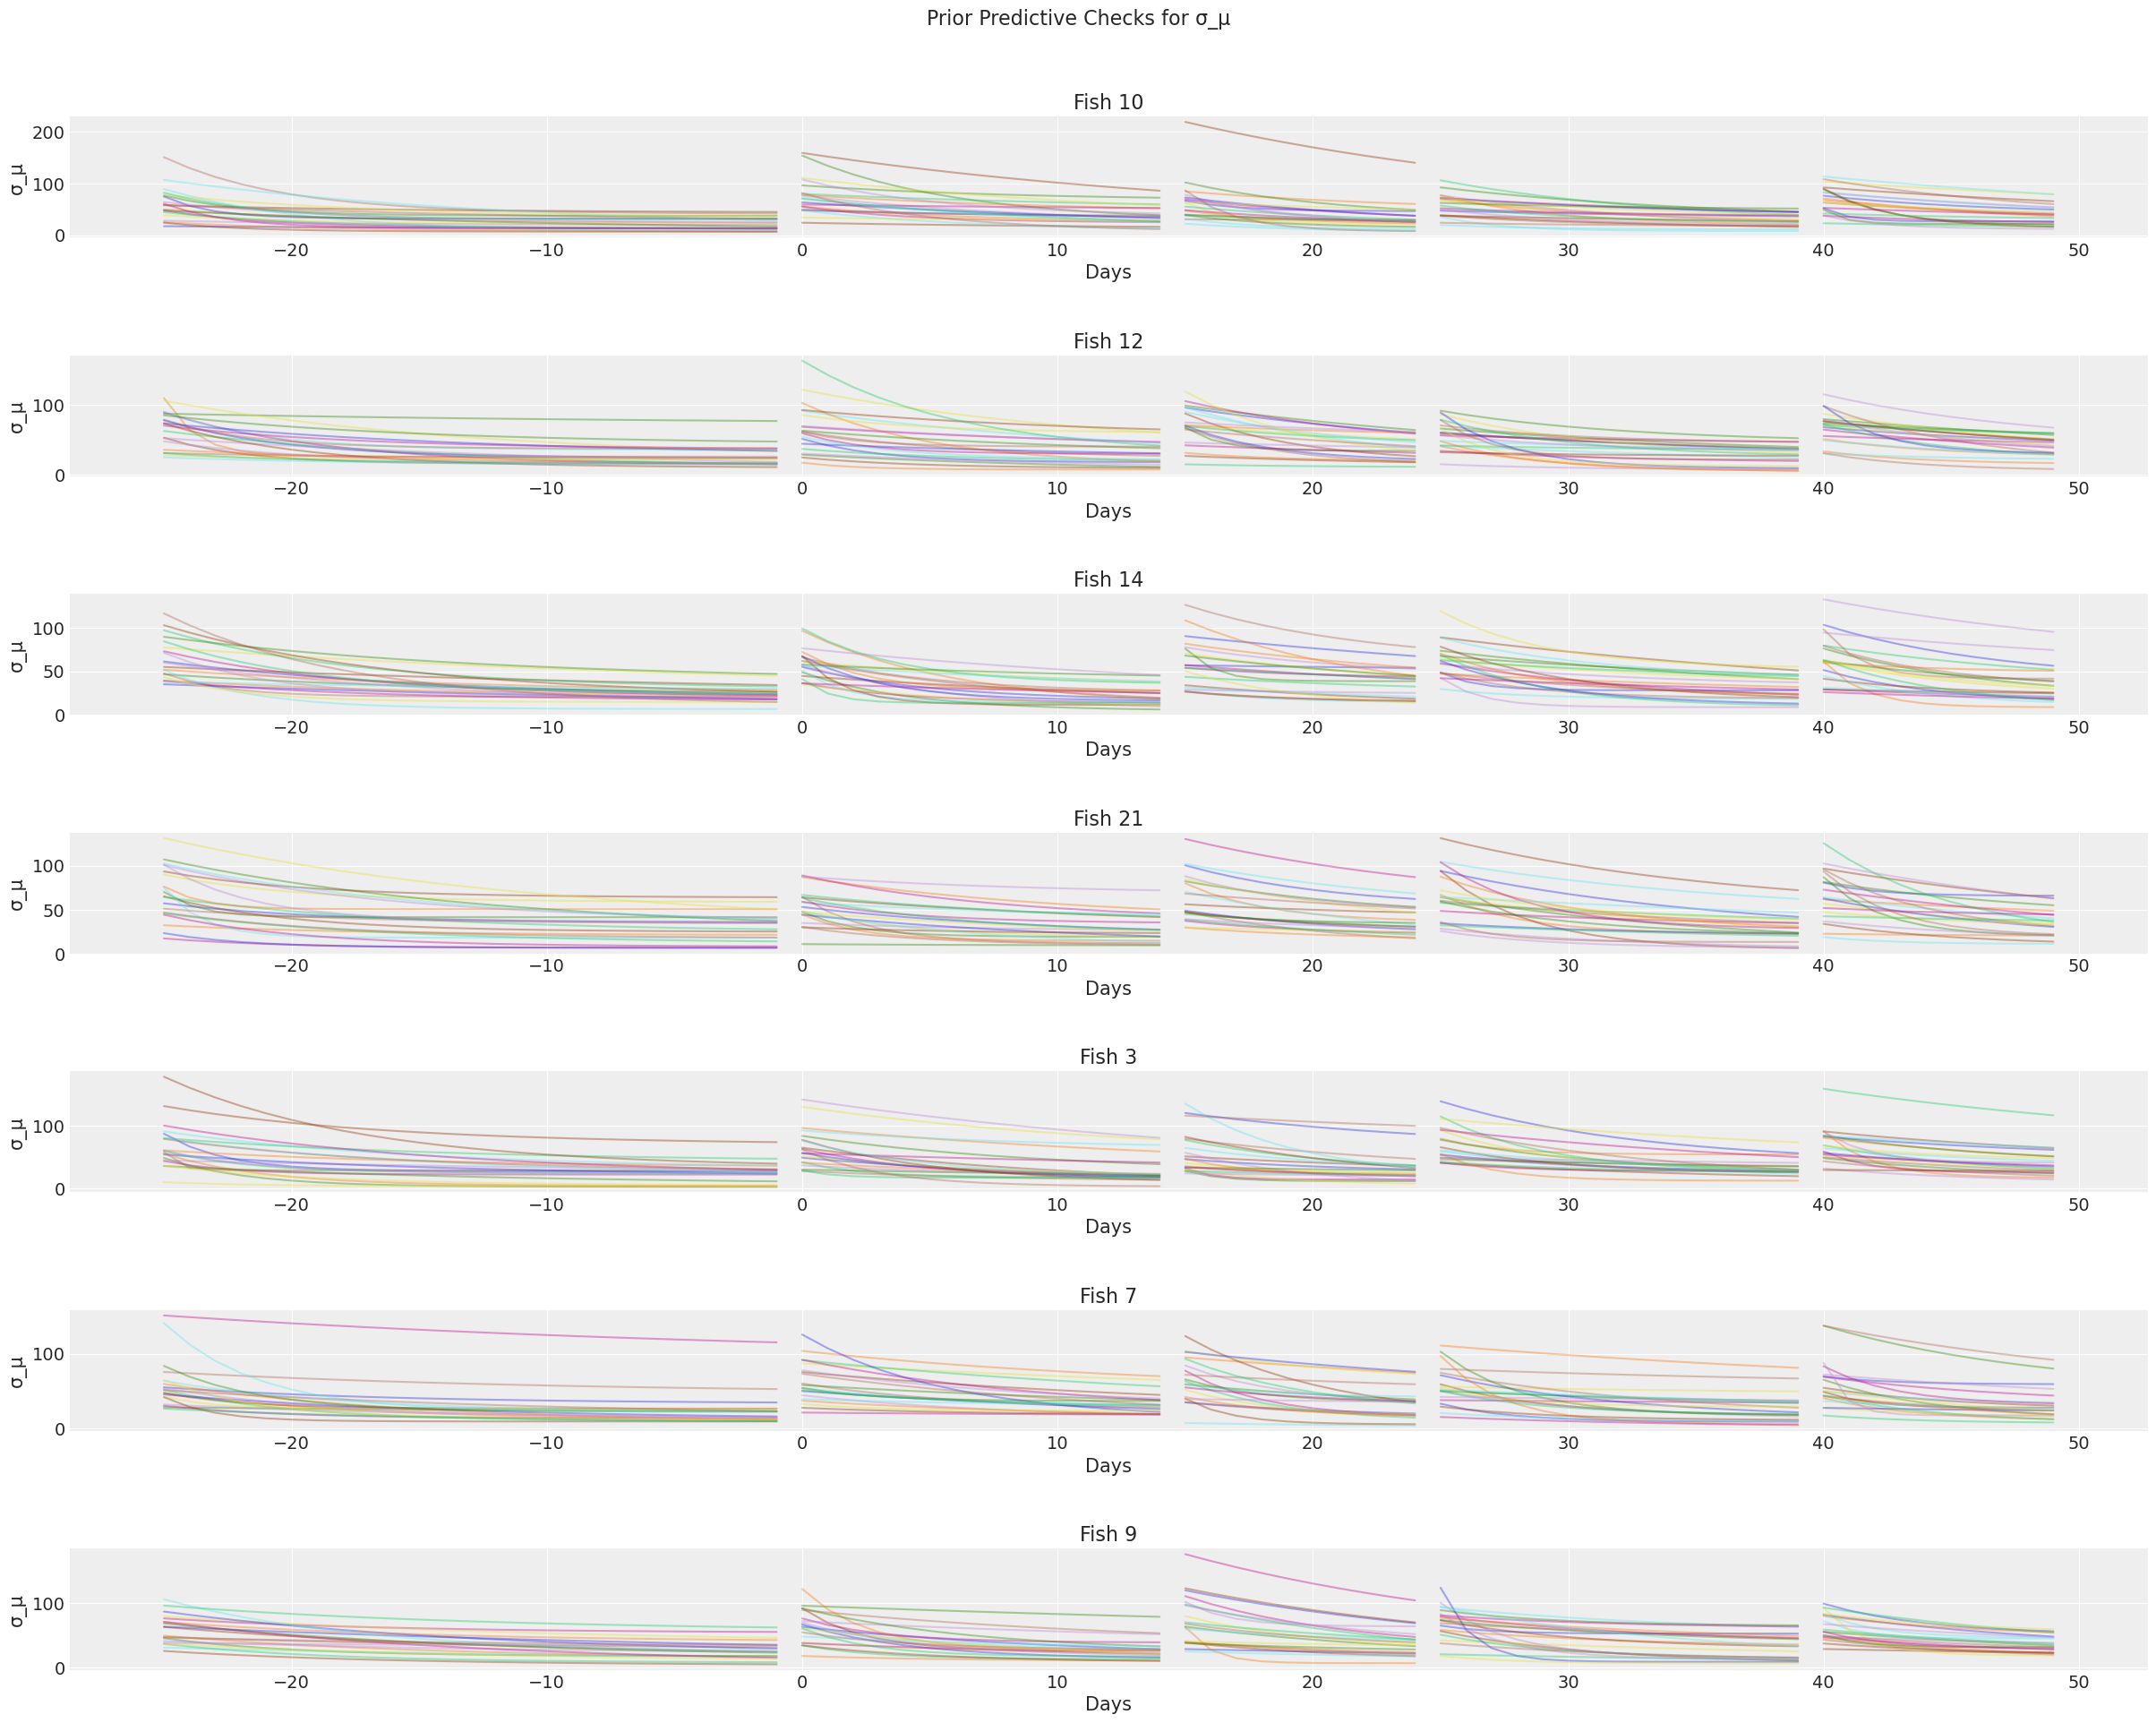

In [18]:
plot_hyperparameter_time_course("A_σμ", "τ_μ", "σ_μ_inf", "σ_μ")

In [19]:
# index_stage_map = {v: k for k, v in stage_index_map.items()}
# day_range_ = xr.ones_like(cd.day_)
# for i in day_range_['data']:
#     stage_id = index_stage_map[cd.stage_[i].item()]
#     day_range_[i] = day_ranges[stage_id][cd.day_[i].item()-1]


In [20]:
def plot_data_time_course_across_fish(day, data, data_name):
    plot_ds = xr.Dataset(data_vars={'day': day, 'data': data})

    fig, ax = plt.subplots(1, 1, figsize=(14, 3)) # Adjust the size as needed

    plot_df = plot_ds.to_dataframe().reset_index()
    plot_df['day'] = plot_df['day'].astype(int)
    sns.violinplot(data=plot_df, x='day', y='data', ax=ax, inner='quartile')
    ax.set_title(f'{data_name}')
    ax.set_xlabel('Days')
    ax.set_ylabel(f'{data_name}')

In [21]:
# plot_ds = xr.Dataset(data_vars={'day': day_range_, 'fish': cd.fish_, 'sigma_y': prior['σ']})

# fig, ax = plt.subplots(1, 1, figsize=(14, 3)) # Adjust the size as needed

# plot_df = plot_ds.to_dataframe().reset_index()
# plot_df['day'] = plot_df['day'].astype(int)
# sns.violinplot(data=plot_df, x='day', y='sigma_y', ax=ax, inner='quartile')
# ax.set_title(f'Prior sigma_y')
# ax.set_xlabel('Days')
# ax.set_ylabel('sigma_yds')

## NumPyro JAX NUTS sampler and diagnostics

In [22]:
with m4_yds:
    id_yds_numpyro = pm.sample(1000, tune=1000, target_accept=0.95, nuts_sampler="numpyro")

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [23]:
az.summary(id_yds_numpyro, var_names=['A_μμ'], coords={'stages': ['Rotation']})

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
A_μμ[10, Rotation]  12.279   6.126   1.088   24.230      0.110    0.086   
A_μμ[12, Rotation]   6.271   6.987  -6.420   19.733      0.136    0.108   
A_μμ[14, Rotation]  -3.210   6.519 -15.234    8.819      0.126    0.107   
A_μμ[21, Rotation]  16.496   4.241   8.822   24.339      0.067    0.051   
A_μμ[3, Rotation]   26.492  10.919   6.729   47.907      0.188    0.150   
A_μμ[7, Rotation]   15.380   5.079   6.490   25.384      0.110    0.086   
A_μμ[9, Rotation]   16.773   8.536   1.981   34.019      0.158    0.124   

                    ess_bulk  ess_tail  r_hat  
A_μμ[10, Rotation]    3128.0    2487.0    1.0  
A_μμ[12, Rotation]    2701.0    2322.0    1.0  
A_μμ[14, Rotation]    2782.0    2282.0    1.0  
A_μμ[21, Rotation]    4347.0    2793.0    1.0  
A_μμ[3, Rotation]     3872.0    2556.0    1.0  
A_μμ[7, Rotation]     2362.0    1895.0    1.0  
A_μμ[9, Rotation]     2998.0    2513.0    1.0

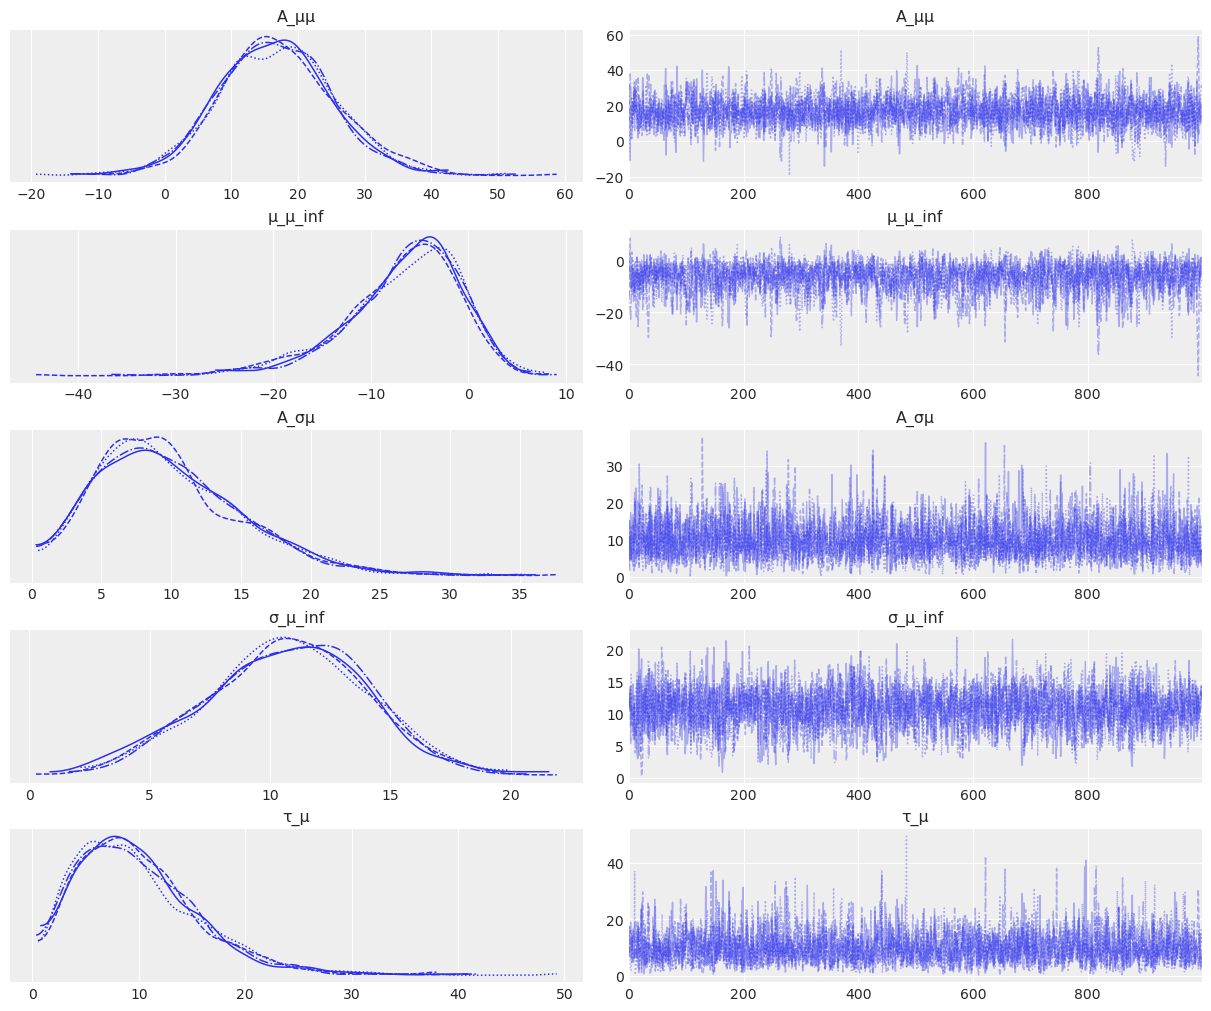

In [24]:
az.plot_trace(id_yds_numpyro, var_names=['A_μμ', 'μ_μ_inf', 'A_σμ', 'σ_μ_inf', 'τ_μ'], coords={'fish':9, 'stages': 'Rotation'});

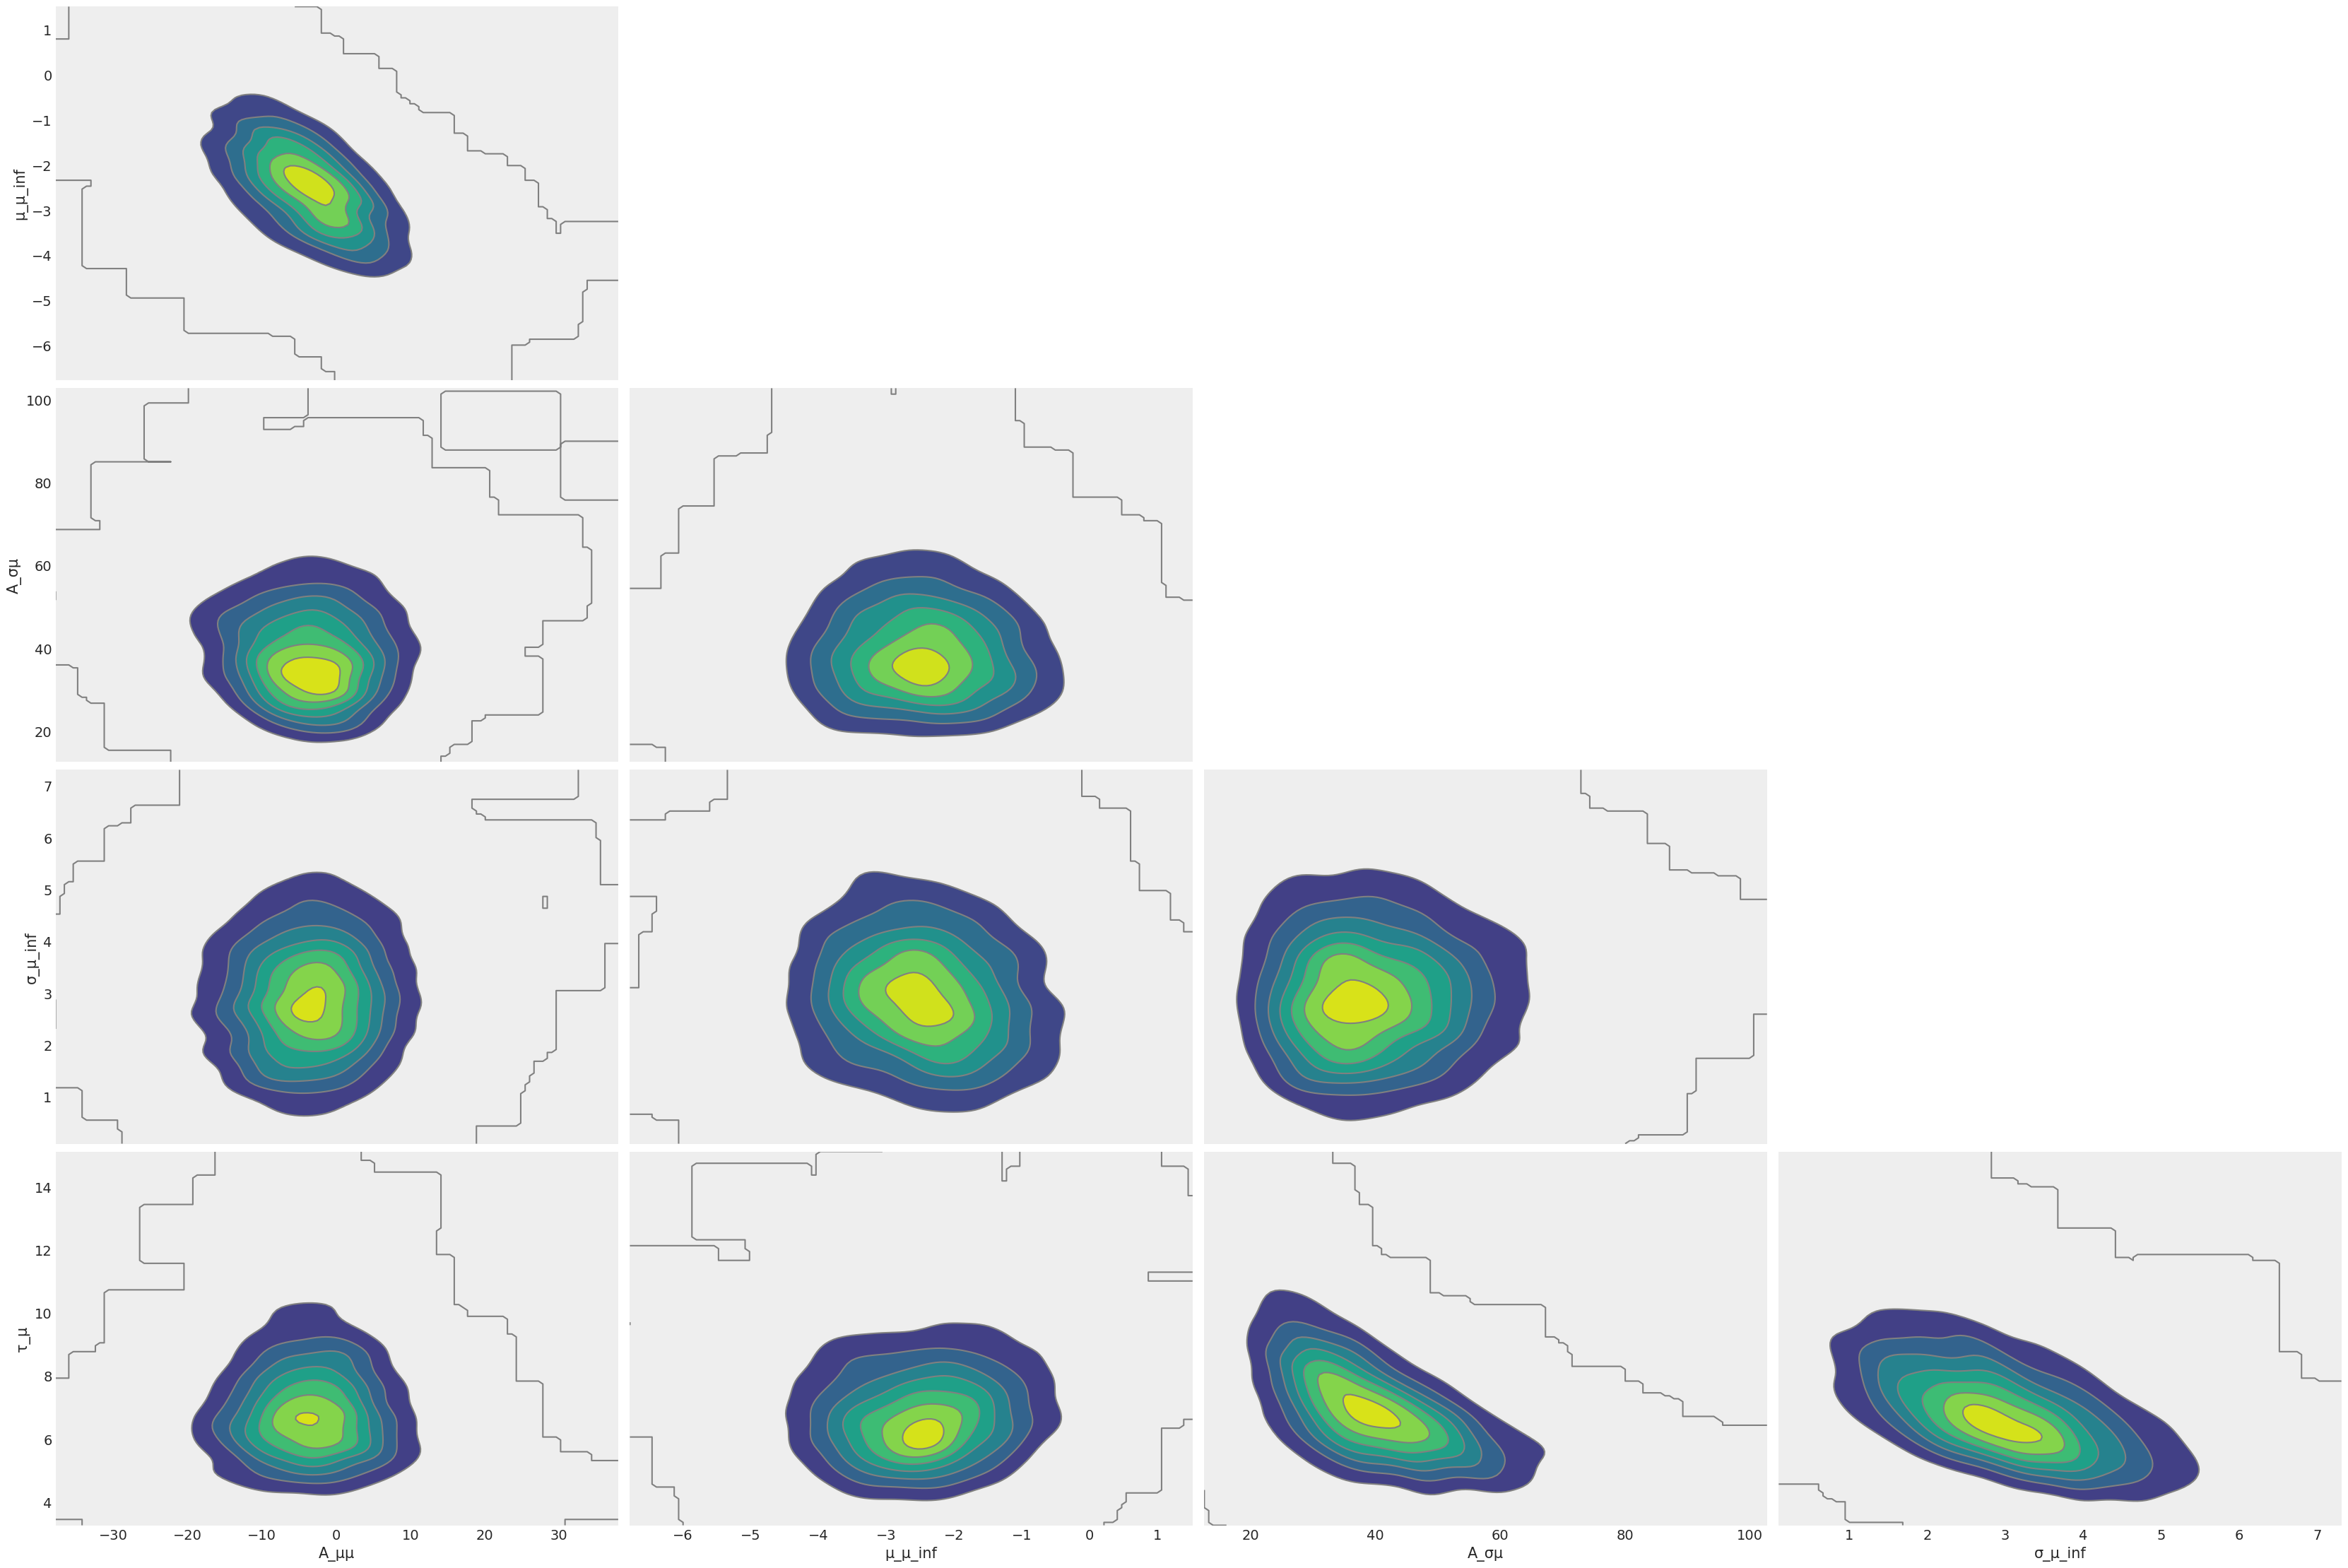

In [25]:
az.plot_pair(id_yds_numpyro, var_names=['A_μμ', 'μ_μ_inf', 'A_σμ', 'σ_μ_inf', 'τ_μ'], 
             coords={'fish':10, 'stages': 'Baseline'}, 
             divergences=True,
             kind='kde');

## Posterior preditive plots

In [26]:
with m4_yds:
    pm.sample_posterior_predictive(id_yds_numpyro, extend_inferencedata=True)

Sampling: [y]


In [27]:

posterior = id_yds_numpyro.posterior
ppc = id_yds_numpyro.posterior_predictive
cd = id_yds_numpyro.constant_data
obd = id_yds_numpyro.observed_data


In [28]:
def plot_hyperparameter_ppc_course(A_param, τ_param, inf_param, param_name):
    fig, axes = plt.subplots(len(fish_list), 1, figsize=(25, 40)) # Adjust the size as needed
    num_draws_to_plot = 20

    for fish_id,fish_index in fish_index_map.items():
        draws_f = np.random.choice(posterior.draw.values, size=num_draws_to_plot, replace=False)
        for stage_id,stage_index in stage_index_map.items():
            posterior_fs = posterior.sel({'fish': fish_id, 'stages': stage_id, 'draw': draws_f}).squeeze()
            A_fs = posterior_fs[A_param]
            inf_fs = posterior_fs[inf_param]
            τ_fs = posterior_fs[τ_param]
            
            stage_days = xr.DataArray(np.arange(days[stage_id]), dims="days")
            ppc_param_vals = A_fs * np.exp(-stage_days / τ_fs) + inf_fs
            
            ax = axes[fish_index]  # Get the specific subplot
            for draw_idx in range(num_draws_to_plot):
                ax.plot(day_ranges[stage_id], ppc_param_vals.values.T[:, draw_idx, 1], alpha=0.4, label=f"Draw {draw_idx + 1}")

            ax.set_xlabel("Days")
            ax.set_ylabel(param_name)
            ax.set_title(f"Fish {fish_id}")


    fig.suptitle(f'Posterior Predictive Checks for {param_name}', fontsize=16)  # Add a main title here
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
    plt.tight_layout(pad=4.0)
    plt.show()

C:\Users\86153\AppData\Local\Temp\ipykernel_39092\2590890671.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title


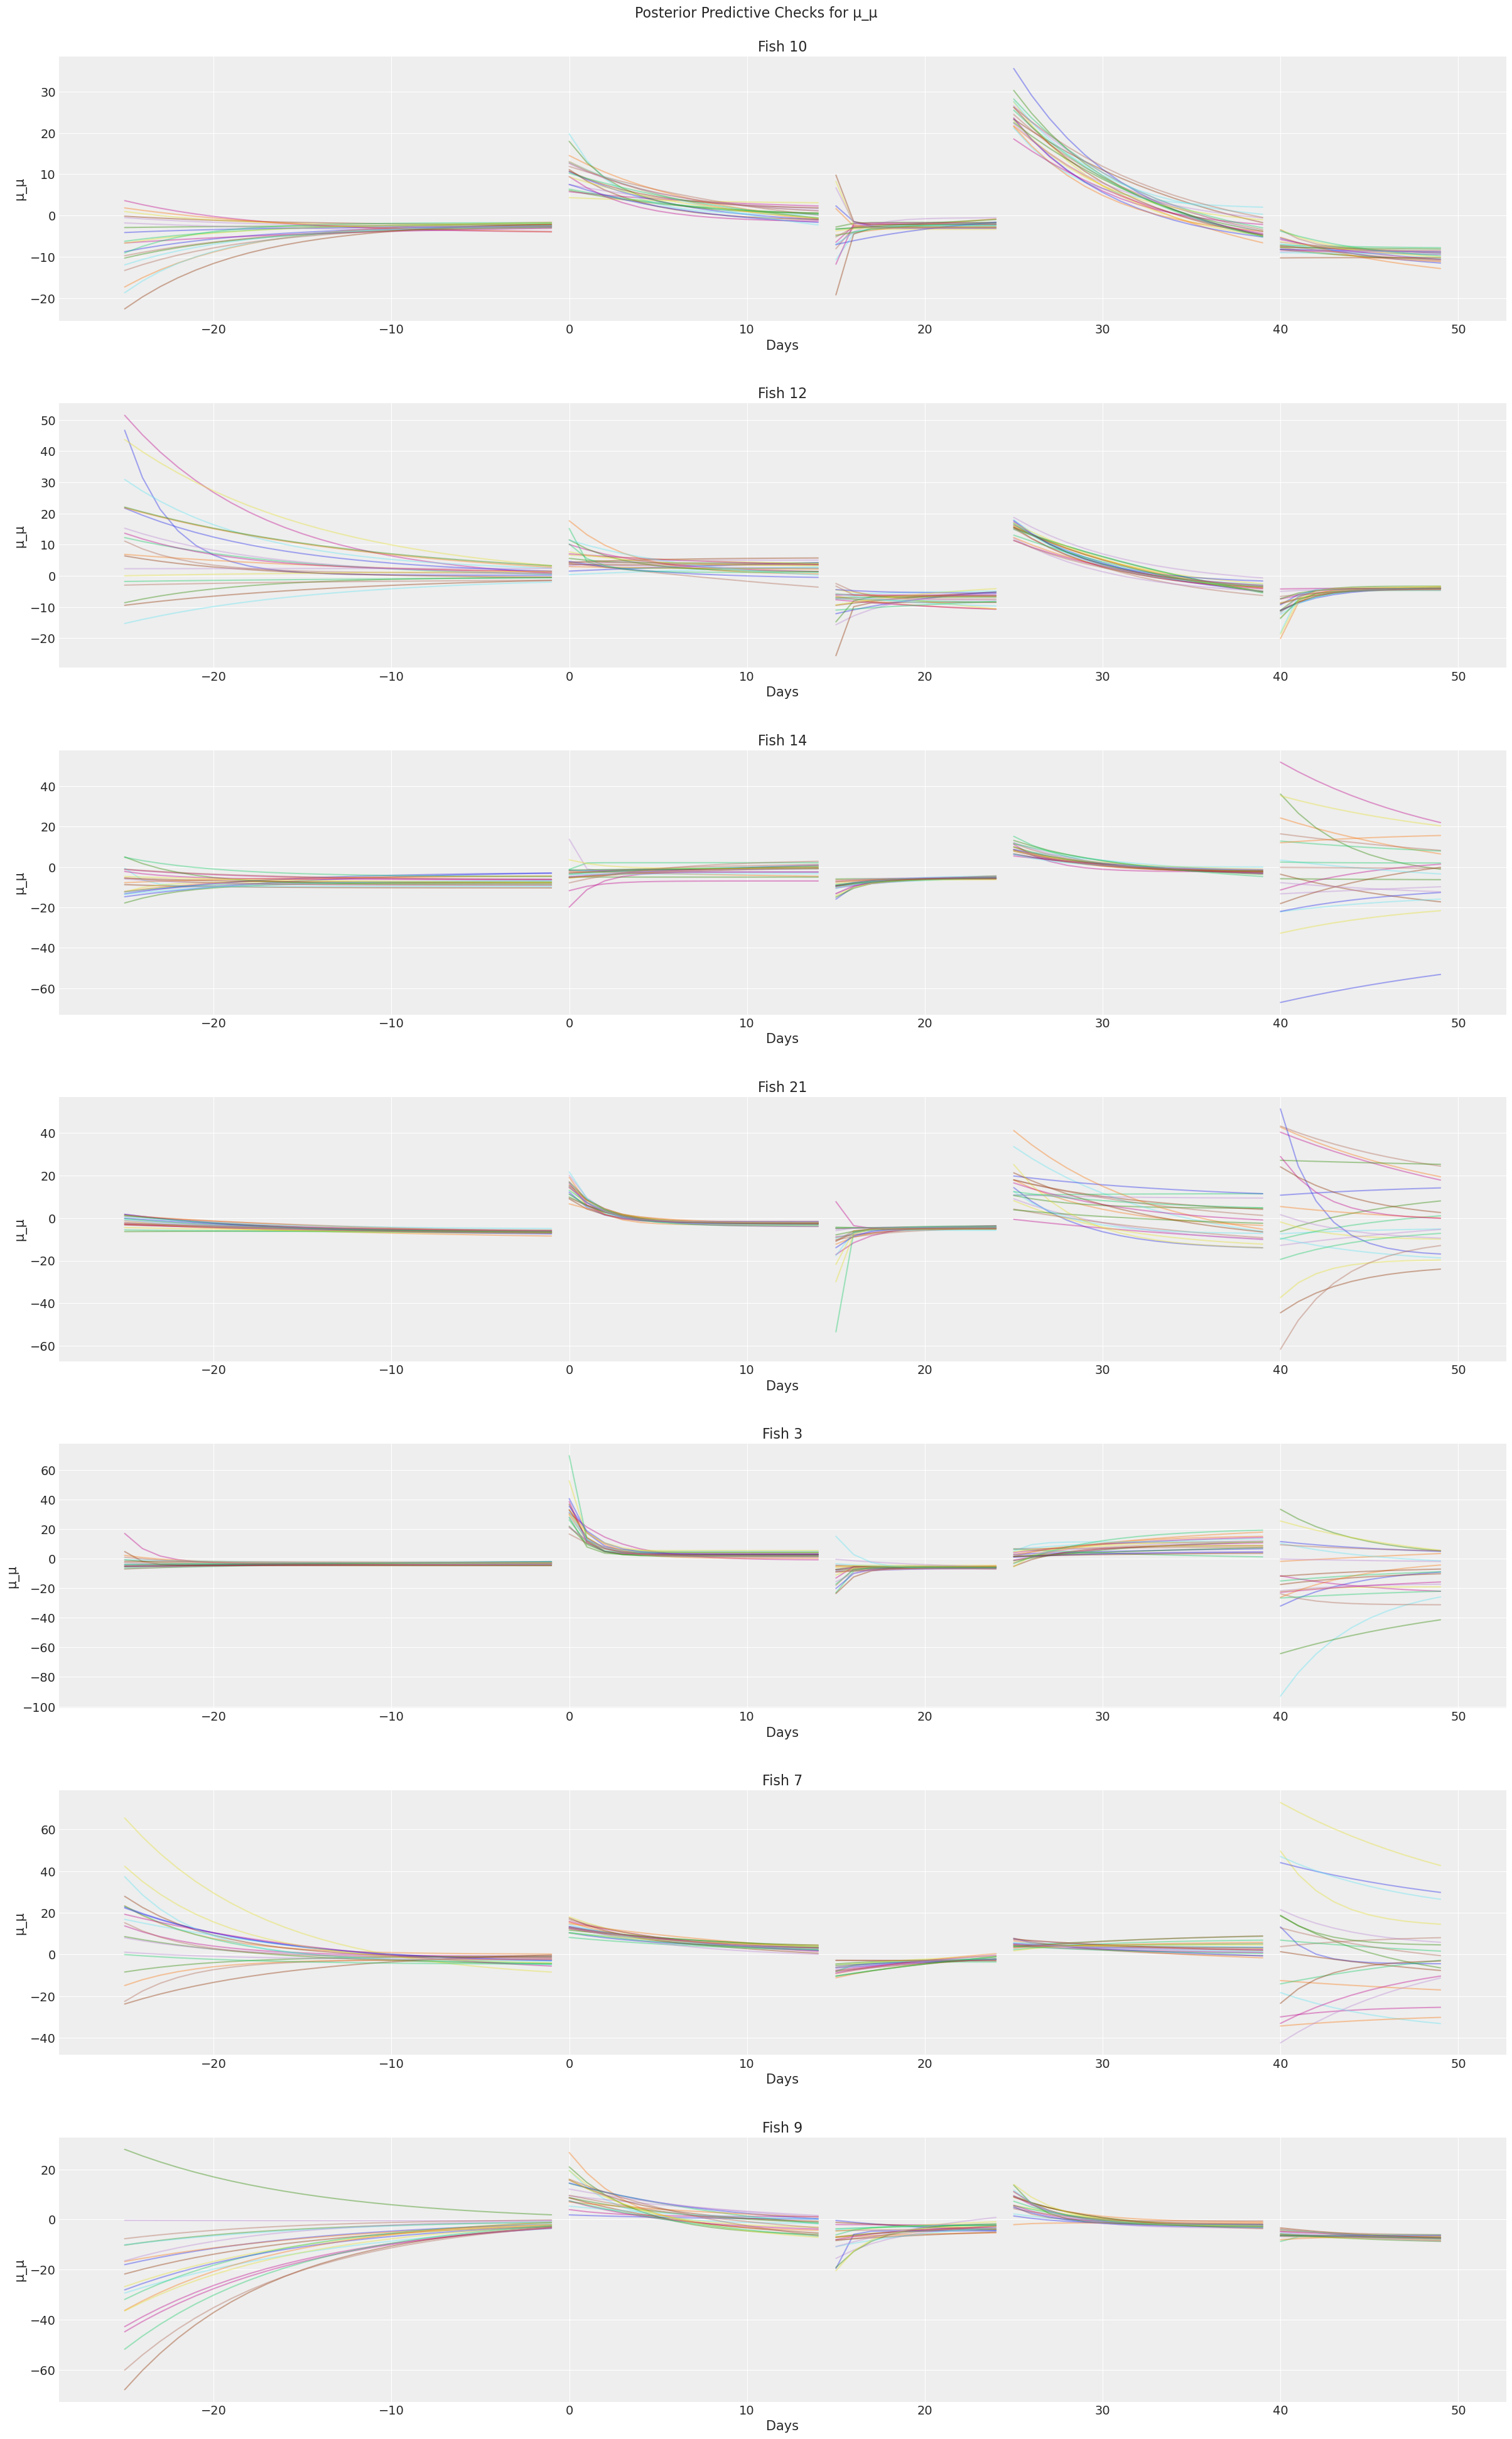

In [29]:
plot_hyperparameter_ppc_course("A_μμ", "τ_μ", "μ_μ_inf", "μ_μ")

C:\Users\86153\AppData\Local\Temp\ipykernel_39092\2590890671.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title


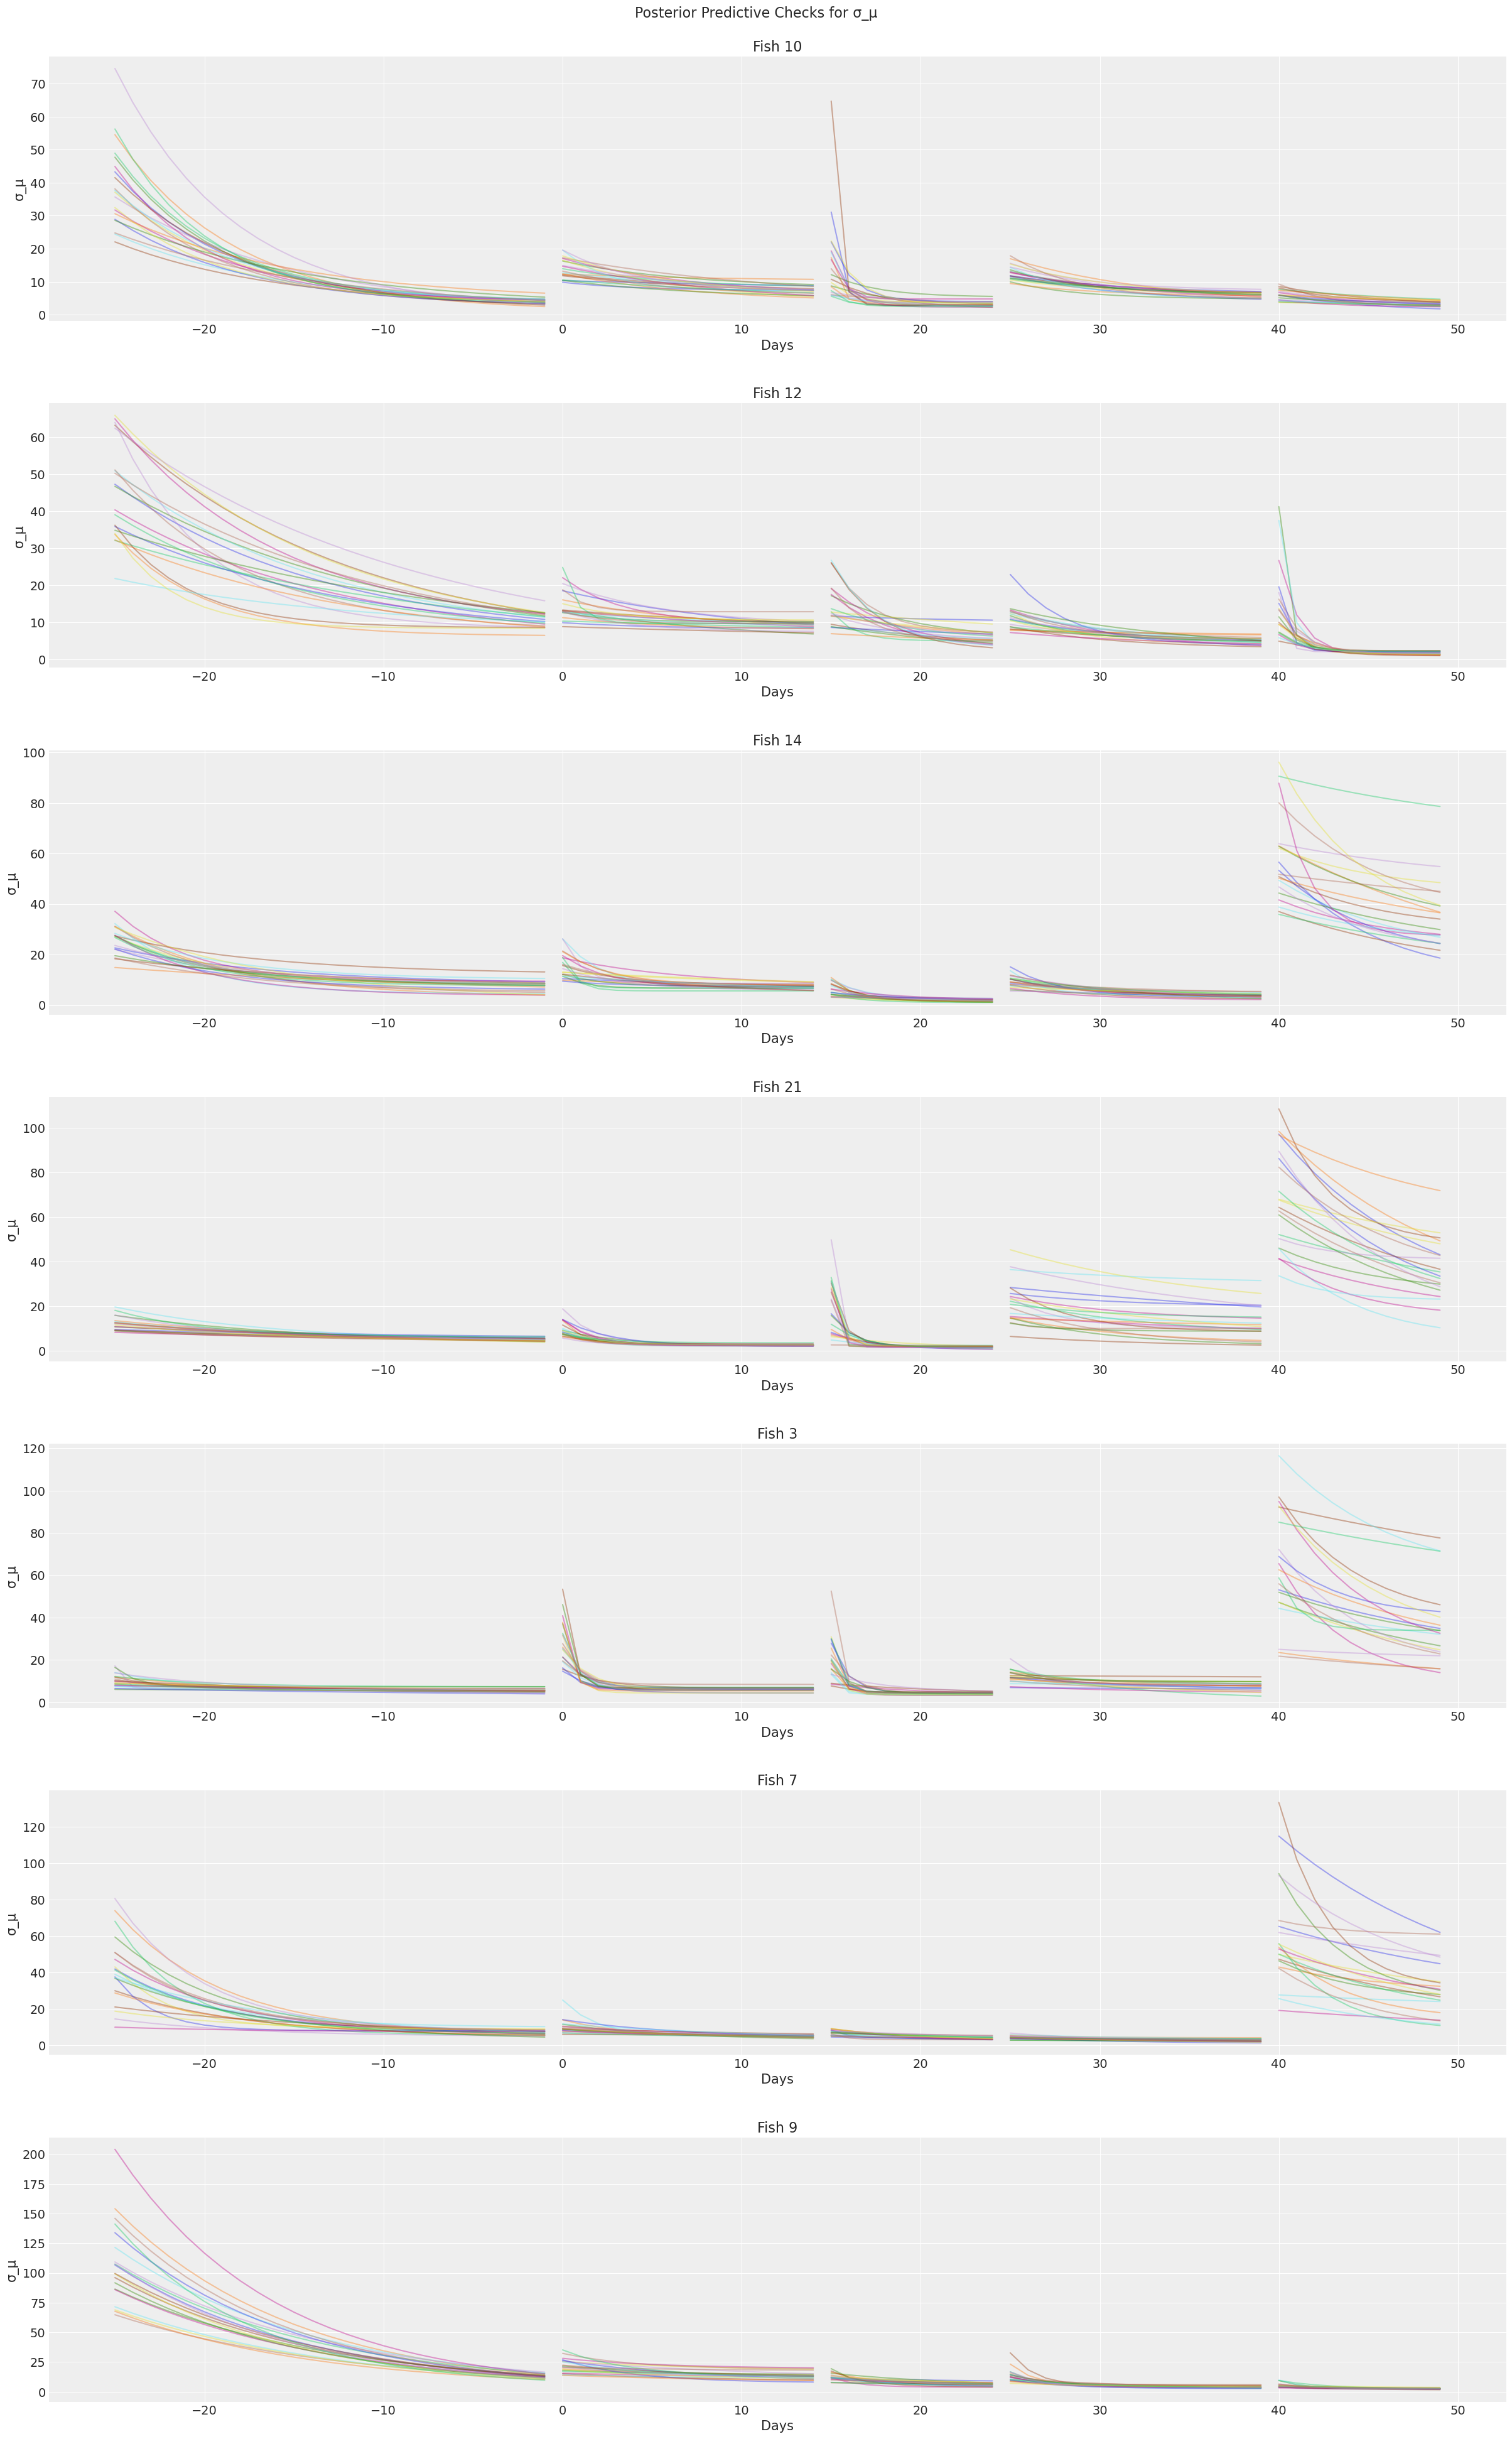

In [30]:
plot_hyperparameter_ppc_course("A_σμ", "τ_μ", "σ_μ_inf", "σ_μ")

In [31]:


# # Define color mapping for trial phases
# phase_colors = {
#     'Baseline': 'yellow',
#     'Rotation': 'red',
#     'Washout': 'green',
#     'ReRotation': 'blue'
# }

# Define the trial phase ranges for each fish
fish_trial_phases = {
    'Fish 10': {
        'Baseline': (1, 149),
        'Rotation': (150, 239),
        'Washout': (240, 299),
        'ReRotation': (300, 388),
        'ReWashout' : (389,448)
    },
    'Fish 12': {
        'Baseline': (449, 597),
        'Rotation': (598, 687),
        'Washout': (688, 747),
        'ReRotation': (748, 837),
        'ReWashout' : (838,897)
    },
    'Fish 14': {
        'Baseline': (898, 998),
        'Rotation': (999, 1089),
        'Washout': (1090, 1148),
        'ReRotation': (1149, 1226)
    },
    'Fish 21': {
        'Baseline': (1227, 1394),
        'Rotation': (1395,1484),
        'Washout': (1485, 1454),
        'ReRotation': (1545, 1550)
    },
    'Fish 3': {
        'Baseline': (1551,1704),
        'Rotation': (1705,1794),
        'Washout': (1795, 1854),
        'ReRotation': (1855, 1902)
    },
    'Fish 7': {
        'Baseline': (1903, 1974),
        'Rotation': (1975, 2064),
        'Washout': (2065, 2124),
        'ReRotation': (2125, 2160)
    },
        'Fish 9': {
        'Baseline': (2161, 2302),
        'Rotation': (2303, 2392),
        'Washout': (2393, 2452),
        'ReRotation': (2453, 2542),
        'ReWashout' : (2543,2602)
    },


}

# # Plotting side-by-side for each fish and trial phase
# fig, axes = plt.subplots(nrows=len(fish_trial_phases), ncols=1, figsize=(12, 8 * len(fish_trial_phases)))

# for i, (fish_name, trial_phases) in enumerate(fish_trial_phases.items()):
#     ax = axes[i]
    
#     for phase_name, (start_idx, end_idx) in trial_phases.items():
#         # Plot posterior predictive data for the current trial phase with the same color
#         draw_idx = 0  # Choose a specific draw index to plot (adjust as needed)
#         num_draws_to_plot = 100
#         for draw_idx in range(num_draws_to_plot):
#             ax.scatter(range(start_idx, end_idx + 1), ppc.y[1, draw_idx, start_idx - 1:end_idx], 
#                 label=f'{fish_name} - {phase_name} Posterior Predictive (Draw {draw_idx + 1})', 
#                 color=phase_colors[phase_name], alpha=0.1)
            
#             ax.scatter(range(start_idx, end_idx + 1), posterior.μ_μ[1, draw_idx, start_idx - 1:end_idx], 
#                 label=f'{fish_name} - {phase_name} Posterior μ_μ (Draw {draw_idx + 1})', 
#                 color=phase_colors[phase_name], alpha=0.5)
#             # Plot observed data for the current trial phase with specified color
#         #ax.plot(range(start_idx, end_idx + 1), obd.y[start_idx - 1:end_idx], 
#               #  label=f'{fish_name} - {phase_name} (Observed)', color=phase_colors[phase_name])
#         ax.scatter(range(start_idx, end_idx + 1), obd.y[start_idx - 1:end_idx], 
#                 label=f'{fish_name} - {phase_name} (Observed)', color = 'black' )
        
#     ax.set_xlabel('Trial')
#     ax.set_ylabel('Yds')
#     ax.set_title(fish_name)
#     # ax.legend()

# plt.tight_layout()
# plt.show()


In [32]:
# Assuming 'posterior.μ_μ' is your xarray DataArray with dimensions [chain, draw, data]
# and that it has 1387 data points (or any other number, but for the sake of divisibility we assume a correct truncation)

# Ensure data points can be grouped into sets of 6
num_trials = posterior.μ_μ.shape[2]
num_days = num_trials // 6  # floor division to ignore any remainder trials that do not complete a day
trials_per_day = 6

# Truncate the last few trials if they don't make up a full day
truncated_data = posterior.μ_μ[:, :, :num_days * 6]

# Assign a new coordinate that groups every 6 trials into one day
truncated_data.coords['day'] = ('data', np.repeat(np.arange(num_days), trials_per_day))

# Group by the new 'day' coordinate and calculate the mean
daily_μ_μ = truncated_data.groupby('day').mean('data')

# daily_μ_μ now has dimensions [chain, draw, day] where 'day' represents the aggregated mean of every 6 trials


In [33]:
def get_fish_and_stage(day_index, fish_trial_phases, trials_per_day=6):
    # Convert day index to 1-based trial index
    trial_index = day_index * trials_per_day + 1
    
    # Iterate through each fish and their phases to find where the trial_index falls
    for fish, phases in fish_trial_phases.items():
        for stage, (start, end) in phases.items():
            if start <= trial_index <= end:
                return fish, stage
    
    return None, None  # Return None if no matching fish or stage is found


In [34]:
# Determine the number of days (based on the 'day' dimension)
num_days = daily_μ_μ.sizes['day']

# Create lists to hold the 'fish' and 'stage' labels for each day
fish_labels = []
stage_labels = []

# Loop over each day index to determine the corresponding fish and stage
for day_index in range(num_days):
    # Get the full fish name and stage name for the current day index
    fish, stage = get_fish_and_stage(day_index, fish_trial_phases)
    
    # Append the full fish and stage names to the labels lists
    fish_labels.append(fish)
    stage_labels.append(stage)

# Convert the lists to numpy arrays
fish_labels = np.array(fish_labels)
stage_labels = np.array(stage_labels)

# Add 'fish' and 'stage' as coordinates to the 'day' dimension
daily_μ_μ.coords['fish'] = ('day', fish_labels)
daily_μ_μ.coords['stage'] = ('day', stage_labels)

# Now 'daily_μ_μ' has additional coordinates 'fish' and 'stage' associated with each day

In [35]:
μ_μ_plot = az.summary(posterior, var_names=['μ_μ'], hdi_prob=0.94)  # Adjust hdi_prob as needed (e.g., 0.95 for 94% HDI)

In [36]:
y_ppc_plot = az.summary(ppc, var_names=['y'], hdi_prob=0.94)

In [37]:
y_obd_plot = obd.y.to_dataframe(name="y")

In [38]:
μ_plot = az.summary(posterior, var_names=['μ_μ'], hdi_prob=0.94)


In [39]:

# # Define fish_trial_phases dictionary
# fish_trial_phases = {
#     '10': {
#         'Baseline': (1, 149),
#         'Rotation': (150, 239),
#         'Washout': (240, 299),
#         'ReRotation': (300, 388),
#         'ReWashout' : (389,448)
#     },
#     '12': {
#         'Baseline': (449, 597),
#         'Rotation': (598, 687),
#         'Washout': (688, 747),
#         'ReRotation': (748, 837),
#         'ReWashout' : (838,897)
#     },
#     '14': {
#         'Baseline': (898, 998),
#         'Rotation': (999, 1089),
#         'Washout': (1090, 1148),
#         'ReRotation': (1149, 1226)
#     },
#     '21': {
#         'Baseline': (1227, 1394),
#         'Rotation': (1395,1484),
#         'Washout': (1485, 1454),
#         'ReRotation': (1545, 1550)
#     },
#     '3': {
#         'Baseline': (1551,1704),
#         'Rotation': (1705,1794),
#         'Washout': (1795, 1854),
#         'ReRotation': (1855, 1902)
#     },
#     '7': {
#         'Baseline': (1903, 1974),
#         'Rotation': (1975, 2064),
#         'Washout': (2065, 2124),
#         'ReRotation': (2125, 2160)
#     },
#     '9': {
#         'Baseline': (2161, 2302),
#         'Rotation': (2303, 2392),
#         'Washout': (2393, 2452),
#         'ReRotation': (2453, 2542),
#         'ReWashout' : (2543,2602)
#     },


# }

# Define fish_trial_phases dictionary
fish_trial_phases = {
    '10': {
        'Baseline': (0, 148),
        'Rotation': (149, 238),
        'Washout': (239, 298),
        'ReRotation': (299, 387),
        'ReWashout' : (388,447)
    },
    '12': {
        'Baseline': (448, 596),
        'Rotation': (597, 686),
        'Washout': (687, 746),
        'ReRotation': (747, 836),
        'ReWashout' : (837,896)
    },
    '14': {
        'Baseline': (897, 997),
        'Rotation': (998, 1088),
        'Washout': (1089, 1147),
        'ReRotation': (1148, 1225)
    },
    '21': {
        'Baseline': (1226, 1393),
        'Rotation': (1394,1483),
        'Washout': (1484, 1543),
        'ReRotation': (1544, 1549)
    },
    '3': {
        'Baseline': (1550,1703),
        'Rotation': (1704,1793),
        'Washout': (1794, 1853),
        'ReRotation': (1854, 1901)
    },
    '7': {
        'Baseline': (1902, 1973),
        'Rotation': (1974, 2063),
        'Washout': (2064, 2123),
        'ReRotation': (2124, 2159)
    },
    '9': {
        'Baseline': (2160, 2301),
        'Rotation': (2302, 2391),
        'Washout': (2392, 2451),
        'ReRotation': (2452, 2541),
        'ReWashout' : (2542,2601)
    },


}

# Function to determine trial phase based on row index
def get_trial_phase(index):
    for fish, phases in fish_trial_phases.items():
        for phase, (start, end) in phases.items():
            if start <= index <= end:
                return fish, phase, index - start + 1
    # Return default values (e.g., NaN) if no trial phase is found
    return None, None, None

# Apply function to create new columns 'fish', 'stage', 'day'
y_obd_plot['index'] = y_obd_plot.index  # Create a new column 'index' to work with the index
y_obd_plot['fish'], y_obd_plot['stage'], y_obd_plot['day'] = zip(*y_obd_plot['index'].map(get_trial_phase))

# Drop the 'index' column (optional)
y_obd_plot.drop(columns=['index'], inplace=True)




In [40]:
# Map day values such that each 6-day cycle is treated as 1 day
y_obd_plot['day'] = np.ceil(y_obd_plot['day'] / 6)

In [41]:


y_obd_plot['fish'] = pd.to_numeric(y_obd_plot['fish'], errors='coerce')
y_obd_plot['day'] = pd.to_numeric(y_obd_plot['day'], errors='coerce')

# Initialize plotday column with NaN
y_obd_plot['plotday'] = None
# Drop the 'index' column (optional)
# Iterate through each row to calculate plotday based on 'fish' and 'day'
current_fish = None
current_day = None
current_plotday = 0

for index, row in y_obd_plot.iterrows():
    if row['fish'] != current_fish:
        # New fish encountered, reset plotday to 1
        current_fish = row['fish']
        current_day = row['day']
        current_plotday = 1
    elif row['day'] != current_day:
        # Same fish but different day, increment plotday
        current_day = row['day']
        current_plotday += 1
    
    # Update plotday for the current row
    y_obd_plot.at[index, 'plotday'] = current_plotday

# Convert plotday column to numeric
y_obd_plot['plotday'] = pd.to_numeric(y_obd_plot['plotday'], errors='coerce')





## Rename columns from suammary 

In [42]:
# Rename columns in each DataFrame
μ_μ_plot_renamed = μ_μ_plot.rename(columns={'mean': 'μ_μ_y', 'hdi_3%': 'μ_μ_hdi_3%','hdi_97%': 'μ_μ_hdi_97%'})
μ_plot_renamed = μ_plot.rename(columns={'mean': 'μ_y', 'hdi_3%': 'μ_hdi_3%','hdi_97%': 'μ_hdi_97%'})
y_ppc_plot_renamed = y_ppc_plot.rename(columns={'mean': 'ppc_y', 'hdi_3%': 'ppc_hdi_3%','hdi_97%': 'ppc_hdi_97%'})

In [43]:
μ_μ_plot_renamed = μ_μ_plot_renamed.reset_index(drop=True) 
μ_plot_renamed = μ_plot_renamed.reset_index(drop=True) 
y_ppc_plot_renamed = y_ppc_plot_renamed.reset_index(drop=True) 

In [44]:
ppcplot_df = pd.concat([y_obd_plot, μ_μ_plot_renamed[['μ_μ_y','μ_μ_hdi_3%','μ_μ_hdi_97%']],μ_plot_renamed[['μ_y','μ_hdi_3%','μ_hdi_97%']], y_ppc_plot_renamed[['ppc_y','ppc_hdi_3%','ppc_hdi_97%']]], axis=1)

In [45]:

ppcplot_df['fish'] = pd.to_numeric(y_obd_plot['fish'], errors='coerce')
ppcplot_df['day'] = pd.to_numeric(y_obd_plot['day'], errors='coerce')

In [46]:
ppcplot_df

y  fish      stage   day  plotday  μ_μ_y  μ_μ_hdi_3%  \
0      -2.765431    10   Baseline   1.0        1 -6.450     -18.608   
1     110.197334    10   Baseline   1.0        1 -6.450     -18.608   
2      -5.197915    10   Baseline   1.0        1 -6.450     -18.608   
3      -4.254510    10   Baseline   1.0        1 -6.450     -18.608   
4    -114.945924    10   Baseline   1.0        1 -6.450     -18.608   
...          ...   ...        ...   ...      ...    ...         ...   
2597   -7.843720     9  ReWashout  10.0       74 -6.854      -8.526   
2598  -86.758657     9  ReWashout  10.0       74 -6.854      -8.526   
2599   -9.016463     9  ReWashout  10.0       74 -6.854      -8.526   
2600   -2.996962     9  ReWashout  10.0       74 -6.854      -8.526   
2601   -8.041311     9  ReWashout  10.0       74 -6.854      -8.526   

      μ_μ_hdi_97%    μ_y  μ_hdi_3%  μ_hdi_97%   ppc_y  ppc_hdi_3%  ppc_hdi_97%  
0           6.537 -6.450   -18.608      6.537  13.466    -316.411      332.894  
1           6.537 -6.450   -18.608      6.537  -1.786    -336.588      321.170  
2           6.537 -6.450   -18.608      6.537 -12.213    -290.106      350.356  
3           6.537 -6.450   -18.608      6.537  -9.495    -352.040      297.315  
4           6.537 -6.450   -18.608      6.537  52.093    -300.624      277.650  
...           ...    ...       ...        ...     ...         ...          ...  
2597       -5.186 -6.854    -8.526     -5.186  -6.520     -28.329       12.829  
2598       -5.186 -6.854    -8.526     -5.186 -95.030     -28.411       12.185  
2599       -5.186 -6.854    -8.526     -5.186  -5.628     -27.652       11.861  
2600       -5.186 -6.854    -8.526     -5.186  -5.803     -27.585       11.769  
2601       -5.186 -6.854    -8.526     -5.186  -7.195     -26.739       13.892  

[2602 rows x 14 columns]

In [47]:
# Define a list of stages in the correct order
stages_All = ['Baseline', 'Rotation', 'Washout', 'ReRotation','ReWashout']
stages = ['Baseline', 'Rotation', 'Washout', 'ReRotation','ReWashout']
stages_BWR= ['Baseline', 'Rotation', 'Washout']
stages_RReR= ['Rotation', 'ReRotation']
stages_ReRReW= [ 'ReRotation', 'ReWashout']
stages_RW = ['Rotation', 'Washout']


# Define color mapping for trial phases
phase_colors = {
    'Baseline': '#F0E442',  # Yellow
    'Rotation': '#CC79A7',   # Reddish Purple
    'Washout': '#F0E442',  # Yellow
    'ReRotation': '#56B4E9',  # Sky Blue
    'ReWashout':   '#E69F00',  # Orange
}
phase_colors_BWR = {
    'Baseline': '#F0E442',  # Yellow
    'Rotation': '#CC79A7',   # Reddish Purple
    'Washout': '#F0E442',  # Yellow
}




# Convert 'stage' column to categorical type with specified order
ppcplot_df['stage'] = pd.Categorical(ppcplot_df['stage'], categories=stages, ordered=True)

# Group by 'fish', 'stage', and 'day' columns, calculate mean of 'y' for each group
ppcplot_df_day = ppcplot_df.groupby(['fish', 'stage', 'day']).agg(
    mean_y=('y', 'mean'),
    median_y=('y', 'median'),
    mean_μ_μ_y=('μ_μ_y', 'mean'),
    median_μ_μ_y=('μ_μ_y', 'median'),
    mean_μ_μ_hdi_3=('μ_μ_hdi_3%', 'mean'),
    median_μ_μ_hdi_3=('μ_μ_hdi_3%', 'median'),
    mean_μ_μ_hdi_97=('μ_μ_hdi_97%', 'mean'),
    median_μ_μ_hdi_97=('μ_μ_hdi_97%', 'median'),
    mean_μ_y=('μ_y', 'mean'),
    median_μ_y=('μ_y', 'median'),
    mean_μ_hdi_3=('μ_hdi_3%', 'mean'),
    median_μ_hdi_3=('μ_hdi_3%', 'median'),
    mean_μ_hdi_97=('μ_hdi_97%', 'mean'),
    median_μ_hdi_97=('μ_hdi_97%', 'median'),
    mean_ppc_y=('ppc_y', 'mean'),
    median_ppc_y=('ppc_y', 'median'),
    mean_ppc_hdi_3=('ppc_hdi_3%', 'mean'),
    median_ppc_hdi_3=('ppc_hdi_3%', 'median'),
    mean_ppc_hdi_97=('ppc_hdi_97%', 'mean'),
    median_ppc_hdi_97=('ppc_hdi_97%', 'median')
).reset_index()

# Define conditions to set 'plotday' to NaN where 'mean_y' is NaN
condition = pd.isna(ppcplot_df_day['mean_y'])

# Set 'plotday' to NaN where 'mean_y' is NaN
ppcplot_df_day.loc[condition, 'plotday'] = None

# Calculate 'plotday' based on change in 'day' within the same 'fish' group where 'mean_y' is not NaN
ppcplot_df_day.loc[~condition, 'plotday'] = (
    ppcplot_df_day.loc[~condition].groupby('fish').cumcount()
    + (ppcplot_df_day.loc[~condition, 'day'] != ppcplot_df_day.loc[~condition, 'day'].shift()).astype(int)
)
ppcplot_df_day = ppcplot_df_day[pd.notna(ppcplot_df_day['mean_y'])]
ppcplot_df_day['plotday'] = pd.to_numeric(ppcplot_df_day['plotday'], errors='coerce')



C:\Users\86153\AppData\Local\Temp\ipykernel_39092\2575291372.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ppcplot_df_day = ppcplot_df.groupby(['fish', 'stage', 'day']).agg(


In [48]:

# Save the DataFrame to CSV file
ppcplot_df_day.to_csv('ppcplot.csv', index=False)

In [49]:
y_obd_plot.to_csv('y_obdplot.csv', index=False)

# Plots

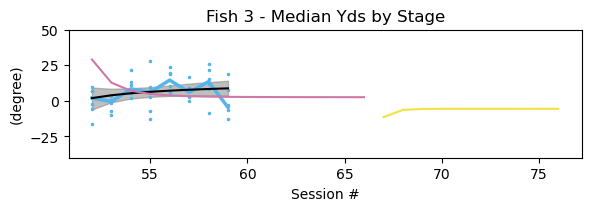

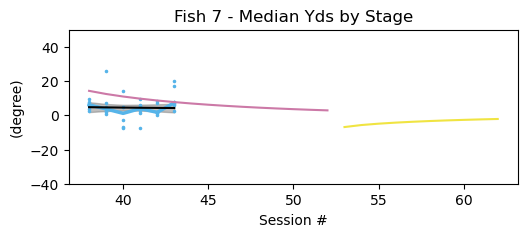

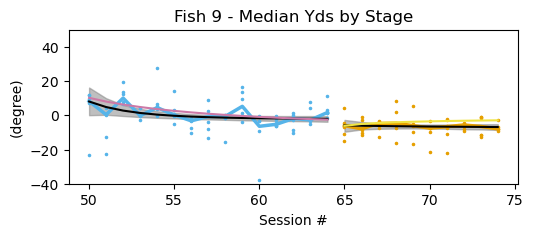

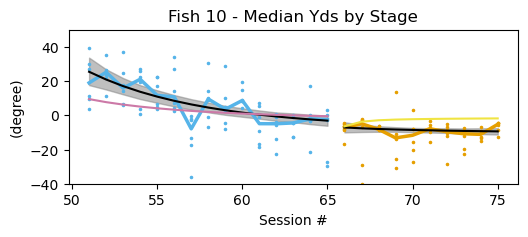

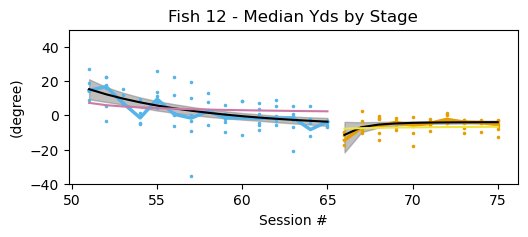

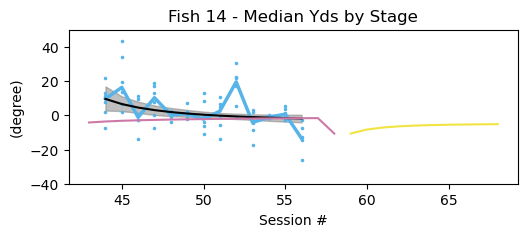

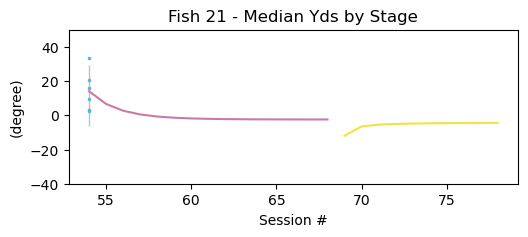

In [50]:

# Iterate over each unique combination of fish and stage to create plots
for fish in ppcplot_df_day['fish'].unique():
    plt.figure(figsize=(5.8, 2))  # Set figure size
    plt.style.use('default')
    for i, stage in enumerate(stages_ReRReW):
# Filter data for the current fish and stage
        data_filter = ppcplot_df_day[(ppcplot_df_day['fish'] == fish) & (ppcplot_df_day['stage'] == stage)]
        data_filter2 = y_obd_plot[(y_obd_plot['fish'] == fish) & (y_obd_plot['stage'] == stage)]

        # Plot mean_y against plotday for the current stage
        plt.plot(data_filter['plotday'], data_filter['median_y'], label=f'Median Y - {stage}', color=phase_colors[stage], linewidth=2.5)
        plt.plot(data_filter['plotday'], data_filter['median_μ_μ_y'], label=f'Median μ_μ_y - {stage}',color='black')
       # plt.plot(data_filter['plotday'], data_filter['median_y'], label=f'Median Y - {stage}', color='black')
                 # Plot mean_y against plotday for the current stage
        # plt.plot(data_filter['plotday'], data_filter['mean_μ_μ_hdi_3'] ,label=f'mean_μ_μ_hdi_3 - {stage}', color=phase_colors[stage], alpha=0.5,)
        # plt.plot(data_filter['plotday'], data_filter['mean_μ_μ_hdi_97'] ,label=f'mean_μ_μ_hdi_97 - {stage}', color=phase_colors[stage], alpha=0.5,)
        
    #    plt.fill_between(data_filter['plotday'], data_filter['mean_μ_hdi_3'], data_filter['mean_μ_hdi_97'],color=phase_colors[stage], alpha=0.5, label=f'HDI μ - {stage}')
         # Plot HDI (mean_μ_μ_hdi_3% to mean_μ_μ_hdi_97%) as shaded region
        plt.fill_between(data_filter['plotday'], data_filter['median_μ_μ_hdi_3'], data_filter['median_μ_μ_hdi_97'],color='grey', alpha=0.5, label=f'HDI μ_μ - {stage}')
        # plt.plot(data_filter['plotday'], data_filter['mean_ppc_hdi_3'] ,label=f'mean_ppc_hdi_3 - {stage}', color=phase_colors[stage], alpha=0.3,)
        # plt.plot(data_filter['plotday'], data_filter['mean_ppc_hdi_97'] ,label=f'mean_ppc_hdi_97 - {stage}', color=phase_colors[stage], alpha=0.3,)    

            # Plot PPC HDI (mean_ppc_hdi_3% to mean_ppc_hdi_97%) as shaded region
        # plt.fill_between(data_filter['plotday'], data_filter['mean_ppc_hdi_3'], data_filter['mean_ppc_hdi_97'],
        #                     color=phase_colors[stage], alpha=0.1, label=f'HDI PPC - {stage}')
        plt.scatter(data_filter2['plotday'],data_filter2['y'],color=phase_colors[stage],s =2.4)
    for i, stage in enumerate(stages_RW):
        data_filter3 = ppcplot_df_day[(ppcplot_df_day['fish'] == fish) & (ppcplot_df_day['stage'] == stage)]
        plt.plot(data_filter3['plotday']+25, data_filter3['median_μ_μ_y'], label=f'Median μ_μ_y - {stage}',color=phase_colors[stage])
    plt.xlabel('Session #')  # Set x-axis label
    plt.ylabel('(degree)')   # Set y-axis label
    plt.title(f'Fish {fish} - Median Yds by Stage')  # Set plot title
    # plt.legend( bbox_to_anchor=(1, 1))
       # Set fixed data ranges for both axes
    plt.ylim((-40,50))
    plt.grid(False)  # Show grid
    Exampelplotfolder = os.path.join(plotfolder,'example/')
    plt.savefig(os.path.join(Exampelplotfolder, f'{fish}Figure5C.png'), bbox_inches='tight', dpi=600)

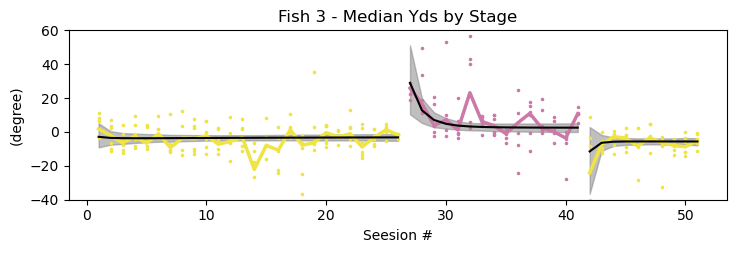

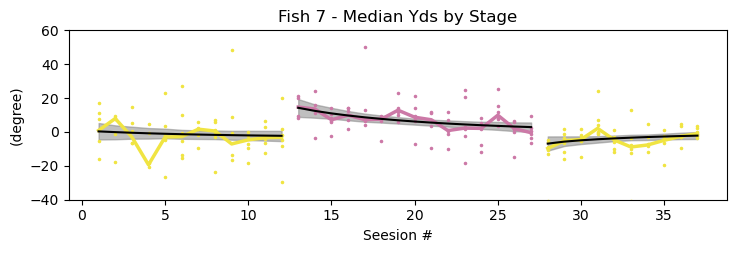

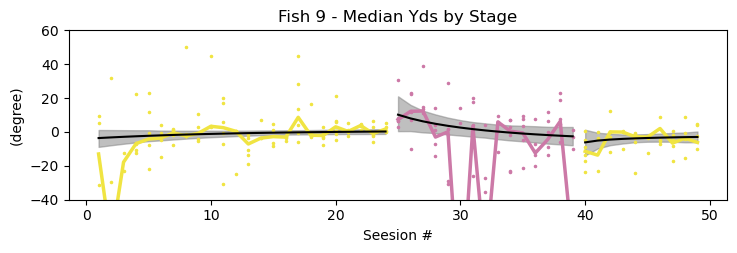

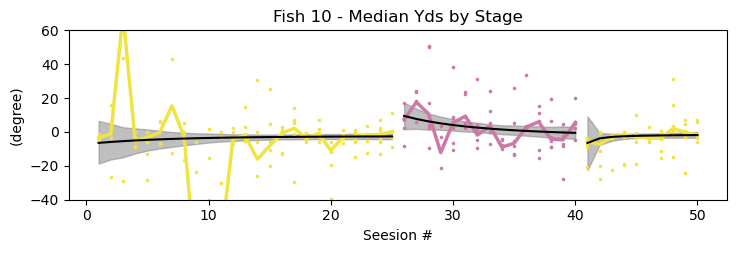

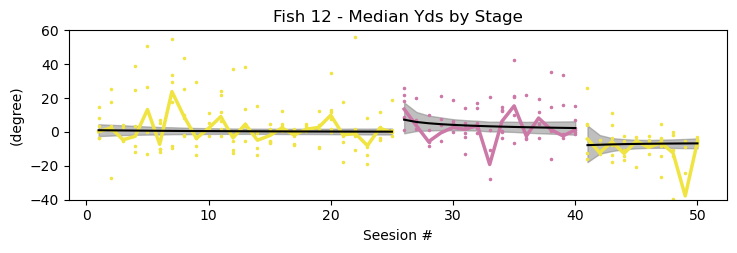

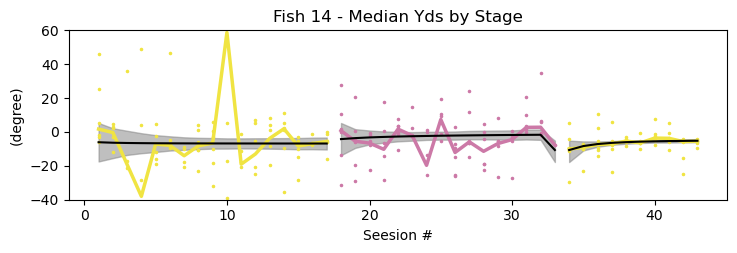

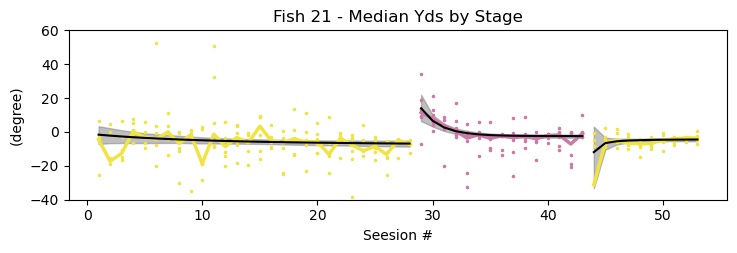

In [51]:
# Iterate over each unique combination of fish and stage to create plots
for fish in ppcplot_df_day['fish'].unique():
    plt.figure(figsize=(8.5, 2.2))  # Set figure size
    plt.style.use('default')
    for i, stage in enumerate(stages_BWR):
# Filter data for the current fish and stage
        data_filter = ppcplot_df_day[(ppcplot_df_day['fish'] == fish) & (ppcplot_df_day['stage'] == stage)]
        data_filter2 = y_obd_plot[(y_obd_plot['fish'] == fish) & (y_obd_plot['stage'] == stage)]
        # Plot mean_y against plotday for the current stage
        plt.plot(data_filter['plotday'], data_filter['median_y'], label=f'Median Y - {stage}', color=phase_colors[stage], linewidth=2.5)
        plt.plot(data_filter['plotday'], data_filter['median_μ_μ_y'], label=f'Median μ_μ_y - {stage}',color='black')
       # plt.plot(data_filter['plotday'], data_filter['median_y'], label=f'Median Y - {stage}', color='black')
                 # Plot mean_y against plotday for the current stage
        # plt.plot(data_filter['plotday'], data_filter['mean_μ_μ_hdi_3'] ,label=f'mean_μ_μ_hdi_3 - {stage}', color=phase_colors[stage], alpha=0.5,)
        # plt.plot(data_filter['plotday'], data_filter['mean_μ_μ_hdi_97'] ,label=f'mean_μ_μ_hdi_97 - {stage}', color=phase_colors[stage], alpha=0.5,)
        
    #    plt.fill_between(data_filter['plotday'], data_filter['mean_μ_hdi_3'], data_filter['mean_μ_hdi_97'],color=phase_colors[stage], alpha=0.5, label=f'HDI μ - {stage}')
         # Plot HDI (mean_μ_μ_hdi_3% to mean_μ_μ_hdi_97%) as shaded region
        plt.fill_between(data_filter['plotday'], data_filter['median_μ_μ_hdi_3'], data_filter['median_μ_μ_hdi_97'],color='grey', alpha=0.5, label=f'HDI μ_μ - {stage}')
        # plt.plot(data_filter['plotday'], data_filter['mean_ppc_hdi_3'] ,label=f'mean_ppc_hdi_3 - {stage}', color=phase_colors[stage], alpha=0.3,)
        # plt.plot(data_filter['plotday'], data_filter['mean_ppc_hdi_97'] ,label=f'mean_ppc_hdi_97 - {stage}', color=phase_colors[stage], alpha=0.3,)    

            # Plot PPC HDI (mean_ppc_hdi_3% to mean_ppc_hdi_97%) as shaded region
        # plt.fill_between(data_filter['plotday'], data_filter['mean_ppc_hdi_3'], data_filter['mean_ppc_hdi_97'],
        #                     color=phase_colors[stage], alpha=0.1, label=f'HDI PPC - {stage}')
        plt.scatter(data_filter2['plotday'],data_filter2['y'],color=phase_colors[stage],s =2.4)
    
    plt.xlabel('Seesion #')  # Set x-axis label
    plt.ylabel('(degree)')   # Set y-axis label
    plt.title(f'Fish {fish} - Median Yds by Stage')  # Set plot title
    # plt.legend( bbox_to_anchor=(1, 1))
       # Set fixed data ranges for both axes
    plt.ylim((-40,60))
    plt.grid(False)  # Show grid

    Exampelplotfolder = os.path.join(plotfolder,'example/')
    plt.savefig(os.path.join(Exampelplotfolder, f'{fish}Figure3D.png'), bbox_inches='tight', dpi=600)

In [52]:
dfr = posterior.sel({'stages':'Rotation' })

In [53]:
μ_A_μμ_acrossR = dfr.A_μμ.mean(dim='fish')

c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.05, 'μ_Aμμ across Rotaion fish')

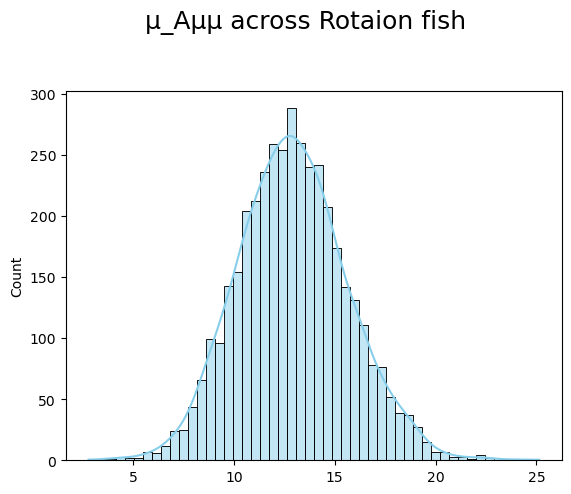

In [54]:
# Flatten the data array to a 1-dimensional numpy array
μ_Aμμ_Rdata = μ_A_μμ_acrossR.values.flatten()
sns.histplot(μ_Aμμ_Rdata, bins=50, kde=True, color='skyblue')
plt.suptitle('μ_Aμμ across Rotaion fish', fontsize=18, y=1.05)  # Adjust fontsize and y position as needed

In [55]:
dfrr = posterior.sel({'stages':'ReRotation' })
μ_A_μμ_acrossReR = dfrr.A_μμ.mean(dim='fish')

c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.05, 'μ_Aμμ across ReRotaion fish')

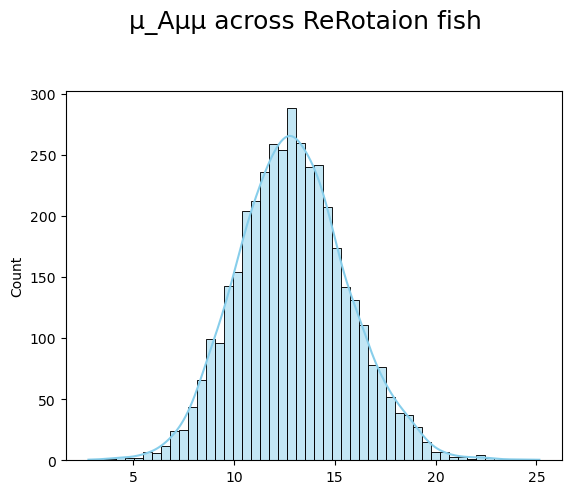

In [56]:
# Flatten the data array to a 1-dimensional numpy array
μ_Aμμ_ReRdata = μ_A_μμ_acrossReR.values.flatten()
sns.histplot(μ_Aμμ_Rdata, bins=50, kde=True, color='skyblue')
plt.suptitle('μ_Aμμ across ReRotaion fish', fontsize=18, y=1.05)  # Adjust fontsize and y position as needed

In [57]:
# LR = posterior.A_μμ * posterior.τ_μ

# dfrr = LR.sel({'stages':'ReRotation' })
# # Plot violin plot for selected variables
# az.plot_violin(data=dfrr)
# # Set a larger title for the plot
# # Set a larger title above the plot
# plt.suptitle('Learning Rate', fontsize=16, y=1.05)  # Adjust fontsize and y position as needed



In [58]:
#az.plot_trace(posterior, var_names=['μ_Aμμ '], coords={'stages': 'Rotation'});

In [59]:

# #az.plot_trace(LR, coords={'stages': 'Rotation'});
# az.plot_posterior(LR, coords={'stages': 'Rotation'})
# # Set a larger title above the plot
# plt.suptitle('Learning Rate of Rotation', fontsize=28, y=1.05)  # Adjust fontsize and y position as needed


In [60]:
# LR_R = LR.sel({'stages':'Rotation' })

In [61]:
# # Flatten the data array to a 1-dimensional numpy array
# flattened_data = LR_R.values.flatten()
# sns.histplot(flattened_data, bins=50, kde=True, color='skyblue')
# plt.suptitle('Learning rates across Rotation fish', fontsize=18, y=1.05)  # Adjust fontsize and y position as needed

In [62]:
# LR_ReR = LR.sel({'stages':'ReRotation' })
# # Flatten the data array to a 1-dimensional numpy array
# flattened_data = LR_ReR.values.flatten()
# sns.histplot(flattened_data, bins=50, kde=True, color='skyblue')
# plt.suptitle('Learning rates across ReRotation fish', fontsize=18, y=1.05)  # Adjust fontsize and y position as needed

## Plots in ppt

In [63]:
σ_μ_inf_B = az.summary(id_yds_numpyro, var_names=['σ_μ_inf'], coords={'stages': ['Baseline']})

In [64]:
σ_μ_inf_W = az.summary(id_yds_numpyro, var_names=['σ_μ_inf'], coords={'stages': ['Washout']})

In [65]:
A_μμ_R = az.summary(id_yds_numpyro, var_names=['A_μμ'], coords={'stages': ['Rotation']})

In [66]:
A_μμ_ReR = az.summary(id_yds_numpyro, var_names=['A_μμ'], coords={'stages': ['ReRotation']})

In [67]:
τ_μ_ReR = az.summary(id_yds_numpyro, var_names=['τ_μ'], coords={'stages': ['ReRotation']})

In [68]:
τ_μ_R = az.summary(id_yds_numpyro, var_names=['τ_μ'], coords={'stages': ['Rotation']})

In [69]:
μ_μ_inf_R = az.summary(id_yds_numpyro, var_names=['μ_μ_inf'], coords={'stages': ['Rotation']})

In [70]:
μ_μ_inf_ReR = az.summary(id_yds_numpyro, var_names=['μ_μ_inf'], coords={'stages': ['ReRotation']})

In [71]:
τ_μ_ReR = τ_μ_ReR.rename(columns={'sd': 'τ_μ_ReR_sd', 'mean': 'τ_μ_ReR_mean'})
τ_μ_R = τ_μ_R.rename(columns={'sd': 'τ_μ_R_sd', 'mean': 'τ_μ_R_mean'})
μ_μ_inf_R = μ_μ_inf_R.rename(columns={'sd': 'μ_μ_inf_R_sd', 'mean': 'μ_μ_inf_R_mean'})
μ_μ_inf_ReR = μ_μ_inf_ReR.rename(columns={'sd': 'μ_μ_inf_ReR_sd', 'mean': 'μ_μ_inf_ReR_mean'})

In [72]:
σ_μ_inf_B_sd = σ_μ_inf_B.rename(columns={'sd': 'σ_μ_inf_B_sd', 'mean': 'σ_μ_inf_B_mean'})

In [73]:
σ_μ_inf_W_sd = σ_μ_inf_W.rename(columns={'sd': 'σ_μ_inf_W_sd', 'mean': 'σ_μ_inf_W_mean'})

In [74]:
A_μμ_R_mean = A_μμ_R.rename(columns={'sd': 'A_μμ_R_sd', 'mean': 'A_μμ_R_mean'})

In [75]:
A_μμ_ReR_mean = A_μμ_ReR.rename(columns={'sd': 'A_μμ_ReR_sd', 'mean': 'A_μμ_ReR_mean'})

In [76]:
σ_μ_inf_B_sd = σ_μ_inf_B_sd.reset_index(drop=True) 
σ_μ_inf_W_sd = σ_μ_inf_W_sd.reset_index(drop=True) 
A_μμ_R_mean = A_μμ_R_mean.reset_index(drop=True) 
A_μμ_ReR_mean = A_μμ_ReR_mean.reset_index(drop=True) 

In [77]:
τ_μ_ReR = τ_μ_ReR.reset_index(drop=True) 
τ_μ_R = τ_μ_R.reset_index(drop=True) 
μ_μ_inf_R = μ_μ_inf_R.reset_index(drop=True) 
μ_μ_inf_ReR = μ_μ_inf_ReR.reset_index(drop=True) 

In [78]:
figure6plot_df=[]

In [79]:
figure6plot_df = pd.concat([σ_μ_inf_B_sd[['σ_μ_inf_B_sd','σ_μ_inf_B_mean']],A_μμ_R_mean[['A_μμ_R_sd','A_μμ_R_mean']],σ_μ_inf_W_sd[['σ_μ_inf_W_sd','σ_μ_inf_W_mean']],A_μμ_ReR_mean[['A_μμ_ReR_sd','A_μμ_ReR_mean']],τ_μ_ReR[['τ_μ_ReR_mean','τ_μ_ReR_sd']],τ_μ_R[['τ_μ_R_mean','τ_μ_R_sd']],μ_μ_inf_ReR[['μ_μ_inf_ReR_mean','μ_μ_inf_ReR_sd']],μ_μ_inf_R[['μ_μ_inf_R_mean','μ_μ_inf_R_sd']]], axis=1)

In [80]:
figure6plot_df['fish'] =['3','7','9','10','12','14','21']

In [81]:
figure6plot_df['DA_μμ_SR'] = figure6plot_df.A_μμ_ReR_mean-figure6plot_df.A_μμ_R_mean
figure6plot_df['Dτ_μ_SR'] = figure6plot_df.τ_μ_ReR_mean-figure6plot_df.τ_μ_R_mean
figure6plot_df['Dμ_μ_inf_SR'] = figure6plot_df.μ_μ_inf_ReR_mean - figure6plot_df.μ_μ_inf_R_mean

In [82]:
# # Create the figure and axis
# plt.figure(figsize=(8, 4))

# # Plot each group of data points with error bars
# for fish in figure6plot_df['fish'].unique():
#     subset = figure6plot_df[figure6plot_df['fish'] == fish]
#     plt.errorbar(
#         x=subset['σ_μ_inf_B_sd'], 
#         y=subset['A_μμ_R_mean'], 
#         yerr=subset['A_μμ_R_sd'], 
#         fmt='o', 
#         label=fish
#     )

# # Set labels and legend
# plt.xlabel('Stand Deviation of the Best Performance in Baseline') 
# plt.ylabel('Mean of A_μμ in Rotation')
# plt.legend(title='Fish', bbox_to_anchor=(1.2, 1))
# plt.grid(False)

# plt.show()

In [83]:
# # Create the figure and axis
# plt.figure(figsize=(8, 4))

# # Plot each group of data points with error bars
# for fish in figure6plot_df['fish'].unique():
#     subset = figure6plot_df[figure6plot_df['fish'] == fish]
#     plt.errorbar(
#         x=subset['σ_μ_inf_W_sd'], 
#         y=subset['A_μμ_ReR_mean'], 
#         yerr=subset['A_μμ_ReR_sd'], 
#         fmt='o', 
#         label=fish
#     )

# # Set labels and legend
# plt.xlabel('Stand Deviation of the Best Performance in Washout') 
# plt.ylabel('Mean of A_μμ in ReRotation')
# plt.legend(title='Fish', bbox_to_anchor=(1.2, 1))
# plt.grid(False)

# plt.show()

In [84]:
# plt.figure(figsize=(8, 4))
# sns.scatterplot(x='σ_μ_inf_W_sd',y = 'A_μμ_ReR_mean',data=figure6plot_df)
# sns.scatterplot(x='σ_μ_inf_B_sd',y = 'A_μμ_R_mean',data=figure6plot_df)
# plt.xlabel('stand deviation of the best performance in the last stage') 
# plt.ylabel('mean of A_μμ in current stage')
# # Add error bars
# for key, grp in figure6plot_df.groupby('fish'):
#     plt.errorbar(grp['σ_μ_inf_B_sd'], grp['A_μμ_R_mean'], yerr=grp['A_μμ_R_sd'], fmt='none', ecolor='red', alpha=0.7)
#     plt.errorbar(grp['σ_μ_inf_W_sd'], grp['A_μμ_ReR_mean'], yerr=grp['A_μμ_ReR_sd'], fmt='none', ecolor='blue', alpha=0.7)

    
# #plt.legend( bbox_to_anchor=(1.2, 1))
# plt.grid(False)

In [85]:
# # Create the figure and axis
# plt.figure(figsize=(15, 6))

# # Define a color palette and a color map to ensure consistency
# palette = sns.color_palette('Set2', n_colors=len(figure6plot_df['fish'].unique()))
# color_map = {fish: palette[i] for i, fish in enumerate(figure6plot_df['fish'].unique())}

# # Plot each group of data points with error bars and lines
# for fish in figure6plot_df['fish'].unique():
#     subset = figure6plot_df[figure6plot_df['fish'] == fish]
#     color = color_map[fish]
    
#     # Plot with error bars for Washout
#     plt.errorbar(
#         x=subset['σ_μ_inf_W_sd'], 
#         y=subset['A_μμ_ReR_mean'], 
#         yerr=subset['A_μμ_ReR_sd'], 
#         fmt='o', 
#         label=f'{fish} - Rotation to ReRotation', 
#         color=color
#     )
    
#     # Plot with error bars for Rotation
#     plt.errorbar(
#         x=subset['σ_μ_inf_B_sd'], 
#         y=subset['A_μμ_R_mean'], 
#         yerr=subset['A_μμ_R_sd'], 
#         fmt='o', 
#    #     label=f'{fish} - Rotation', 
#         color=color
#     )
    
#     # Connect the points with a line
#     plt.plot(
#         [subset['σ_μ_inf_W_sd'].values[0], subset['σ_μ_inf_B_sd'].values[0]],
#         [subset['A_μμ_ReR_mean'].values[0], subset['A_μμ_R_mean'].values[0]],
#         color=color
#     )

# # Set labels and legend
# plt.xlabel('stand deviation of the best performance in the last stage') 
# plt.ylabel('mean of A_μμ in current stage')
# plt.legend(title='Fish', bbox_to_anchor=(1.01, 1))
# plt.grid(False)

# plt.show()

In [86]:
# # Prepare data
# x = np.arange(len(figure6plot_df))
# width = 0.35

# # Plotting
# fig, ax = plt.subplots(figsize=(10, 6))

# # Error bars for A_μμ_R
# ax.bar(x - width/2, figure6plot_df['A_μμ_R_mean'], width, yerr=figure6plot_df['A_μμ_R_sd'], label='A_μμ_R', capsize=5, color='red')

# # Error bars for A_μμ_ReR
# ax.bar(x + width/2, figure6plot_df['A_μμ_ReR_mean'], width, yerr=figure6plot_df['A_μμ_ReR_sd'], label='A_μμ_ReR', capsize=5, color='blue')

# # Customizing plot
# ax.set_xlabel('Fish')
# ax.set_ylabel('A_μμ')
# ax.set_title('Comparison of A_μμ_R and A_μμ_ReR')
# ax.set_xticks(x)
# ax.set_xticklabels(figure6plot_df['fish'])
# ax.legend()

# plt.show()

In [87]:
# # Prepare data
# fig, ax = plt.subplots(figsize=(10, 6))

# # Define jitter amount
# jitter = 0.05

# # Plotting lines for each fish
# for idx, row in figure6plot_df.iterrows():
#     x_values = [0 + np.random.uniform(-jitter, jitter), 1 + np.random.uniform(-jitter, jitter)]
#     ax.errorbar(x_values, [row['A_μμ_R_mean'], row['A_μμ_ReR_mean']],
#                 yerr=[row['A_μμ_R_sd'], row['A_μμ_ReR_sd']], fmt='-o', label=f'Fish {row["fish"]}')


# # Customizing plot
# ax.set_xticks([0, 1])
# ax.set_xticklabels(['A_μμ_R', 'A_μμ_ReR'])
# ax.set_ylabel('A_μμ')
# ax.set_title('Paired Comparison of A_μμ_R and A_μμ_ReR')
# ax.legend(title='Fish', bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.show()


In [88]:
# # Prepare data
# x = np.arange(len(figure6plot_df))
# width = 0.35

# # Plotting
# fig, ax = plt.subplots(figsize=(10, 6))

# # Error bars for A_μμ_R
# ax.bar(x - width/2, figure6plot_df['τ_μ_R_mean'], width, yerr=figure6plot_df['τ_μ_R_sd'], label='τ_μ_R', capsize=5, color='red')

# # Error bars for A_μμ_ReR
# ax.bar(x + width/2, figure6plot_df['τ_μ_ReR_mean'], width, yerr=figure6plot_df['τ_μ_ReR_sd'], label='τ_μ_ReR', capsize=5, color='blue')

# # Customizing plot
# ax.set_xlabel('Fish')
# ax.set_ylabel('τ_μ')
# ax.set_title('Comparison of τ_μ_R and τ_μ_ReR')
# ax.set_xticks(x)
# ax.set_xticklabels(figure6plot_df['fish'])
# ax.legend()

# plt.show()

In [89]:
# # Prepare data
# fig, ax = plt.subplots(figsize=(10, 6))

# # Define jitter amount
# jitter = 0.05

# # Plotting lines for each fish
# for idx, row in figure6plot_df.iterrows():
#     x_values = [0 + np.random.uniform(-jitter, jitter), 1 + np.random.uniform(-jitter, jitter)]
#     ax.errorbar(x_values, [row['τ_μ_R_mean'], row['τ_μ_ReR_mean']],
#                 yerr=[row['τ_μ_R_sd'], row['τ_μ_ReR_sd']], fmt='-o', label=f'Fish {row["fish"]}')

# # Customizing plot
# ax.set_xticks([0, 1])
# ax.set_xticklabels(['τ_μ_R', 'τ_μ_ReR'])
# ax.set_ylabel('τ_μ')
# ax.set_title('Paired Comparison of τ_μ_R and τ_μ_ReR')
# ax.legend(title='Fish', bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.show()

### Learning rate distribution of Rotation

In [90]:
LR =(-1)*posterior.A_μμ / posterior.τ_μ
LR_R = LR.sel({'stages':'Rotation' })
LR_R_across = LR_R.mean(dim='fish')
LR_R_across = LR_R_across.values.flatten()

In [91]:
LR_across = LR.mean(dim='fish')
ADirectionLR = az.summary(LR_across)
ADirectionLR.to_csv('ADirectionLR.csv')
EDirectionLR = az.summary(LR)
EDirectionLR.to_csv('EDirectionLR.csv')

c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.05, 'Learning rate across Rotation fish')

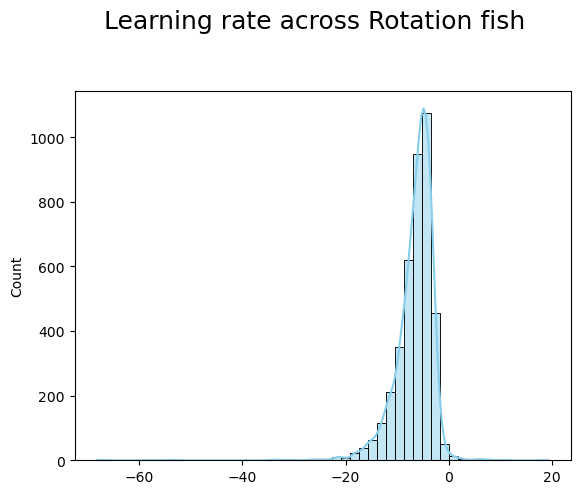

In [92]:
sns.histplot(LR_R_across, bins=50, kde=True, color='skyblue')

plt.suptitle('Learning rate across Rotation fish', fontsize=18, y=1.05)  # Adjust fontsize and y position as needed

c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.05, 'Learning rates across Washout fish')

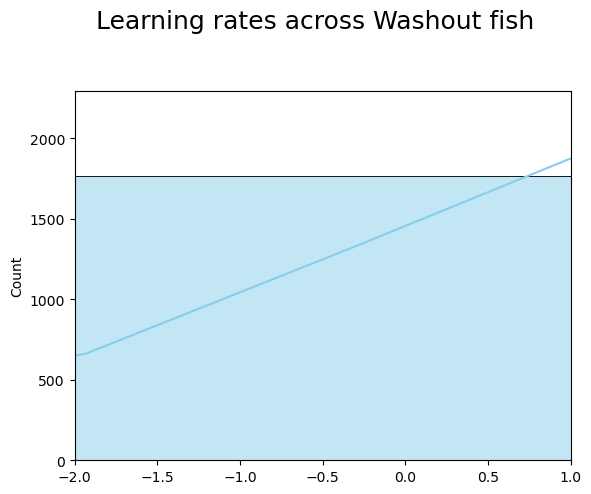

In [93]:

LR_W = LR.sel({'stages':'Washout' })
LR_W_across = LR_W.mean(dim='fish')
LR_W_across = LR_W_across.values.flatten()
sns.histplot(LR_W_across, bins=50, kde=True, color='skyblue')
plt.xlim(-2,1)
plt.suptitle('Learning rates across Washout fish', fontsize=18, y=1.05)  # Adjust fontsize and y position as needed

c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.05, 'Learning rate across Rerotation fish')

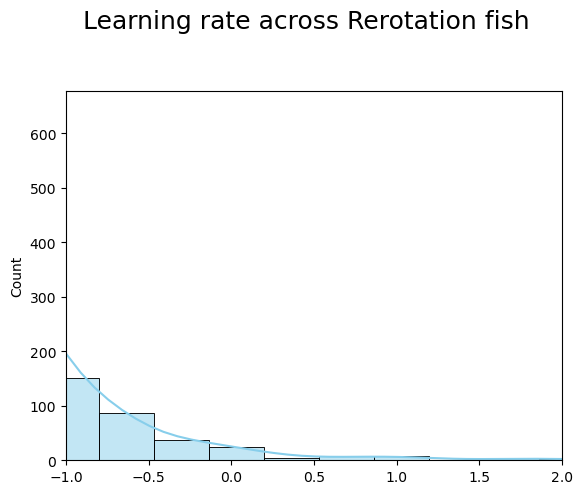

In [94]:

LR_ReR = LR.sel({'stages':'ReRotation' })
# Flatten the data array to a 1-dimensional numpy array
LR_ReR_across = LR_ReR.mean(dim='fish')
LR_ReR_across = LR_ReR_across.values.flatten()
sns.histplot(LR_ReR_across, bins=50, kde=True, color='skyblue')
plt.xlim(-1,2)
plt.suptitle('Learning rate across Rerotation fish', fontsize=18, y=1.05)  # Adjust fontsize and y position as needed # Adjust fontsize and y position as needed

In [95]:

# # Prepare data
# fig, ax = plt.subplots(figsize=(10, 6))

# # Define jitter amount
# jitter = 0.05

# # Plotting lines for each fish
# for idx, row in figure7plot_df.iterrows():
#     x_values = [0 + np.random.uniform(-jitter, jitter), 1 + np.random.uniform(-jitter, jitter)]
#     ax.errorbar(x_values, [row['Learn_R_mean'], row['Learn_ReR_mean']],
#                 yerr=[row['Learn_R_sd'], row['Learn_ReR_sd']], fmt='-o', label=f'Fish {row["fish"]}')

# # Customizing plot
# ax.set_xticks([0, 1])
# ax.set_xticklabels(['Learn_R', 'Learn_ReR'])
# ax.set_ylabel('A_μμ/τ_μ')
# ax.set_title('Paired Comparison of Learn_R and Learn_ReR')
# ax.legend(title='Fish', bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.show()

In [96]:
# # Create the figure and axis
# plt.figure(figsize=(15, 6))

# # Define a color palette and a color map to ensure consistency
# palette = sns.color_palette('Set2', n_colors=len(figure7plot_df['fish'].unique()))
# color_map = {fish: palette[i] for i, fish in enumerate(figure7plot_df['fish'].unique())}

# # Plot each group of data points with error bars and lines
# for fish in figure7plot_df['fish'].unique():
#     subset = figure7plot_df[figure7plot_df['fish'] == fish]
#     color = color_map[fish]
    
#     # Plot with error bars for Washout
#     plt.errorbar(
#         x=subset['σ_μ_inf_W_mean'], 
#         y=subset['Learn_ReR_mean'], 
#         xerr=subset['σ_μ_inf_W_sd'], 
#         yerr=subset['Learn_R_sd'], 
#         fmt='o', 
#         label=f'{fish} - Rotation to ReRotation', 
#         color=color
#     )
    
#     # Plot with error bars for Rotation
#     plt.errorbar(
#         x= subset['σ_μ_inf_B_mean'], 
#         y= subset['Learn_R_mean'], 
#         xerr = subset['σ_μ_inf_B_sd'],
#         yerr= subset['Learn_R_sd'], 
#         fmt='o', 
#    #     label=f'{fish} - Rotation', 
#         color=color
#     )
    
#     # Connect the points with a line
#     plt.plot(
#         [subset['σ_μ_inf_W_sd'].values[0], subset['σ_μ_inf_B_sd'].values[0]],
#         [subset['Learn_ReR_mean'].values[0], subset['Learn_R_mean'].values[0]],
#         color=color
#     )

# # Set labels and legend
# plt.xlabel('mean of the best performance in the last stage') 
# plt.ylabel('Learning rate in current stage')
# plt.legend(title='Fish', bbox_to_anchor=(1.01, 1))
# plt.grid(False)

# plt.show()

In [97]:
# plt.figure(figsize=(8, 4))
# sns.scatterplot(x='σ_μ_inf_W_sd',y = 'Learn_ReR_mean',data=figure7plot_df)
# sns.scatterplot(x='σ_μ_inf_B_sd',y = 'Learn_R_mean',data=figure7plot_df)
# plt.xlabel('stand deviation of the best performance in the last stage') 
# plt.ylabel('Learning rate in current stage')
# # Add error bars
# for key, grp in figure7plot_df.groupby('fish'):
#     plt.errorbar(grp['σ_μ_inf_B_sd'], grp['Learn_R_mean'], yerr=grp['Learn_R_sd'], fmt='none', ecolor='red', alpha=0.7)
#     plt.errorbar(grp['σ_μ_inf_W_sd'], grp['Learn_ReR_mean'], yerr=grp['Learn_ReR_sd'], fmt='none', ecolor='blue', alpha=0.7)


In [98]:
# plt.figure(figsize=(7, 7))
# sns.scatterplot(x='Learn_R_mean',y = 'Learn_ReR_mean',data=figure7plot_df)
# for key, grp in figure7plot_df.groupby('fish'):
    
#     plt.errorbar(grp['Learn_R_mean'], grp['Learn_ReR_mean'], xerr=grp['Learn_R_sd'], fmt='none', ecolor='red', alpha=0.7)
#     plt.errorbar(grp['Learn_R_mean'], grp['Learn_ReR_mean'], yerr=grp['Learn_ReR_sd'], fmt='none', ecolor='blue', alpha=0.7)

# plt.xlabel('Learning rate in Rotaion stage') 
# plt.ylabel('Learning rate in ReRotation stage')
# plt.xlim(-1,2)
# plt.ylim(-1,2)

# # Add error bars


In [99]:
# # Define a function to draw an ellipse
# def draw_ellipse(x, y, width, height, ax, **kwargs):
#     ellipse = Ellipse((x, y), width, height, **kwargs)
#     ax.add_patch(ellipse)

# # Create the plot
# plt.figure(figsize=(7, 7))
# ax = plt.gca()

# # Scatter plot
# sns.scatterplot(x='Learn_R_mean', y='Learn_ReR_mean', data=figure7plot_df, ax=ax)

# # Draw error ellipses
# for key, grp in figure7plot_df.groupby('fish'):
#     for i, row in grp.iterrows():
#         draw_ellipse(row['Learn_R_mean'], row['Learn_ReR_mean'], row['Learn_R_sd']/2, row['Learn_ReR_sd']/2, ax, edgecolor='blue', facecolor='none', alpha=0.5)

# # Regression line
# x = figure7plot_df['Learn_R_mean'].values
# y = figure7plot_df['Learn_ReR_mean'].values
# A = np.vstack([x, np.ones(len(x))]).T
# m, c = np.linalg.lstsq(A, y, rcond=None)[0]
# y_pred = m * x + c
# plt.plot(x, y_pred, color='red', linestyle='--', linewidth=2, label='Regression Line')

# # Labels and limits
# plt.xlabel('Learning rate in Rotation stage')
# plt.ylabel('Learning rate in ReRotation stage')
# plt.xlim(-1, 2)
# plt.ylim(-1, 2)

# # Add legend
# plt.legend()

# # Show plot
# plt.show()

In [100]:
# Assuming LR_R is your xarray.DataArray
# Flatten the DataArray and convert to a pandas DataFrame
df_R = LR_R.to_dataframe(name='LR').reset_index()
df_ReR = LR_ReR.to_dataframe(name='LR').reset_index()
# Assuming 'fish' is one of the dimensions and 'LR_Rdata' is the flattened data
# Select only 'LR_Rdata' and 'fish' columns
df_R = df_R[['LR', 'fish']]
df_R['session'] = 'Rotation'
df_ReR = df_ReR[['LR', 'fish']]
df_ReR['session'] = 'ReRotation'
df_vioLR = pd.concat([df_R[['LR', 'fish','session']],df_ReR[['LR','session','fish']]])
# Display the dataframe
print(df_vioLR)

             LR  fish     session
0     -2.262985    10    Rotation
1     -2.070453    12    Rotation
2      0.418454    14    Rotation
3     -8.957654    21    Rotation
4     -9.120135     3    Rotation
...         ...   ...         ...
27995 -2.319231    14  ReRotation
27996 -0.688559    21  ReRotation
27997  1.435387     3  ReRotation
27998  0.406045     7  ReRotation
27999 -3.256250     9  ReRotation

[56000 rows x 3 columns]


In [101]:
# Assuming LR_R is your xarray.DataArray
# Flatten the DataArray and convert to a pandas DataFrame
df_R = LR_R.to_dataframe(name='LR_R').reset_index()
df_ReR = LR_ReR.to_dataframe(name='LR_ReR').reset_index()
# Assuming 'fish' is one of the dimensions and 'LR_Rdata' is the flattened data
# Select only 'LR_Rdata' and 'fish' columns
df_R = df_R[['LR_R', 'fish']]
df_R['session'] = 'Rotation'
df_ReR = df_ReR[['LR_ReR', 'fish']]
df_ReR['session'] = 'ReRotation'
df_kdeLR = pd.concat([df_R[['LR_R', 'fish','session']],df_ReR[['LR_ReR','session']]],axis =1)
# Display the dataframe
print(df_kdeLR)

            LR_R  fish   session    LR_ReR     session
0      -2.262985    10  Rotation -3.041097  ReRotation
1      -2.070453    12  Rotation -4.931827  ReRotation
2       0.418454    14  Rotation -4.994965  ReRotation
3      -8.957654    21  Rotation -1.667633  ReRotation
4      -9.120135     3  Rotation  1.942225  ReRotation
...          ...   ...       ...       ...         ...
27995  -1.411653    14  Rotation -2.319231  ReRotation
27996  -7.821082    21  Rotation -0.688559  ReRotation
27997 -31.600122     3  Rotation  1.435387  ReRotation
27998  -2.375643     7  Rotation  0.406045  ReRotation
27999  -2.296176     9  Rotation -3.256250  ReRotation

[28000 rows x 5 columns]


In [102]:
LR_arosfish  = LR.mean(dim= 'fish')
LR_A=LR_arosfish.to_dataframe(name='LR_A').reset_index()

In [103]:

LR_R_arosfish  = LR_R.mean(dim= 'fish')
LR_ReR_arosfish = LR_ReR.mean(dim= 'fish')


In [104]:
LR_R_A=LR_R_arosfish.to_dataframe(name='LR_R_A').reset_index()
LR_ReR_A=LR_ReR_arosfish.to_dataframe(name='LR_ReR_A').reset_index()

In [105]:
df_kdeLR_A = pd.concat([LR_R_A['LR_R_A'],LR_ReR_A['LR_ReR_A']],axis=1)

In [106]:
SD = posterior.A_σμ
SD_R = SD.sel({'stages':'Rotation' })
SD_R_across = SD_R.mean(dim='fish')
SD_R_across = SD_R_across.values.flatten()
SD_ReR = SD.sel({'stages':'ReRotation' })
# Flatten the data array to a 1-dimensional numpy array
SD_ReR_across = SD_ReR.mean(dim='fish')
SD_ReR_across = SD_ReR_across.values.flatten()

In [107]:
# Assuming LR_R is your xarray.DataArray
# Flatten the DataArray and convert to a pandas DataFrame
df_R = SD_R.to_dataframe(name='SD').reset_index()
df_ReR = SD_ReR.to_dataframe(name='SD').reset_index()
# Assuming 'fish' is one of the dimensions and 'LR_Rdata' is the flattened data
# Select only 'LR_Rdata' and 'fish' columns
df_R = df_R[['SD', 'fish']]
df_R['session'] = 'Rotation'
df_ReR = df_ReR[['SD', 'fish']]
df_ReR['session'] = 'ReRotation'
df_vioSD = pd.concat([df_R[['SD', 'fish','session']],df_ReR[['SD','session','fish']]])


#  For the final version plots

In [108]:
# ppcplot_df_day.to_csv("D:/FOVmodel/finalplotversion/yds_model_df.csv", index=False)

In [109]:
# ppcplot_df_day

### Learning rate Figure 7

In [110]:
LR_F = LR.mean(dim="fish")
LR_FR = LR_F.sel(stages=LR['stages'].isin(['Rotation', 'ReRotation']))
df_LR_FR = LR_FR.to_dataframe(name='LR_FR').reset_index()

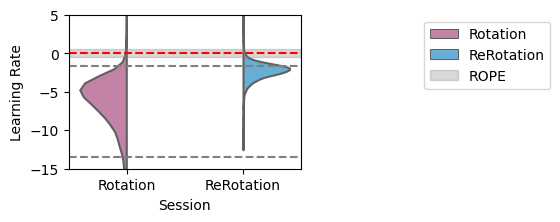

In [111]:
# Define the bounds of the ROPE
rope_min = 0.5
rope_max = -0.5
color = {'session':{"Rotation": '#CC79A7', "ReRotation": '#56B4E9'}}
# Set the plotting style
plt.style.use('default')
# Plot the violin plots for each session
plt.figure(figsize=(3, 2))

sns.violinplot(data=df_LR_FR, x="stages", y="LR_FR", hue="stages", split=True, palette=color['session'], inner=None)
# Add ROPE
plt.axhspan(rope_min, rope_max, color='grey', alpha=0.3, label='ROPE')
plt.axhline(y=ADirectionLR.loc['x[Rotation]','hdi_3%'], color='grey', linestyle='--')
plt.axhline(y=ADirectionLR.loc['x[Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.title('Violin Plot of Learning Rates Across Sessions')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Session')
plt.ylabel('Learning Rate')
plt.ylim(-15, 5)
plt.legend( bbox_to_anchor=(1.5, 1))

plt.savefig(os.path.join(plotfolder, f'Figure7B1.png'), bbox_inches='tight', dpi=600)

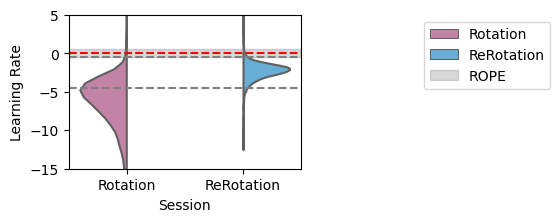

In [112]:

# Plot the violin plots for each session
plt.figure(figsize=(3, 2))
sns.violinplot(data=df_LR_FR, x="stages", y="LR_FR", hue="stages", split=True, palette=color['session'], inner=None)
# Add ROPE
plt.axhspan(rope_min, rope_max, color='grey', alpha=0.3, label='ROPE')
plt.axhline(y=ADirectionLR.loc['x[ReRotation]','hdi_3%'], color='grey', linestyle='--')
plt.axhline(y=ADirectionLR.loc['x[ReRotation]','hdi_97%'], color='grey', linestyle='--')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Session')
plt.ylabel('Learning Rate')
plt.ylim(-15, 5)
plt.legend( bbox_to_anchor=(1.5, 1))
# plt.title('Violin Plot of Learning Rates Across Sessions')

plt.savefig(os.path.join(plotfolder, f'Figure7B2.png'), bbox_inches='tight', dpi=600)

### Asymptotic performance Figure 6

In [113]:
BP = posterior.μ_μ_inf
BP_R = BP.sel({'stages':'Rotation' })
BP_R_across = BP_R.mean(dim='fish')
BP_R_across = BP_R_across.values.flatten()
BP_ReR = BP.sel({'stages':'ReRotation' })
# Flatten the data array to a 1-dimensional numpy array
BP_ReR_across = BP_ReR.mean(dim='fish')
BP_ReR_across = BP_ReR_across.values.flatten()

In [114]:
BP_across = BP.mean(dim='fish')
ADirectionBP = az.summary(BP_across)
ADirectionBP.to_csv('ADirectionAP.csv')
EDirectionBP = az.summary(BP)
EDirectionBP.to_csv('EDirectionAP.csv')

In [115]:
# Assuming LR_R is your xarray.DataArray
# Flatten the DataArray and convert to a pandas DataFrame
df_R = BP_R.to_dataframe(name='BP').reset_index()
df_ReR = BP_ReR.to_dataframe(name='BP').reset_index()
# Assuming 'fish' is one of the dimensions and 'LR_Rdata' is the flattened data
# Select only 'LR_Rdata' and 'fish' columns
df_R = df_R[['BP', 'fish']]
df_R['session'] = 'Rotation'
df_ReR = df_ReR[['BP', 'fish']]
df_ReR['session'] = 'ReRotation'
df_vioBP = pd.concat([df_R[['BP', 'fish','session']],df_ReR[['BP','session','fish']]])


In [116]:
BP_F = BP.mean(dim="fish")
BP_FR = BP_F.sel(stages=BP['stages'].isin(['Rotation', 'ReRotation']))
df_FR = BP_FR.to_dataframe(name='BP_FR').reset_index()

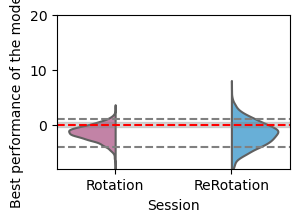

In [117]:


plt.figure(figsize=(3, 2))
sns.violinplot(data=df_FR , x="stages", y="BP_FR", hue="stages", split=True, palette=color['session'], inner=None)
# Add ROPE
plt.axhspan(rope_min, rope_max, color='grey', alpha=0.3, label='ROPE')

plt.axhline(y=ADirectionBP.loc['μ_μ_inf[Rotation]','hdi_3%'], color='grey', linestyle='--')
plt.axhline(y=ADirectionBP.loc['μ_μ_inf[Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ADirectionBP.loc['μ_μ_inf[ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ADirectionBP.loc['μ_μ_inf[ReRotation]','hdi_97%'], color='grey', linestyle='--')

plt.xlabel('Session')

plt.ylim(-8, 20)
plt.ylabel('Best performance of the modelfit')
plt.legend().set_visible(False)
#plt.title('Best performance Across Sessions')
plt.axhline(y=0, color='red', linestyle='--')
plt.savefig(os.path.join(plotfolder, f'Figure7A3.png'), bbox_inches='tight', dpi=600)

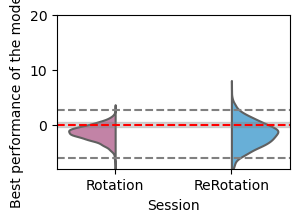

In [118]:

plt.figure(figsize=(3, 2))
sns.violinplot(data=df_FR , x="stages", y="BP_FR", hue="stages", split=True, palette=color['session'], inner=None)
# Add ROPE
plt.axhspan(rope_min, rope_max, color='grey', alpha=0.3, label='ROPE')
plt.axhline(y=ADirectionBP.loc['μ_μ_inf[ReRotation]','hdi_3%'], color='grey', linestyle='--')
plt.axhline(y=ADirectionBP.loc['μ_μ_inf[ReRotation]','hdi_97%'], color='grey', linestyle='--')

plt.xlabel('Session')

plt.ylim(-8, 20)
plt.ylabel('Best performance of the modelfit')
plt.legend().set_visible(False)
#plt.title('Best performance Across Sessions')
plt.axhline(y=0, color='red', linestyle='--')
plt.savefig(os.path.join(plotfolder, f'Figure7A4.png'), bbox_inches='tight', dpi=600)

In [119]:
BP_SR = BP.sel(stages=BP['stages'].isin(['Rotation', 'ReRotation']))
df_BP_SR = BP_SR.to_dataframe(name='BP_SR').reset_index()

c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


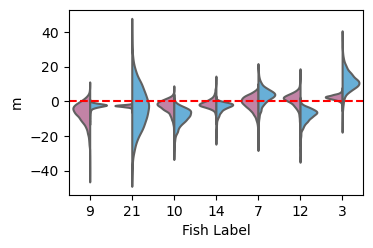

In [120]:
# Calculate the mean learning rate for each fish in the "Rotation" session
BP_SR_medians = df_BP_SR[df_BP_SR ['stages'] == 'Rotation'].groupby('fish')['BP_SR'].median()

# Sort fish by mean learning rate in "Rotation" session in descending order
sorted_BP_SR_median = BP_SR_medians.sort_values(ascending=True).index

# Reorder the DataFrame according to the sorted fish
df_BP_SR ['fish'] = pd.Categorical(df_BP_SR ['fish'], categories=sorted_BP_SR_median, ordered=True)
df_BP_SR   =df_BP_SR.sort_values('fish')
#  Create a categorical type for the 'stages' column
df_BP_SR ['stages'] = pd.Categorical(df_BP_SR ['stages'], categories=['Rotation', 'ReRotation'], ordered=True)
# Sort the DataFrame by 'stages' and then by 'fish'
df_BP_SR  = df_BP_SR .sort_values(by=['stages', 'fish'])

plt.figure(figsize=(3.8, 2.4))
sns.violinplot(data=df_BP_SR , x="fish", y="BP_SR", hue="stages", split=True, palette=color['session'], inner=None, order=sorted_BP_SR_median, scale='width')

# plt.ylim(-3.8, 2.4)
plt.xlabel('Fish Label' )
plt.ylabel('m')
plt.axhline(y=0, color='red', linestyle='--')


# Add legend
plt.legend().set_visible(False)
# plt.legend( bbox_to_anchor=(1.5, 1))
#plt.title('Violin Plot of Learning Rates with HDI Intervals')
# plt.grid(False)
plt.show()

### Figure 7 initial error

In [121]:
IE = posterior.A_μμ + posterior.μ_μ_inf
IE_SR = IE.sel(stages=IE['stages'].isin(['Rotation', 'ReRotation']))
df_IE_SR = IE_SR.to_dataframe(name='IE_SR').reset_index()
IE_F = IE.mean(dim="fish")
IE_FR = IE_F.sel(stages=BP['stages'].isin(['Rotation', 'ReRotation']))
df_IE_FR = IE_FR.to_dataframe(name='IE_FR').reset_index()


c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


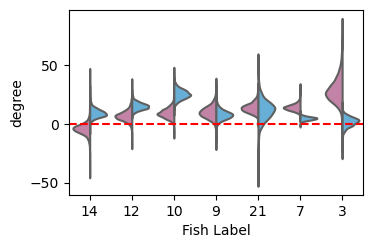

In [122]:
# Calculate the mean learning rate for each fish in the "Rotation" session
IE_SR_medians = df_IE_SR[df_IE_SR ['stages'] == 'Rotation'].groupby('fish')['IE_SR'].median()

# Sort fish by mean learning rate in "Rotation" session in descending order
sorted_IE_SR_median = IE_SR_medians.sort_values(ascending=True).index

# Reorder the DataFrame according to the sorted fish
df_IE_SR ['fish'] = pd.Categorical(df_IE_SR ['fish'], categories=sorted_IE_SR_median, ordered=True)
df_IE_SR   =df_IE_SR.sort_values('fish')
#  Create a categorical type for the 'stages' column
df_IE_SR ['stages'] = pd.Categorical(df_IE_SR ['stages'], categories=['Rotation', 'ReRotation'], ordered=True)
# Sort the DataFrame by 'stages' and then by 'fish'
df_IE_SR  = df_IE_SR .sort_values(by=['stages', 'fish'])

plt.figure(figsize=(3.8, 2.4))
sns.violinplot(data=df_IE_SR , x="fish", y="IE_SR", hue="stages", split=True, palette=color['session'], inner=None, order=sorted_IE_SR_median, scale='width')

# plt.ylim(-3.8, 2.4)
plt.xlabel('Fish Label' )
plt.ylabel('degree')
plt.axhline(y=0, color='red', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[3, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[3, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[21, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[21, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[9, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[9, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[7, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[7, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[10, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[10, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[12, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[12, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[14, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[14, Rotation]','hdi_97%'], color='grey', linestyle='--')

# Add legend
plt.legend().set_visible(False)
# plt.legend( bbox_to_anchor=(1.5, 1))
#plt.title('Violin Plot of Learning Rates with HDI Intervals')
# plt.grid(False)
plt.show()

In [123]:
ADirectionIE = az.summary(IE_F)
ADirectionIE.to_csv('ADirectionIE.csv')


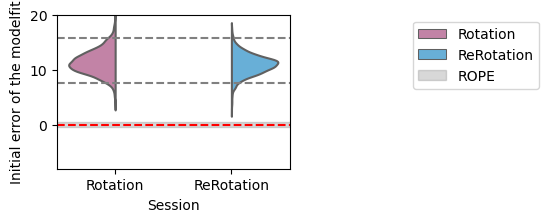

In [124]:

# Define the bounds of the ROPE
rope_min = 0.5
rope_max = -0.5
color = {'session':{"Rotation": '#CC79A7', "ReRotation": '#56B4E9'}}
plt.figure(figsize=(3, 2))
sns.violinplot(data=df_IE_FR , x="stages", y="IE_FR", hue="stages", split=True, palette=color['session'], inner=None)
# Add ROPE
plt.axhspan(rope_min, rope_max, color='grey', alpha=0.3, label='ROPE')

plt.axhline(y=ADirectionIE.loc['x[Rotation]','hdi_3%'], color='grey', linestyle='--')
plt.axhline(y=ADirectionIE.loc['x[Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ALengthBP.loc['x[ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ALengthBP.loc['x[ReRotation]','hdi_97%'], color='grey', linestyle='--')

plt.ylim(-8, 20)
plt.xlabel('Session')

plt.ylabel('Initial error of the modelfit')
plt.legend( bbox_to_anchor=(1.5, 1))
#plt.title('Best performance Across Sessions')
plt.axhline(y=0, color='red', linestyle='--')
plt.savefig(os.path.join(plotfolder, f'Figure7A1.png'), bbox_inches='tight', dpi=600)

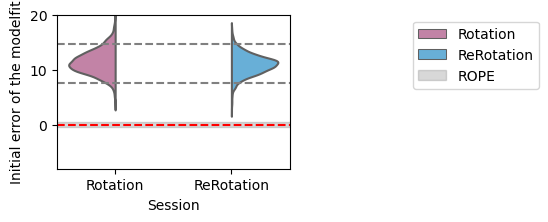

In [125]:

# Define the bounds of the ROPE
rope_min = 0.5
rope_max = -0.5
color = {'session':{"Rotation": '#CC79A7', "ReRotation": '#56B4E9'}}
plt.figure(figsize=(3, 2))
sns.violinplot(data=df_IE_FR , x="stages", y="IE_FR", hue="stages", split=True, palette=color['session'], inner=None)
# Add ROPE
plt.axhspan(rope_min, rope_max, color='grey', alpha=0.3, label='ROPE')

# plt.axhline(y=ALengthBP.loc['x[Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ALengthBP.loc['x[Rotation]','hdi_97%'], color='grey', linestyle='--')
plt.axhline(y=ADirectionIE.loc['x[ReRotation]','hdi_3%'], color='grey', linestyle='--')
plt.axhline(y=ADirectionIE.loc['x[ReRotation]','hdi_97%'], color='grey', linestyle='--')

plt.ylim(-8, 20)
plt.xlabel('Session')

plt.ylabel('Initial error of the modelfit')
plt.legend( bbox_to_anchor=(1.5, 1))
#plt.title('Best performance Across Sessions')
plt.axhline(y=0, color='red', linestyle='--')
plt.savefig(os.path.join(plotfolder, f'Figure7A2.png'), bbox_inches='tight', dpi=600)

## Figure 8 negative correlation

In [126]:
rotation_data = LR.sel(stages='Rotation')
rerotation_data = LR.sel(stages='ReRotation')

In [127]:
assert rotation_data.shape == rerotation_data.shape

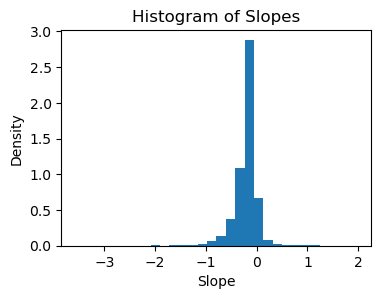

C:\Users\86153\AppData\Local\Temp\ipykernel_39092\2292982840.py:40: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_regression_lines = az.hdi(regression_lines, hdi_prob=0.94)


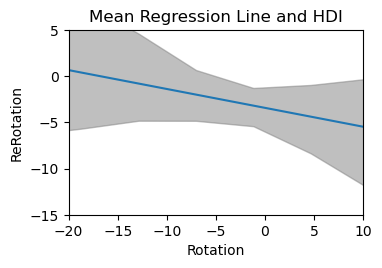

In [128]:
# Initialize lists to store the regression parameters
slopes = []
intercepts = []

# Perform linear regression for each (chain, draw)
for chain in range(rotation_data.shape[0]):
    for draw in range(rotation_data.shape[1]):
        x = rotation_data[chain, draw, :].values
        y = rerotation_data[chain, draw, :].values
        slope, intercept = np.polyfit(x, y, 1)
        slopes.append(slope)
        intercepts.append(intercept)

# Convert slopes and intercepts to arrays
slopes = np.array(slopes)
intercepts = np.array(intercepts)

# Plot histogram of slopes
plt.figure(figsize=(4, 2.8))
plt.hist(slopes, bins=30, density=True)
plt.xlabel('Slope')
plt.ylabel('Density')
plt.title('Histogram of Slopes')
plt.show()

# Plot mean regression line and HDI
x_vals = np.linspace(rotation_data.values.min(), rotation_data.values.max(), 100)

# Compute regression lines
regression_lines = []
for i in range(len(slopes)):
    regression_lines.append(intercepts[i] + slopes[i] * x_vals)

regression_lines = np.array(regression_lines)

# Mean regression line
mean_regression_line = regression_lines.mean(axis=0)

# HDI of regression lines
hdi_regression_lines = az.hdi(regression_lines, hdi_prob=0.94)

plt.figure(figsize=(3.8, 2.4))
plt.plot(x_vals, mean_regression_line, label='Mean Regression Line')
plt.fill_between(x_vals, hdi_regression_lines[:, 0], hdi_regression_lines[:, 1], color='gray', alpha=0.5, label='94% HDI')
plt.xlabel('Rotation')
plt.ylabel('ReRotation')
plt.ylim(-15,5)
plt.xlim(-20,10)
plt.title('Mean Regression Line and HDI')
plt.legend().set_visible(False)
plt.savefig(os.path.join(plotfolder, f'Figure8B2.png'), bbox_inches='tight', dpi=600)

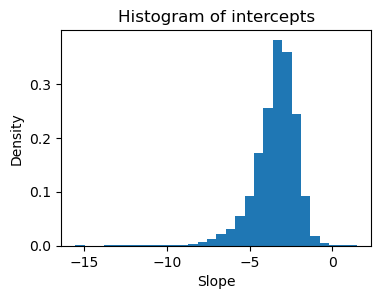

In [129]:
# Plot histogram of intercepts
plt.figure(figsize=(4, 2.8))
plt.hist(intercepts, bins=30, density=True)
plt.xlabel('Slope')
plt.ylabel('Density')
plt.title('Histogram of intercepts')
plt.show()

In [130]:
az.summary(slopes)

arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
x -0.204  0.243  -0.718    0.098      0.004    0.003    2839.0    3297.0   

   r_hat  
x    NaN

## Figure8 learning rate for each fish

In [131]:
LR_SR = LR.sel(stages=LR['stages'].isin(['Rotation', 'ReRotation']))
df_LR_SR = LR_SR.to_dataframe(name='LR_SR').reset_index()



c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


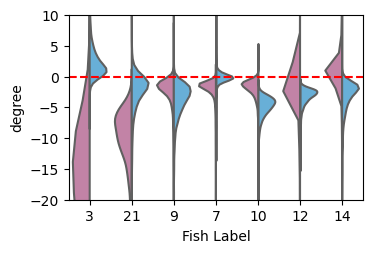

In [132]:
# Calculate the mean learning rate for each fish in the "Rotation" session
LR_SR_medians = df_LR_SR [df_LR_SR ['stages'] == 'Rotation'].groupby('fish')['LR_SR'].median()

# Sort fish by mean learning rate in "Rotation" session in descending order
sorted_LR_SR_median = LR_SR_medians.sort_values(ascending=True).index

# Reorder the DataFrame according to the sorted fish
df_LR_SR ['fish'] = pd.Categorical(df_LR_SR ['fish'], categories=sorted_LR_SR_median, ordered=True)
df_LR_SR  = df_LR_SR.sort_values('fish')
df_LR_SR['stages'] = pd.Categorical(df_LR_SR['stages'], categories=['Rotation', 'ReRotation'], ordered=True)
# Sort the DataFrame by 'stages' and then by 'fish'
df_LR_SR = df_LR_SR.sort_values(by=['stages', 'fish'])
plt.figure(figsize=(3.8, 2.4))
sns.violinplot(data=df_LR_SR, x="fish", y="LR_SR", hue="stages", split=True, palette=color['session'], inner=None, order=sorted_LR_SR_median, scale='width')

plt.ylim(-20, 10)
plt.xlabel('Fish Label')
plt.ylabel('degree')
plt.axhline(y=0, color='red', linestyle='--')
# plt.axhline(y=EDirectionLR.loc['x[3, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=EDirectionLR.loc['x[3, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=EDirectionLR.loc['x[21, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=EDirectionLR.loc['x[21, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=EDirectionLR.loc['x[9, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=EDirectionLR.loc['x[9, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=EDirectionLR.loc['x[7, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=EDirectionLR.loc['x[7, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=EDirectionLR.loc['x[10, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=EDirectionLR.loc['x[10, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=EDirectionLR.loc['x[12, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=EDirectionLR.loc['x[12, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=EDirectionLR.loc['x[14, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=EDirectionLR.loc['x[14, Rotation]','hdi_97%'], color='grey', linestyle='--')

# Add legend
plt.legend().set_visible(False)
# plt.legend( bbox_to_anchor=(1.5, 1))
#plt.title('Violin Plot of Learning Rates with HDI Intervals')
# plt.grid(False)
plt.savefig(os.path.join(plotfolder, f'Figure8B1.png'), bbox_inches='tight', dpi=600)


C:\Users\86153\AppData\Local\Temp\ipykernel_39092\1126363996.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  LR_SR_medians = df_LR_SR [df_LR_SR ['stages'] == 'Rotation'].groupby('fish')['LR_SR'].median()
c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


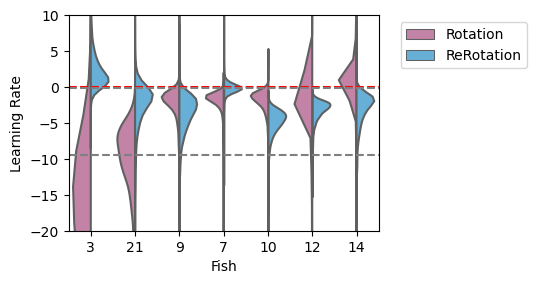

In [133]:
# Calculate the mean learning rate for each fish in the "Rotation" session
LR_SR_medians = df_LR_SR [df_LR_SR ['stages'] == 'Rotation'].groupby('fish')['LR_SR'].median()

# Sort fish by mean learning rate in "Rotation" session in descending order
sorted_LR_SR_median = LR_SR_medians.sort_values(ascending=True).index

# Reorder the DataFrame according to the sorted fish
df_LR_SR ['fish'] = pd.Categorical(df_LR_SR ['fish'], categories=sorted_LR_SR_median, ordered=True)
df_LR_SR  = df_LR_SR.sort_values('fish')
df_LR_SR['stages'] = pd.Categorical(df_LR_SR['stages'], categories=['Rotation', 'ReRotation'], ordered=True)
# Sort the DataFrame by 'stages' and then by 'fish'
df_LR_SR = df_LR_SR.sort_values(by=['stages', 'fish'])
plt.figure(figsize=(4, 2.8))
sns.violinplot(data=df_LR_SR, x="fish", y="LR_SR", hue="stages", split=True, palette=color['session'], inner=None, order=sorted_LR_SR_median, scale='width')

plt.ylim(-20, 10)
plt.xlabel('Fish')
plt.ylabel('Learning Rate')
plt.axhline(y=0, color='red', linestyle='--')
# plt.axhline(y=EDirectionLR.loc['x[3, ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=EDirectionLR.loc['x[3, ReRotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=EDirectionLR.loc['x[21, ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=EDirectionLR.loc['x[21, ReRotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=EDirectionLR.loc['x[9, ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=EDirectionLR.loc['x[9, ReRotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=EDirectionLR.loc['x[7, ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=EDirectionLR.loc['x[7, ReRotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=EDirectionLR.loc['x[10, ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=EDirectionLR.loc['x[10, ReRotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=EDirectionLR.loc['x[12, ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=EDirectionLR.loc['x[12, ReRotation]','hdi_97%'], color='grey', linestyle='--')
plt.axhline(y=EDirectionLR.loc['x[14, ReRotation]','hdi_3%'], color='grey', linestyle='--')
plt.axhline(y=EDirectionLR.loc['x[14, ReRotation]','hdi_97%'], color='grey', linestyle='--')

# Add legend
# plt.legend().set_visible(False)
plt.legend( bbox_to_anchor=(1.5, 1))
#plt.title('Violin Plot of Learning Rates with HDI Intervals')
# plt.grid(False)
plt.show()


In [134]:
selected_data = posterior.μ_μ.isel(data=[150,151,152,153,154,155,
                                          598, 599, 600, 601, 602, 603,
                                          999, 1000, 1001, 1002, 1003, 1004,
                                          1395,1396,1397,1398,1399,1400,
                                          1705,1706,1707,1708,1709,1710,
                                          1975,1976,1977,1978,1979,1980,
                                          2303,2304,2305,2306,2307,2308
                                          ])


In [135]:
R_start_indices = [149, 597, 998, 1394, 1704, 1974, 2302]
num_sessions = 15
num_trials_per_fish = 6  # Number of trials per fish for each session

# Generate indices for each session
R_μ_μ_indices = [
    [start + j for start in R_start_indices for j in range(i * num_trials_per_fish, (i + 1) * num_trials_per_fish)]
    for i in range(num_sessions)
]

In [136]:
# Extract data and concatenate along a new dimension
R_μ_μ = xr.concat([posterior.μ_μ.isel(data=idx) for idx in R_μ_μ_indices], dim='sessions')

# Assign stage labels, if desired
R_μ_μ = R_μ_μ.assign_coords(sessions=[f'R{i+1}' for i in range(num_sessions)])

In [137]:
hdi_fish = R_μ_μ.mean(dim = 'data') 
az.summary(hdi_fish)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
μ_μ[R1]   11.427  2.221   7.548   15.787      0.039    0.028    3267.0   
μ_μ[R2]    7.110  1.162   5.075    9.470      0.017    0.012    4867.0   
μ_μ[R3]    5.020  0.882   3.336    6.602      0.014    0.010    4165.0   
μ_μ[R4]    3.795  0.722   2.553    5.199      0.012    0.008    3781.0   
μ_μ[R5]    2.979  0.623   1.867    4.175      0.010    0.007    3693.0   
μ_μ[R6]    2.385  0.565   1.344    3.455      0.009    0.007    3755.0   
μ_μ[R7]    1.924  0.536   0.906    2.934      0.009    0.006    3946.0   
μ_μ[R8]    1.552  0.528   0.582    2.603      0.008    0.006    4158.0   
μ_μ[R9]    1.241  0.535   0.281    2.321      0.008    0.006    4281.0   
μ_μ[R10]   0.977  0.552  -0.028    2.075      0.008    0.006    4245.0   
μ_μ[R11]   0.748  0.576  -0.280    1.903      0.009    0.006    4093.0   
μ_μ[R12]   0.547  0.604  -0.607    1.647      0.010    0.007    3901.0   
μ_μ[R13]   0.370  0.635  -0.830    1.520      0.010    0.008    3711.0   
μ_μ[R14]   0.213  0.667  -1.041    1.423      0.011    0.008    3530.0   
μ_μ[R15]   0.072  0.699  -1.234    1.350      0.012    0.009    3364.0   

          ess_tail  r_hat  
μ_μ[R1]     2894.0    1.0  
μ_μ[R2]     3664.0    1.0  
μ_μ[R3]     3423.0    1.0  
μ_μ[R4]     3702.0    1.0  
μ_μ[R5]     3576.0    1.0  
μ_μ[R6]     3611.0    1.0  
μ_μ[R7]     3789.0    1.0  
μ_μ[R8]     3501.0    1.0  
μ_μ[R9]     3153.0    1.0  
μ_μ[R10]    3336.0    1.0  
μ_μ[R11]    3369.0    1.0  
μ_μ[R12]    3416.0    1.0  
μ_μ[R13]    3434.0    1.0  
μ_μ[R14]    3299.0    1.0  
μ_μ[R15]    3156.0    1.0

In [138]:
posterior_μ_μ = posterior["μ_μ"]
day_ = id_yds_numpyro.constant_data["day_"]
stage_ = id_yds_numpyro.constant_data["stage_"]
fish_ = id_yds_numpyro.constant_data["fish_"]


In [139]:
# Assign all coordinates
posterior_μ_μ_with_coords = posterior_μ_μ.assign_coords(day_=day_, stage_=stage_, fish_=fish_)

In [140]:
# Extract coordinates
day_ = posterior_μ_μ_with_coords.coords['day_'].values
stage_ = posterior_μ_μ_with_coords.coords['stage_'].values

# Initialize index lists
B_indices = [[] for _ in range(25)]  # For day_ = 0 to 24, stage_ = 0
R_indices = [[] for _ in range(15)]  # For day_ = 0 to 14, stage_ = 1
W_indices = [[] for _ in range(10)]  # For day_ = 0 to 9, stage_ = 2
ReR_indices = [[] for _ in range(15)]  # For day_ = 0 to 14, stage_ = 3
ReW_indices = [[] for _ in range(10)]  # For day_ = 0 to 9, stage_ = 4
# Iterate over all indices
for i in range(len(day_)):
    d = day_[i]
    s = stage_[i]
    
    # Check conditions and append indices to the corresponding lists
    if s == 0 and 0 <= d < 25:
        B_indices[d].append(i)
    elif s == 1 and 0 <= d < 15:
        R_indices[d].append(i)
    elif s == 2 and 0 <= d < 10:
        W_indices[d].append(i)
    elif s == 3 and 0 <= d < 15:
        ReR_indices[d].append(i)
    elif s == 4 and 0 <= d < 10:
        ReW_indices[d].append(i)



In [141]:
# Initialize empty lists to store data
mean_list = []
hdi_list = []

# Prepare containers for means and HDI summaries
for stage, indices_list, days_range in zip(
    ['Baseline', 'Rotation', 'Washout', 'ReRotation', 'ReWashout'], 
    [B_indices, R_indices, W_indices, ReR_indices, ReW_indices],
    [25, 15, 10, 15, 10]
):
    for d in range(days_range):
        indices = indices_list[d]
        if indices:
            # Extract data for the current day
            μ_μ_d = posterior.μ_μ.isel(data=indices)
            μ_μ_d_mean = μ_μ_d.mean(dim='data')
            
            # Compute HDI
            hdi_summary = az.summary(μ_μ_d_mean)
            
            # Append means and HDI summaries
            mean_list.append({
                'Stage': stage,
                'Day': d,
                'Mean': μ_μ_d_mean.values,
            })
            hdi_list.append({
                'Stage': stage,
                'Day': d,
                'HDI_Lower': hdi_summary['hdi_3%'].values,
                'HDI_Upper': hdi_summary['hdi_97%'].values,
                'Mean': hdi_summary['mean'].values,
            })

# Create DataFrames
mean_df = pd.DataFrame(mean_list)
hdi_df = pd.DataFrame(hdi_list)

In [142]:
# Function to safely convert strings with list-like values to numeric
def safe_convert(value):
    try:
        # Handle lists in strings
        if isinstance(value, str) and value.startswith('[') and value.endswith(']'):
            value = value.strip('[]')
            value = float(value.split(',')[0].strip())
        else:
            value = float(value)
        return value
    except ValueError:
        return float('nan')

# Apply conversion to each column
hdi_df['HDI_Lower'] = hdi_df['HDI_Lower'].apply(safe_convert)
hdi_df['HDI_Upper'] = hdi_df['HDI_Upper'].apply(safe_convert)
hdi_df['Mean'] = hdi_df['Mean'].apply(safe_convert)
# Assuming hdi_df is your DataFrame
num_rows = len(hdi_df)

# Create the 'PlotDay' column with values from -25 to 49
hdi_df['PlotDay'] = range(-25, -25 + num_rows)

C:\Users\86153\AppData\Local\Temp\ipykernel_39092\394746875.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value = float(value)


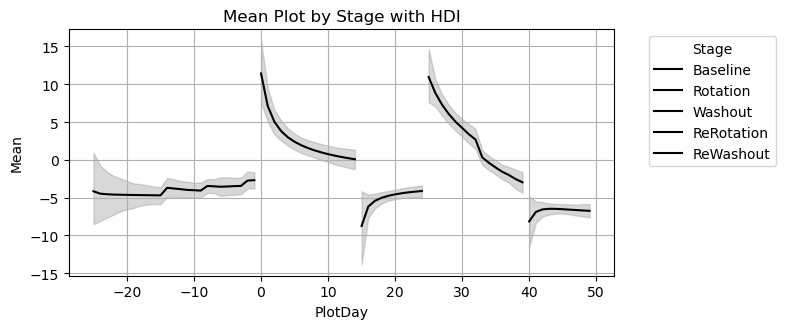

In [143]:
# Get unique stages
stages = hdi_df['Stage'].unique()

# Create a plot for each stage
plt.figure(figsize=(8, 3.4))
plt.style.use('default')
for stage in stages:
    # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
    
    # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay'], stage_data['Mean'], 
             label=stage, color='black')  # Default to black if stage not in color map
    
    # Plot the HDI shading for the current stage
    plt.fill_between(stage_data['PlotDay'], 
                     stage_data['HDI_Lower'], 
                     stage_data['HDI_Upper'],
                     color='grey',  # Use the same color as the line
                     alpha=0.3, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)

# Add labels and title
plt.xlabel('PlotDay')
plt.ylabel('Mean')
plt.title('Mean Plot by Stage with HDI')
plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position if needed
plt.grid(True)

# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

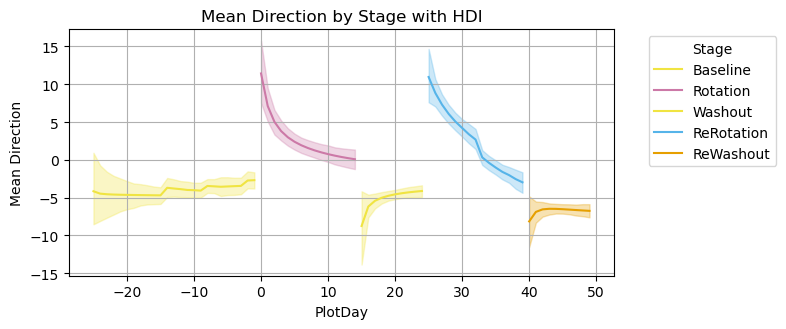

In [144]:
# Get unique stages
stages = hdi_df['Stage'].unique()
# Create a plot for each stage
plt.figure(figsize=(8, 3.4))
for stage in stages:
    # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
    
    # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay'], stage_data['Mean'], 
             label=stage, color=phase_colors.get(stage, 'black'))  # Default to black if stage not in color map
    
    # Plot the HDI shading for the current stage
    plt.fill_between(stage_data['PlotDay'], 
                     stage_data['HDI_Lower'], 
                     stage_data['HDI_Upper'],
                     color=phase_colors.get(stage, 'black'),  # Use the same color as the line
                     alpha=0.3, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)

# Add labels and title
plt.xlabel('PlotDay')
plt.ylabel('Mean Direction')
plt.title('Mean Direction by Stage with HDI')
plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position if needed
plt.grid(True)

# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [145]:
hdi_df.to_csv('DirectionAfish.csv')

In [146]:
median_df = []
# Calculate median for each combination of stage, fish, and plotday

# Define stages in the desired order
stages_All = ['Baseline', 'Rotation', 'Washout', 'ReRotation', 'ReWashout']

# Sample DataFrame (replace with your actual DataFrame)
median_df = y_obd_plot.groupby(['fish', 'stage', 'day', 'plotday'])['y'].median().reset_index()

# Convert 'stage' column to a categorical type with the specified order
median_df['stage'] = pd.Categorical(median_df['stage'], categories=stages_All, ordered=True)

# Sort the DataFrame based on 'fish', 'stage', 'day', and 'plotday'
median_df = median_df.sort_values(by=['fish', 'stage', 'day', 'plotday']).reset_index(drop=True)


In [147]:
# Initialize the 'PlotDay' column with NaN values
median_df['PlotDay'] = pd.NA



In [148]:
def assign_plotday(df):
    if df.empty:
        return df
    
    # Find the index of the first 'Rotation' stage
    rotation_indices = df[df['stage'] == 'Rotation'].index
    
    if not rotation_indices.empty:
        # Get the index of the first occurrence of 'Rotation' for the current fish
        rotation_index = rotation_indices[0]
        
        # Set PlotDay to 0 for the first 'Rotation' day
        df.at[rotation_index, 'PlotDay'] = 0
        
        # Assign 'PlotDay' for days before the 'Rotation' stage
        for i in range(rotation_index - 1, -1, -1):
            df.at[i, 'PlotDay'] = df.at[i + 1, 'PlotDay'] - 1
        
        # Assign 'PlotDay' for days after the 'Rotation' stage
        for i in range(rotation_index + 1, len(df)):
            df.at[i, 'PlotDay'] = df.at[i - 1, 'PlotDay'] + 1
                
    return df

# Apply the function to each fish's data
median_df = median_df.groupby('fish').apply(assign_plotday).reset_index(drop=True)
# Remove rows where 'fish' is NaN
median_df = median_df.dropna(subset=['fish']).reset_index(drop=True)
# Display the updated DataFrame for verification



C:\Users\86153\AppData\Local\Temp\ipykernel_39092\3004032406.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  median_df = median_df.groupby('fish').apply(assign_plotday).reset_index(drop=True)


In [149]:
median_df.to_csv('median.csv')

## Figure 2 and 4

C:\Users\86153\AppData\Local\Temp\ipykernel_39092\3901125991.py:70: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust layout to prevent clipping of labels


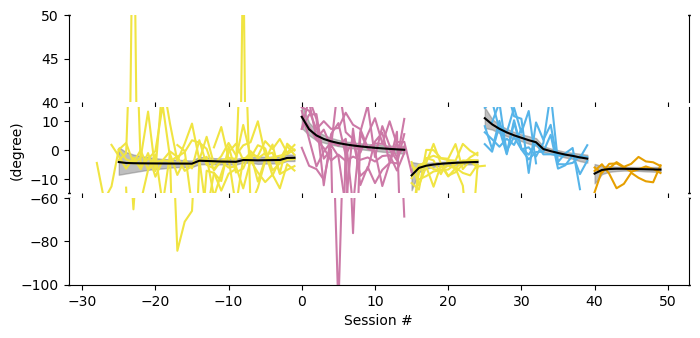

In [150]:
import matplotlib.pyplot as plt

# Create a figure and three subplots with shared x-axis
fig, (ax3, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(8, 3.5))
fig.subplots_adjust(hspace=0.05)  # Adjust space between Axes

# Plotting for each fish and stage
for fish in median_df['fish'].unique():
    for stage in stages:
        medianEFish = median_df[(median_df['fish'] == fish) & (median_df['stage'] == stage)]
        ax1.plot(medianEFish['PlotDay'], medianEFish['y'], 
                 label=stage, color=phase_colors.get(stage, 'black'), alpha=1)
        ax2.plot(medianEFish['PlotDay'], medianEFish['y'], 
                 label=stage, color=phase_colors.get(stage, 'black'), alpha=1)
        ax3.plot(medianEFish['PlotDay'], medianEFish['y'], 
                 label=stage, color=phase_colors.get(stage, 'black'), alpha=1)

# Plotting the HDI for each stage
for stage in stages:
    stage_data = hdi_df[hdi_df['Stage'] == stage]
    ax1.plot(stage_data['PlotDay'], stage_data['Mean'], label=stage, color='black')
    ax2.plot(stage_data['PlotDay'], stage_data['Mean'], label=stage, color='black')
    ax3.plot(stage_data['PlotDay'], stage_data['Mean'], label=stage, color='black')

    ax1.fill_between(stage_data['PlotDay'], stage_data['HDI_Lower'], stage_data['HDI_Upper'],
                     color='grey', alpha=0.5, label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)
    ax2.fill_between(stage_data['PlotDay'], stage_data['HDI_Lower'], stage_data['HDI_Upper'],
                     color='grey', alpha=0.5)
    ax3.fill_between(stage_data['PlotDay'], stage_data['HDI_Lower'], stage_data['HDI_Upper'],
                     color='grey', alpha=0.5)

# Set y-axis limits to create the broken axis effect
ax3.set_ylim(40, 50)   # Upper outliers
ax2.set_ylim(-100, -60)  # Lower outliers
ax1.set_ylim(-15, 15)  # Main data range

# Hide the spines between the axes
ax1.spines.top.set_visible(False)
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
#ax2.spines.bottom.set_visible(False)
ax3.spines.top.set_visible(False)
ax3.spines.bottom.set_visible(False)

# Adjust ticks
# ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)
# ax2.xaxis.tick_bottom()
ax2.xaxis.tick_bottom()

# Add slanted lines to indicate the breaks in the y-axis
d = .015  # Proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=2,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
ax2.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax3.transAxes, **kwargs)
ax3.plot([0, 1], [0, 0], transform=ax2.transAxes, **kwargs)

# Labels and grid
ax2.set_xlabel('Session #')
# ax2.set_ylabel('(degree)')
ax1.set_ylabel('(degree)')

ax1.grid(False)
ax2.grid(False)
ax3.grid(False)

# Save and show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig(os.path.join(plotfolder, f'Figure4B_broken_axis_three_parts.png'), bbox_inches='tight', dpi=600)
plt.show()


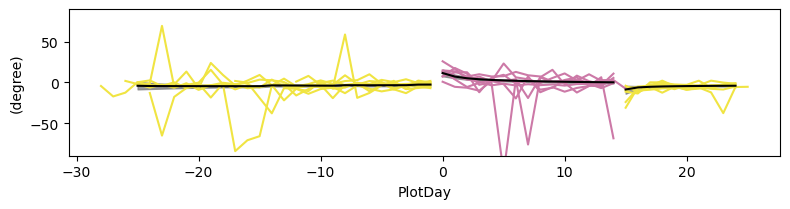

In [151]:
# Get unique stages
stages = stages_BWR

# Create a plot for each stage
plt.figure(figsize=(8, 2.2))
plt.style.use('default')
for fish in median_df['fish'].unique():
    for stage in stages:
        # Filter data for the current fish and stage
        medianEFish = median_df[(median_df['fish'] == fish) & (median_df['stage'] == stage)]
        
        # Plot the mean line for the current fish and stage
        plt.plot(medianEFish['PlotDay'], medianEFish['y'], 
                 label=stage, color=phase_colors.get(stage, 'black'),alpha=1)  # Default to black if stage not in color map

for stage in stages:
    # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
    
    # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay'], stage_data['Mean'], 
             label=stage, color='black')  # Default to black if stage not in color map

    # Plot the HDI shading for the current stage
    plt.fill_between(stage_data['PlotDay'], 
                     stage_data['HDI_Lower'], 
                     stage_data['HDI_Upper'],
                     color='grey',  # Use the same color as the line
                     alpha=0.8, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)

# Add labels and title
plt.xlabel('PlotDay')
plt.ylabel('(degree)')
# plt.title('Mean Plot by Stage with HDI')
# plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position if needed
plt.ylim(-90,90)  # Set fixed data range for y-axis
plt.grid(False)  # Show grid
# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig(os.path.join(plotfolder, f'Figure2D.png'), bbox_inches='tight', dpi=600)

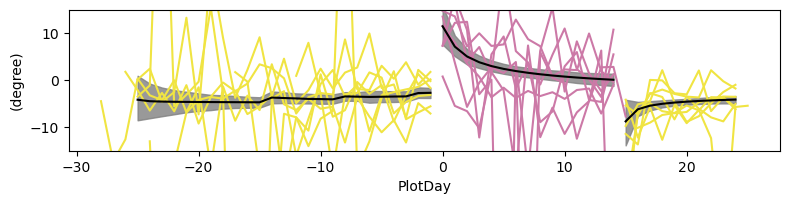

In [152]:
# Get unique stages
stages = stages_BWR

# Create a plot for each stage
plt.figure(figsize=(8, 2.2))
plt.style.use('default')
for fish in median_df['fish'].unique():
    for stage in stages:
        # Filter data for the current fish and stage
        medianEFish = median_df[(median_df['fish'] == fish) & (median_df['stage'] == stage)]
        
        # Plot the mean line for the current fish and stage
        plt.plot(medianEFish['PlotDay'], medianEFish['y'], 
                 label=stage, color=phase_colors.get(stage, 'black'),alpha=1)  # Default to black if stage not in color map

for stage in stages:
    # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
    
    # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay'], stage_data['Mean'], 
             label=stage, color='black')  # Default to black if stage not in color map

    # Plot the HDI shading for the current stage
    plt.fill_between(stage_data['PlotDay'], 
                     stage_data['HDI_Lower'], 
                     stage_data['HDI_Upper'],
                     color='grey',  # Use the same color as the line
                     alpha=0.8, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)

# Add labels and title
plt.xlabel('PlotDay')
plt.ylabel('(degree)')
# plt.title('Mean Plot by Stage with HDI')
# plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position if needed
plt.ylim(-15,15)  # Set fixed data range for y-axis
plt.grid(False)  # Show grid
# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig(os.path.join(plotfolder, f'Figure2Dbig.png'), bbox_inches='tight', dpi=600)

In [153]:
PPC_plot_df = []
PPC_plot_df = ppcplot_df_day.groupby('fish').apply(assign_plotday).reset_index(drop=True)
PPC_plot_df = PPC_plot_df.dropna(subset=['fish']).reset_index(drop=True)
PPC_plot_df = PPC_plot_df.groupby('fish').apply(assign_plotday).reset_index(drop=True)

C:\Users\86153\AppData\Local\Temp\ipykernel_39092\4090835716.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  PPC_plot_df = ppcplot_df_day.groupby('fish').apply(assign_plotday).reset_index(drop=True)
C:\Users\86153\AppData\Local\Temp\ipykernel_39092\4090835716.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  PPC_plot_df = PPC_plot_df.groupby('fish').apply(assign_plotday).reset_index(drop=True)


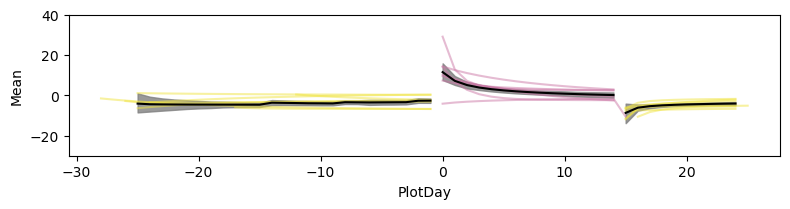

In [154]:
# Get unique stages
stages = stages_BWR

# Create a plot for each stage
plt.figure(figsize=(8, 2.2))
plt.style.use('default')
# for fish in median_df['fish'].unique():
#     for stage in stages:
#         # Filter data for the current fish and stage
#         medianEFish = median_df[(median_df['fish'] == fish) & (median_df['stage'] == stage)]
        
#         # Plot the mean line for the current fish and stage
#         plt.plot(medianEFish['PlotDay'], medianEFish['y'], 
#                  label=stage, color=phase_colors.get(stage, 'black'),alpha=0.5 )  # Default to black if stage not in color map
for fish in PPC_plot_df['fish'].unique():
    for i, stage in enumerate(stages_BWR):
        data_filter = PPC_plot_df [(PPC_plot_df['fish'] == fish) & (PPC_plot_df['stage'] == stage)]        
        plt.plot(data_filter['PlotDay'], data_filter['median_μ_μ_y'], label=f'Median μ_μ_y - {stage}', color=phase_colors.get(stage, 'black'),alpha=0.5)

for stage in stages:
    # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
    
    # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay'], stage_data['Mean'], 
             label=stage, color='black')  # Default to black if stage not in color map

    # Plot the HDI shading for the current stage
    plt.fill_between(stage_data['PlotDay'], 
                     stage_data['HDI_Lower'], 
                     stage_data['HDI_Upper'],
                     color='grey',  # Use the same color as the line
                     alpha=0.8, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)

# Add labels and title
plt.xlabel('PlotDay')
plt.ylabel('Mean')
# plt.title('Mean Plot by Stage with HDI')
# plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position if needed
plt.ylim(-30,40)  # Set fixed data range for y-axis
plt.grid(False)  # Show grid
# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

## Figure 6

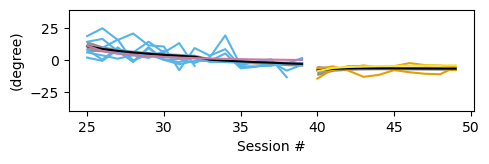

In [155]:


# Create a plot for each stage
plt.figure(figsize=(5, 1.8))
plt.style.use('default')
for fish in median_df['fish'].unique():
    for stage in stages_ReRReW:
        # Filter data for the current fish and stage
        medianEFish = median_df[(median_df['fish'] == fish) & (median_df['stage'] == stage)]
        
        # Plot the mean line for the current fish and stage
        plt.plot(medianEFish['PlotDay'], medianEFish['y'], 
                 label=stage, color=phase_colors.get(stage, 'black'),alpha=1 )  # Default to black if stage not in color map

        
for stage in stages_ReRReW:
    # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
    
    # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay'], stage_data['Mean'], 
             label=stage, color='black')  # Default to black if stage not in color map

    # Plot the HDI shading for the current stage
    plt.fill_between(stage_data['PlotDay'], 
                     stage_data['HDI_Lower'], 
                     stage_data['HDI_Upper'],
                     color='grey',  # Use the same color as the line
                     alpha=0.8, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)
    
for stage in stages_RW:
     # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
        # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay']+25 ,stage_data['Mean'], 
             label=stage, color=phase_colors.get(stage, 'black'))  # Default to black if stage not in color map

# Add labels and title
plt.xlabel('Session #')
plt.ylabel('(degree)')
# plt.title('Mean Plot by Stage with HDI')
# plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position if needed
plt.ylim(-40,40)  # Set fixed data range for y-axis
plt.grid(False)  # Show grid
# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig(os.path.join(plotfolder, f'Figure6B1.png'), bbox_inches='tight', dpi=600)

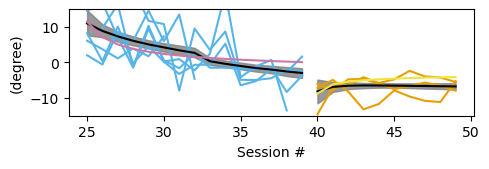

In [156]:


# Create a plot for each stage
plt.figure(figsize=(5, 1.8))
plt.style.use('default')
for fish in median_df['fish'].unique():
    for stage in stages_ReRReW:
        # Filter data for the current fish and stage
        medianEFish = median_df[(median_df['fish'] == fish) & (median_df['stage'] == stage)]
        
        # Plot the mean line for the current fish and stage
        plt.plot(medianEFish['PlotDay'], medianEFish['y'], 
                 label=stage, color=phase_colors.get(stage, 'black'),alpha=1 )  # Default to black if stage not in color map

        
for stage in stages_ReRReW:
    # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
    
    # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay'], stage_data['Mean'], 
             label=stage, color='black')  # Default to black if stage not in color map

    # Plot the HDI shading for the current stage
    plt.fill_between(stage_data['PlotDay'], 
                     stage_data['HDI_Lower'], 
                     stage_data['HDI_Upper'],
                     color='grey',  # Use the same color as the line
                     alpha=0.8, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)
    
for stage in stages_RW:
     # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
        # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay']+25 ,stage_data['Mean'], 
             label=stage, color=phase_colors.get(stage, 'black'))  # Default to black if stage not in color map

# Add labels and title
plt.xlabel('Session #')
plt.ylabel('(degree)')
# plt.title('Mean Plot by Stage with HDI')
# plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position if needed
plt.ylim(-15,15)  # Set fixed data range for y-axis
plt.grid(False)  # Show grid
# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig(os.path.join(plotfolder, f'FigureCbig.png'), bbox_inches='tight', dpi=600)

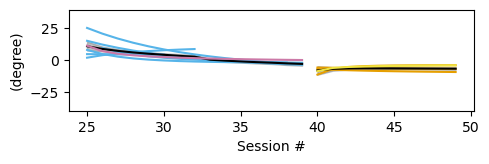

In [157]:


# Create a plot for each stage
plt.figure(figsize=(5, 1.8))
plt.style.use('default')
# for fish in median_df['fish'].unique():
#     for stage in stages_ReRReW:
#         # Filter data for the current fish and stage
#         medianEFish = median_df[(median_df['fish'] == fish) & (median_df['stage'] == stage)]
        
#         # Plot the mean line for the current fish and stage
#         plt.plot(medianEFish['PlotDay'], medianEFish['y'], 
#                  label=stage, color=phase_colors.get(stage, 'black'),alpha=1 )  # Default to black if stage not in color map
for fish in PPC_plot_df['fish'].unique():
    for i, stage in enumerate(stages_ReRReW):
        data_filter = PPC_plot_df [(PPC_plot_df['fish'] == fish) & (PPC_plot_df['stage'] == stage)]        
        plt.plot(data_filter['PlotDay'], data_filter['mean_μ_μ_y'], label=f'μ_μ_y - {stage}', color=phase_colors.get(stage, 'black'),alpha=1)
        
for stage in stages_ReRReW:
    # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
    
    # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay'], stage_data['Mean'], 
             label=stage, color='black')  # Default to black if stage not in color map

    # Plot the HDI shading for the current stage
    plt.fill_between(stage_data['PlotDay'], 
                     stage_data['HDI_Lower'], 
                     stage_data['HDI_Upper'],
                     color='grey',  # Use the same color as the line
                     alpha=0.5, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)
    
for stage in stages_RW:
     # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
        # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay']+25 ,stage_data['Mean'], 
             label=stage, color=phase_colors.get(stage, 'black'))  # Default to black if stage not in color map

# Add labels and title
plt.xlabel('Session #')
plt.ylabel('(degree)')
# plt.title('Mean Plot by Stage with HDI')
# plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position if needed
plt.ylim(-40,40)  # Set fixed data range for y-axis
plt.grid(False)  # Show grid
# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig(os.path.join(plotfolder, f'Figure6B2.png'), bbox_inches='tight', dpi=600)

## Figure for baseline

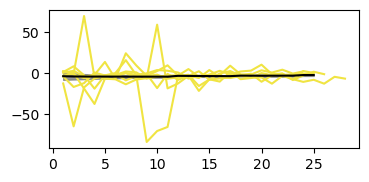

In [158]:
# Create a plot for each stage
plt.figure(figsize=(4, 1.8))
plt.style.use('default')

for fish in ppcplot_df_day['fish'].unique():
    # Filter data for the current fish and stage
    data_filter = ppcplot_df_day[(ppcplot_df_day['fish'] == fish) & (ppcplot_df_day['stage'] == 'Baseline')]
    data_filter2 = y_obd_plot[(y_obd_plot['fish'] == fish) & (y_obd_plot['stage'] == 'Baseline')]
        # Plot mean_y against plotday for the current stage
    plt.plot(data_filter['plotday'], data_filter['median_y'], label=f'Median Y - {stage}', color='#F0E442')


    # Filter data for the current stage
stage_data = stage_data = hdi_df[hdi_df['Stage'] == 'Baseline']
    
    # Plot the mean line for the current stage
plt.plot(stage_data['PlotDay']+26, stage_data['Mean'], 
             label=stage, color='black')  # Default to black if stage not in color map
    
    # Plot the HDI shading for the current stage
plt.fill_between(stage_data['PlotDay']+26, 
                     stage_data['HDI_Lower'], 
                     stage_data['HDI_Upper'],
                     color='grey',  # Use the same color as the line
                     alpha=0.8, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)
plt.savefig(os.path.join(plotfolder, f'Figure3Is.png'), bbox_inches='tight', dpi=600)

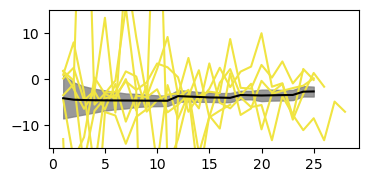

In [159]:
# Create a plot for each stage
plt.figure(figsize=(4, 1.8))
plt.style.use('default')

for fish in ppcplot_df_day['fish'].unique():
    # Filter data for the current fish and stage
    data_filter = ppcplot_df_day[(ppcplot_df_day['fish'] == fish) & (ppcplot_df_day['stage'] == 'Baseline')]
    data_filter2 = y_obd_plot[(y_obd_plot['fish'] == fish) & (y_obd_plot['stage'] == 'Baseline')]
        # Plot mean_y against plotday for the current stage
    plt.plot(data_filter['plotday'], data_filter['median_y'], label=f'Median Y - {stage}', color='#F0E442')


    # Filter data for the current stage
stage_data = stage_data = hdi_df[hdi_df['Stage'] == 'Baseline']
    
    # Plot the mean line for the current stage
plt.plot(stage_data['PlotDay']+26, stage_data['Mean'], 
             label=stage, color='black')  # Default to black if stage not in color map
    
    # Plot the HDI shading for the current stage
plt.fill_between(stage_data['PlotDay']+26, 
                     stage_data['HDI_Lower'], 
                     stage_data['HDI_Upper'],
                     color='grey',  # Use the same color as the line
                     alpha=0.8, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)
plt.ylim(-15,15)
plt.savefig(os.path.join(plotfolder, f'Figure3Ib.png'), bbox_inches='tight', dpi=600)

In [160]:
IE_FR_B = IE_F.sel(stages=BP['stages'].isin(['Baseline']))
df_IE_B = IE_FR_B.to_dataframe(name='IE_FR_B').reset_index()

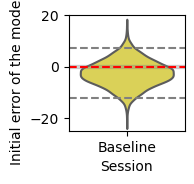

In [161]:
  # Yellow
# Define the bounds of the ROPE
rope_min = 0.5
rope_max = -0.5
color = {'session':{'Baseline': '#F0E442'}}
plt.figure(figsize=(1.5, 1.5))
sns.violinplot(data=df_IE_B , x="stages", y="IE_FR_B", palette=color['session'], inner=None)
# Add ROPE
plt.axhspan(rope_min, rope_max, color='grey', alpha=0.3, label='ROPE')

plt.axhline(y=ADirectionIE.loc['x[Baseline]','hdi_3%'], color='grey', linestyle='--')
plt.axhline(y=ADirectionIE.loc['x[Baseline]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ALengthBP.loc['x[ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ALengthBP.loc['x[ReRotation]','hdi_97%'], color='grey', linestyle='--')

plt.ylim(-25, 20)
plt.xlabel('Session')

plt.ylabel('Initial error of the modelfit')
plt.legend().set_visible(False)
#plt.title('Best performance Across Sessions')
plt.axhline(y=0, color='red', linestyle='--')
plt.savefig(os.path.join(plotfolder, f'Figure2B2.png'), bbox_inches='tight', dpi=600)

In [162]:
BP_FR_B = BP_F.sel(stages=BP['stages'].isin(['Baseline']))
df_FR_B = BP_FR_B.to_dataframe(name='BP_FR_B').reset_index()

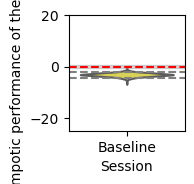

In [163]:
  # Yellow
# Define the bounds of the ROPE
rope_min = 0.5
rope_max = -0.5
color = {'session':{'Baseline': '#F0E442'}}
plt.figure(figsize=(1.5, 1.5))
sns.violinplot(data=df_FR_B , x="stages", y="BP_FR_B", palette=color['session'], inner=None)
# Add ROPE
plt.axhspan(rope_min, rope_max, color='grey', alpha=0.3, label='ROPE')

plt.axhline(y=ADirectionBP.loc['μ_μ_inf[Baseline]','hdi_3%'], color='grey', linestyle='--')
plt.axhline(y=ADirectionBP.loc['μ_μ_inf[Baseline]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ALengthBP.loc['x[ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ALengthBP.loc['x[ReRotation]','hdi_97%'], color='grey', linestyle='--')
plt.ylim(-25, 20)
# plt.ylim(-8, 20)
plt.xlabel('Session')

plt.ylabel('Asympotic performance of the modelfit')
plt.legend().set_visible(False)
#plt.title('Best performance Across Sessions')
plt.axhline(y=0, color='red', linestyle='--')
plt.savefig(os.path.join(plotfolder, f'Figure2B3.png'), bbox_inches='tight', dpi=600)

In [164]:
LR_FR_B = LR_F.sel(stages=LR['stages'].isin(['Baseline']))
df_LR_FR_B = LR_FR_B.to_dataframe(name='LR_FR_B').reset_index()

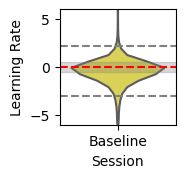

In [165]:
# Define the bounds of the ROPE
rope_min = 0.5
rope_max = -0.5
color = {'session':{'Baseline': '#F0E442'}}
# Set the plotting style
plt.style.use('default')
# Plot the violin plots for each session
plt.figure(figsize=(1.5, 1.5))

sns.violinplot(data=df_LR_FR_B, x="stages", y="LR_FR_B", palette=color['session'], inner=None)
# Add ROPE
plt.axhspan(rope_min, rope_max, color='grey', alpha=0.3, label='ROPE')
plt.axhline(y=ADirectionLR.loc['x[Baseline]','hdi_3%'], color='grey', linestyle='--')
plt.axhline(y=ADirectionLR.loc['x[Baseline]','hdi_97%'], color='grey', linestyle='--')
# plt.title('Violin Plot of Learning Rates Across Sessions')
plt.axhline(y=0, color='red', linestyle='--')
plt.ylim(-6,6)
plt.xlabel('Session')
plt.ylabel('Learning Rate')
plt.legend().set_visible(False)

plt.savefig(os.path.join(plotfolder, f'Figure2B4.png'), bbox_inches='tight', dpi=600)

# End

#  Debug

In [166]:
# with pm.Model(coords=coords) as md_yds:
#     # Constants
#     fish_ = pm.ConstantData('fish_', df['fish_index'], dims='data')
#     stage_ = pm.ConstantData('stage_', df['stage_index'], dims='data')
#     day_ = pm.ConstantData('day_', df['day_index'], dims='data')

#     # Priors
#     A_μμ = pm.Normal('A_μμ', mu=μ_Aμμ, sigma=σ_Aμμ, dims=('fish', 'stages'))
#     τ_μ = pm.Gamma('τ_μ', alpha=sh_τμ, beta=ra_τμ, dims=('fish', 'stages'))
#     μ_μ_inf = pm.Normal('μ_μ_inf', mu=μ_μμ_inf, sigma=σ_μμ_inf, dims=('fish', 'stages'))

#     # Intermediate steps
#     exp_decay = pm.Deterministic('exp_decay', pm.math.exp(-day_ / τ_μ[fish_, stage_]), dims='data')
#     A_component = pm.Deterministic('A_component', A_μμ[fish_, stage_] * exp_decay, dims='data')
#     μ_μ_component = pm.Deterministic('μ_μ_component', μ_μ_inf[fish_, stage_], dims='data')

#     # Final calculation
#     μ_μ = pm.Deterministic('μ_μ', A_component + μ_μ_component, dims='data')

#     # Sampling
#     trace = pm.sample(1000, chains=2)  # Use more samples and chains for a final run


In [167]:
# one_data =  trace.posterior.μ_μ.isel(chain = 1 , draw = 1,data = [149,150,151,152,153,154,
#                                           597,598, 599, 600, 601, 602, 
#                                           998,999, 1000, 1001, 1002, 1003,
#                                           1394,1395,1396,1397,1398,1399,
#                                           1704,1705,1706,1707,1708,1709,
#                                           1974,1975,1976,1977,1978,1979,
#                                           2302,2303,2304,2305,2306,2307,
#                                           ])
# one_data

In [168]:
# IE  = trace.posterior.A_μμ.isel(chain = 1 , draw = 1) +trace.posterior.μ_μ_inf.isel(chain = 1 , draw = 1)
# IE_R = IE.sel(stages = 'Rotation')
# IE_R

In [169]:
# one_data =  trace.posterior.μ_μ_component.isel(chain = 1 , draw = 1,data = [149,150,151,152,153,154,
#                                           597,598, 599, 600, 601, 602, 
#                                           998,999, 1000, 1001, 1002, 1003,
#                                           1394,1395,1396,1397,1398,1399,
#                                           1704,1705,1706,1707,1708,1709,
#                                           1974,1975,1976,1977,1978,1979,
#                                           2302,2303,2304,2305,2306,2307,
#                                           ])
# one_data

In [170]:
# μ_μ_inf_Rone  = trace.posterior.μ_μ_inf.isel(chain = 1 , draw = 1) 
# μ_μ_inf_Rone.sel(stages = 'Rotation')

In [171]:
# trace.constant_data.day_.isel(data = [149,150,151,152,153,154,
#                                           597,598, 599, 600, 601, 602, 
#                                           998,999, 1000, 1001, 1002, 1003,
#                                           1394,1395,1396,1397,1398,1399,
#                                           1704,1705,1706,1707,1708,1709,
#                                           1974,1975,1976,1977,1978,1979,
#                                           2302,2303,2304,2305,2306,2307,
#                                           ])

In [172]:
# trace.constant_data.stage_.isel(data = [149,150,151,152,153,154,
#                                           597,598, 599, 600, 601, 602, 
#                                           998,999, 1000, 1001, 1002, 1003,
#                                           1394,1395,1396,1397,1398,1399,
#                                           1704,1705,1706,1707,1708,1709,
#                                           1974,1975,1976,1977,1978,1979,
#                                           2302,2303,2304,2305,2306,2307,
#                                           ])

In [173]:
# trace.constant_data.fish_.isel(data = [149,150,151,152,153,154,
#                                           597,598, 599, 600, 601, 602, 
#                                           998,999, 1000, 1001, 1002, 1003,
#                                           1394,1395,1396,1397,1398,1399,
#                                           1704,1705,1706,1707,1708,1709,
#                                           1974,1975,1976,1977,1978,1979,
#                                           2302,2303,2304,2305,2306,2307,
#                                           ])

## The difference of intial performance

Text(0.5, 1.0, 'Initial Performace difference across Fish')

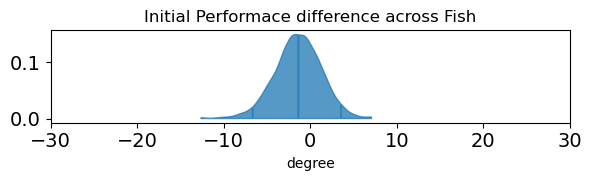

In [174]:
# Step 1: Select the data for 'ReRotation' and 'Rotation'
IE_S = IE.sel(stages='ReRotation')
IE_R = IE.sel(stages='Rotation')
dIE_SR = np.abs(IE_S) - np.abs(IE_R)
dIE_SR_F = dIE_SR.mean(dim="fish")
plt.figure(figsize=(6.7, 1.2))
az.plot_dist(dIE_SR_F, quantiles=[.03, .5, .97])
plt.xlabel('degree')
plt.xlim(-30,30)
plt.title('Initial Performace difference across Fish')

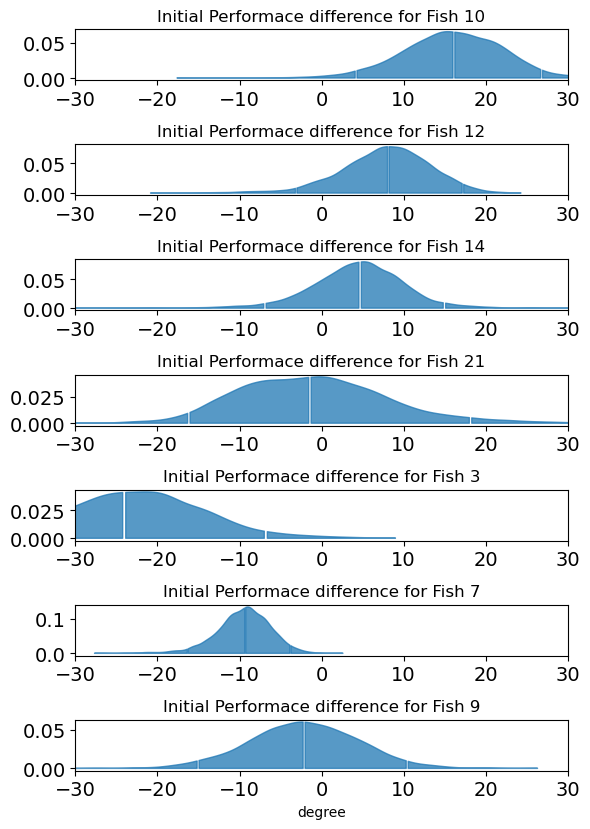

In [175]:
# Assuming dSR is your DataArray
fish_dim = dIE_SR.coords['fish']

# Create a figure with subplots for each fish
fig, axes = plt.subplots(len(fish_dim), 1, figsize=(6, len(fish_dim) * 1.2))

# If there's only one fish, axes might not be an array, so we need to handle that case
if len(fish_dim) == 1:
    axes = [axes]

# Iterate over each fish and plot its distribution
for i, fish in enumerate(fish_dim):
    az.plot_dist(dIE_SR.sel(fish=fish), quantiles=[.03, .5, .97], ax=axes[i])
    axes[i].set_title(f'Initial Performace difference for Fish {fish.item()}')
    axes[i].set_xlim(-30, 30)
plt.xlabel('degree')
plt.tight_layout()
plt.show()

## difference of asymptotic performane 

Text(0.5, 1.0, 'Asymptotic Performace difference across Fish')

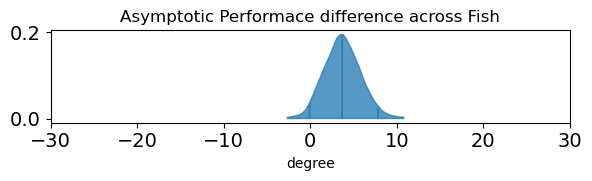

In [176]:
# Step 1: Select the data for 'ReRotation' and 'Rotation'
AP_S = BP.sel(stages='ReRotation')
AP_R = BP.sel(stages='Rotation')
dAP_SR = np.abs(AP_S) - np.abs(AP_R)
dAP_SR_F = dAP_SR.mean(dim="fish")
plt.figure(figsize=(6.7, 1.2))
az.plot_dist(dAP_SR_F, quantiles=[.03, .5, .97])
plt.xlim(-30,30)
plt.xlabel('degree')
plt.title('Asymptotic Performace difference across Fish')

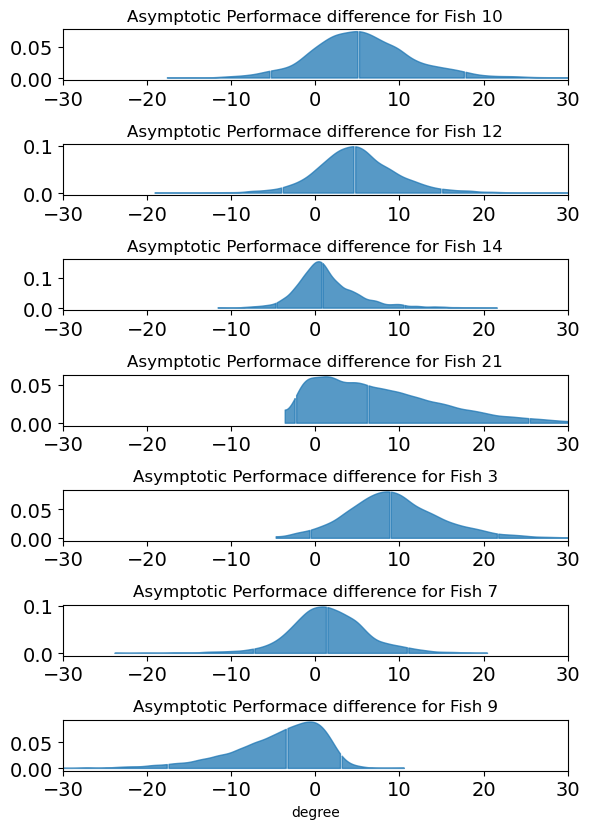

In [177]:
# Assuming dSR is your DataArray
fish_dim = dAP_SR.coords['fish']

# Create a figure with subplots for each fish
fig, axes = plt.subplots(len(fish_dim), 1, figsize=(6, len(fish_dim) * 1.2))

# If there's only one fish, axes might not be an array, so we need to handle that case
if len(fish_dim) == 1:
    axes = [axes]

# Iterate over each fish and plot its distribution
for i, fish in enumerate(fish_dim):
    az.plot_dist(dAP_SR.sel(fish=fish), quantiles=[.03, .5, .97],  ax=axes[i])

    axes[i].set_title(f'Asymptotic Performace difference for Fish {fish.item()}')
    axes[i].set_xlim(-30, 30)
plt.xlabel('degree')
plt.tight_layout()
plt.show()